In [ ]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Cell 2: Install dependencies
#!pip install medmnist torch torchvision numpy matplotlib seaborn scikit-learn pandas tqdm albumentations

# Cell 3: Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import medmnist
from medmnist import INFO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve, average_precision_score)
from tqdm import tqdm
import os
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Print versions for verification
print(f"PyTorch version: {torch.__version__}")
print(f"MedMNIST version: {medmnist.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Cell 4: Configuration
class Config:
    DATA_FLAG = "pneumoniamnist"
    IMG_SIZE = 28
    NUM_CHANNELS = 1
    NUM_CLASSES = 2
    BATCH_SIZE = 64
    EPOCHS = 30
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4
    DROPOUT_RATE = 0.3
    ROTATION_RANGE = 10
    ZOOM_RANGE = 0.1
    SHIFT_RANGE = 0.1
    SAVE_DIR = '/content/drive/MyDrive/pneumonia_detection/models'
    RESULTS_DIR = '/content/drive/MyDrive/pneumonia_detection/results'
    SEED = 42

# Create directories
os.makedirs(Config.SAVE_DIR, exist_ok=True)
os.makedirs(Config.RESULTS_DIR, exist_ok=True)

# Cell 5: Set seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(Config.SEED)

# Cell 6: Dataset Class (FINAL FIXED version)
from torchvision import transforms
from PIL import Image
import numpy as np

class PneumoniaMNISTDataset(Dataset):
    def __init__(self, split='train', transform=None):
        self.split = split
        self.transform = transform

        # Get dataset info
        info = INFO[Config.DATA_FLAG]
        DataClass = getattr(medmnist, info['python_class'])

        # Download and load data
        self.data = DataClass(split=split, download=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]

        # Convert to numpy array if it's a tensor
        if isinstance(image, torch.Tensor):
            image = image.numpy()

        # Ensure image is 2D (height, width)
        if len(image.shape) == 3:
            # Take first channel if multiple
            image = image[0] if image.shape[0] == 1 else image.mean(axis=0)

        # Convert to uint8 if needed (MedMNIST provides [0,255] uint8)
        if image.dtype != np.uint8:
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = image.astype(np.uint8)

        # Create PIL Image
        image = Image.fromarray(image, mode='L')

        # Apply transforms
        if self.transform:
            image = self.transform(image)
        else:
            # Default transform to tensor
            to_tensor = transforms.ToTensor()
            image = to_tensor(image)

        # Convert label to tensor
        if isinstance(label, torch.Tensor):
            label = label.item()
        label = torch.LongTensor([label])[0]

        return image, label

# Cell 7: Data transforms
def get_transforms(split='train'):
    if split == 'train':
        transform = transforms.Compose([
            transforms.RandomRotation(Config.ROTATION_RANGE),
            transforms.RandomAffine(
                degrees=0,
                translate=(Config.SHIFT_RANGE, Config.SHIFT_RANGE),
                scale=(1-Config.ZOOM_RANGE, 1+Config.ZOOM_RANGE)
            ),
            transforms.ToTensor(),
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    return transform

# Cell 8: Data Loaders
def get_data_loaders():
    train_dataset = PneumoniaMNISTDataset(
        split='train',
        transform=get_transforms('train')
    )
    val_dataset = PneumoniaMNISTDataset(
        split='val',
        transform=get_transforms('val')
    )
    test_dataset = PneumoniaMNISTDataset(
        split='test',
        transform=get_transforms('test')
    )

    # Set num_workers=0 for Colab to avoid multiprocessing issues
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

# Cell 9: Model Architecture
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.3):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Cell 10: Training Functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities[:, 1].cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds, all_probs

# Cell 11: Main Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load data
print("Loading data...")
train_loader, val_loader, test_loader = get_data_loaders()

# Print dataset sizes
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

# Test a single batch to verify data loading works
print("\nTesting data loader...")
try:
    # Get a single batch
    images, labels = next(iter(train_loader))
    print(f"✓ Data loader working correctly!")
    print(f"  Batch shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Image min: {images.min():.3f}, max: {images.max():.3f}")
    print(f"  Label distribution: {torch.bincount(labels)}")
except Exception as e:
    print(f"✗ Error in data loader: {e}")
    raise e

# Create model
model = CustomCNN(num_classes=Config.NUM_CLASSES, dropout_rate=Config.DROPOUT_RATE)
model = model.to(device)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE,
                       weight_decay=Config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  factor=0.5, patience=3, verbose=True)

# Training
print("\nStarting training...")
best_val_f1 = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(Config.EPOCHS):
    print(f"\nEpoch {epoch+1}/{Config.EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _, _ = validate(
        model, val_loader, criterion, device
    )

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Val Precision: {val_prec:.4f}, Val Recall: {val_rec:.4f}, Val F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
        }, os.path.join(Config.SAVE_DIR, 'best_model.pth'))
        print(f"✓ Saved best model with F1: {val_f1:.4f}")

# Cell 12: Plot Training Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Accuracy', color='blue')
ax2.plot(val_accs, label='Val Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(Config.RESULTS_DIR, 'training_curves.png'))
plt.show()

# Cell 13: Final Evaluation
print("\n=== Evaluating on Test Set ===")
checkpoint = torch.load(os.path.join(Config.SAVE_DIR, 'best_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']} with val F1: {checkpoint['val_f1']:.4f}")

test_loss, test_acc, test_prec, test_rec, test_f1, y_true, y_pred, y_scores = validate(
    model, test_loader, criterion, device
)

print(f"\nTest Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall: {test_rec:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Cell 14: Classification Report
print("\nClassification Report:")
target_names = ['Normal', 'Pneumonia']
print(classification_report(y_true, y_pred, target_names=target_names))

# Cell 15: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(os.path.join(Config.RESULTS_DIR, 'confusion_matrix.png'))
plt.show()

# Cell 16: ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(Config.RESULTS_DIR, 'roc_curve.png'))
plt.show()

print(f"ROC AUC: {roc_auc:.4f}")

# Cell 17: Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, _ = precision_recall_curve(y_true, y_scores)
avg_precision = average_precision_score(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2,
         label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(Config.RESULTS_DIR, 'precision_recall_curve.png'))
plt.show()

print(f"Average Precision: {avg_precision:.4f}")

# Cell 18: Failure Case Analysis
model.eval()
failure_images = []
failure_labels = []
failure_preds = []
failure_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

        misclassified = (predicted != labels).cpu().numpy()

        if np.any(misclassified):
            # Move images to CPU for visualization
            failure_images.extend(images[misclassified].cpu().numpy())
            failure_labels.extend(labels[misclassified].cpu().numpy())
            failure_preds.extend(predicted[misclassified].cpu().numpy())
            failure_probs.extend(probs[misclassified, 1].cpu().numpy())

# Plot failure cases
num_to_plot = min(10, len(failure_images))
if num_to_plot > 0:
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(num_to_plot):
        # Image is in shape [C, H, W], need to squeeze channel dim for display
        img_to_display = failure_images[i].squeeze()
        axes[i].imshow(img_to_display, cmap='gray')

        true_label = "Pneumonia" if failure_labels[i] == 1 else "Normal"
        pred_label = "Pneumonia" if failure_preds[i] == 1 else "Normal"
        prob = failure_probs[i] if failure_preds[i] == 1 else 1 - failure_probs[i]

        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nProb: {prob:.2f}', fontsize=8)
        axes[i].axis('off')

    # Hide empty subplots
    for i in range(num_to_plot, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'failure_cases.png'))
    plt.show()

    print(f"\nTotal misclassifications: {len(failure_labels)}")
    false_positives = sum(1 for i in range(len(failure_labels))
                         if failure_labels[i] == 0 and failure_preds[i] == 1)
    false_negatives = sum(1 for i in range(len(failure_labels))
                         if failure_labels[i] == 1 and failure_preds[i] == 0)
    print(f"False Positives (Normal -> Pneumonia): {false_positives}")
    print(f"False Negatives (Pneumonia -> Normal): {false_negatives}")
else:
    print("No misclassifications found!")

# Cell 19: Save metrics
metrics = {
    'test_accuracy': float(test_acc),
    'test_precision': float(test_prec),
    'test_recall': float(test_rec),
    'test_f1': float(test_f1),
    'roc_auc': float(roc_auc),
    'avg_precision': float(avg_precision)
}

with open(os.path.join(Config.RESULTS_DIR, 'metrics.json'), 'w') as f:
    json.dump(metrics, f, indent=4)

print("\n✓ All results saved to Google Drive!")
print(f"Models saved to: {Config.SAVE_DIR}")
print(f"Results saved to: {Config.RESULTS_DIR}")

# Cell 20: Show sample images from dataset
def show_sample_images():
    """Display sample images from the dataset"""
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    # Get a batch from training set
    images, labels = next(iter(train_loader))

    # Find indices for normal and pneumonia
    normal_indices = (labels == 0).nonzero(as_tuple=True)[0]
    pneumonia_indices = (labels == 1).nonzero(as_tuple=True)[0]

    for i in range(5):
        # Normal images
        if i < len(normal_indices):
            axes[0, i].imshow(images[normal_indices[i]].squeeze(), cmap='gray')
            axes[0, i].set_title('Normal')
            axes[0, i].axis('off')

        # Pneumonia images
        if i < len(pneumonia_indices):
            axes[1, i].imshow(images[pneumonia_indices[i]].squeeze(), cmap='gray')
            axes[1, i].set_title('Pneumonia')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'sample_images.png'))
    plt.show()

# Show sample images
show_sample_images()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch version: 2.2.0+cu121
MedMNIST version: 2.1.0
CUDA available: False
Using device: cpu
Loading data...
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Training samples: 4708
Validation samples: 524
Test samples: 624

Testing data loader...
✗ Error in data loader: 'Image' object has no attribute 'shape'


AttributeError: 'Image' object has no attribute 'shape'

In [ ]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Cell 2: Install dependencies
#!pip install medmnist torch torchvision numpy matplotlib seaborn scikit-learn pandas tqdm

# Cell 3: Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import medmnist
from medmnist import INFO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve, average_precision_score)
from tqdm import tqdm
import os
import json
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Print versions
print(f"PyTorch version: {torch.__version__}")
print(f"MedMNIST version: {medmnist.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Cell 4: Configuration
class Config:
    BATCH_SIZE = 64
    EPOCHS = 30
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4
    DROPOUT_RATE = 0.3
    SEED = 42

    # Paths
    if os.path.exists('/content/drive'):
        SAVE_DIR = '/content/drive/MyDrive/pneumonia_detection'
        RESULTS_DIR = '/content/drive/MyDrive/pneumonia_detection/results'
    else:
        SAVE_DIR = './saved_models'
        RESULTS_DIR = './reports'

# Create directories
os.makedirs(Config.SAVE_DIR, exist_ok=True)
os.makedirs(Config.RESULTS_DIR, exist_ok=True)

# Set seed
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
set_seed(Config.SEED)

# Cell 5: Dataset Class - COMPLETELY FIXED VERSION
class PneumoniaMNISTDataset(Dataset):
    """Dataset class for PneumoniaMNIST - FIXED version"""

    def __init__(self, split='train', augment=False):
        self.split = split
        self.augment = augment

        # Load MedMNIST data
        info = INFO['pneumoniamnist']
        DataClass = getattr(medmnist, info['python_class'])
        self.data = DataClass(split=split, download=True)

        # Define transforms
        if augment:
            self.transform = transforms.Compose([
                transforms.RandomRotation(10),
                transforms.RandomAffine(
                    degrees=0,
                    translate=(0.1, 0.1),
                    scale=(0.9, 1.1)
                ),
                transforms.ToTensor(),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image and label
        image, label = self.data[idx]

        # Convert to numpy if tensor
        if isinstance(image, torch.Tensor):
            image = image.numpy()

        # CRITICAL FIX: Handle shape BEFORE any PIL conversion
        # MedMNIST returns shape (28, 28) or (1, 28, 28)
        if len(image.shape) == 3:
            if image.shape[0] == 1:
                # If shape is (1, 28, 28), take first channel
                image = image[0]
            else:
                # If multiple channels, take mean
                image = image.mean(axis=0)

        # Now image is 2D (28, 28)
        # Ensure correct dtype and range
        if image.dtype != np.uint8:
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = image.astype(np.uint8)

        # Convert to PIL Image for transforms
        image = Image.fromarray(image, mode='L')

        # Apply transforms
        image = self.transform(image)

        # Convert label
        if isinstance(label, torch.Tensor):
            label = label.item()
        label = torch.tensor(label, dtype=torch.long)

        return image, label

# Cell 6: Data Loaders
def get_data_loaders():
    train_dataset = PneumoniaMNISTDataset(split='train', augment=True)
    val_dataset = PneumoniaMNISTDataset(split='val', augment=False)
    test_dataset = PneumoniaMNISTDataset(split='test', augment=False)

    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

# Cell 7: Model Architecture
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.3):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Cell 8: Training Functions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities[:, 1].cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds, all_probs

# Cell 9: Visualization Functions
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(train_accs, label='Train Accuracy', color='blue')
    ax2.plot(val_accs, label='Val Accuracy', color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'training_curves.png'))
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'confusion_matrix.png'))
    plt.show()
    return cm

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'roc_curve.png'))
    plt.show()
    return roc_auc

# Cell 10: Load and Verify Data
print("Loading data...")
train_loader, val_loader, test_loader = get_data_loaders()

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

# Verify data loading
print("\nVerifying data loader...")
try:
    images, labels = next(iter(train_loader))
    print(f"✓ Data loader working correctly!")
    print(f"  Batch shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Image min: {images.min():.3f}, max: {images.max():.3f}")
    print(f"  Label distribution: {torch.bincount(labels)}")
except Exception as e:
    print(f"✗ Error: {e}")
    raise e

# Cell 11: Create Model
model = CustomCNN(num_classes=2, dropout_rate=Config.DROPOUT_RATE).to(device)
print(f"\nModel created with {count_parameters(model):,} parameters")

# Cell 12: Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_f1 = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting training...")
for epoch in range(Config.EPOCHS):
    print(f"\nEpoch {epoch+1}/{Config.EPOCHS}")
    print("-" * 30)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _, _ = validate(model, val_loader, criterion)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Val F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), os.path.join(Config.SAVE_DIR, 'best_model.pth'))
        print(f"✓ Saved best model")

# Cell 13: Plot Training Curves
plot_training_curves(train_losses, val_losses, train_accs, val_accs)

# Cell 14: Final Evaluation
print("\n" + "="*50)
print("EVALUATING ON TEST SET")
print("="*50)

model.load_state_dict(torch.load(os.path.join(Config.SAVE_DIR, 'best_model.pth')))
test_loss, test_acc, test_prec, test_rec, test_f1, y_true, y_pred, y_scores = validate(
    model, test_loader, criterion
)

print(f"\nTest Results:")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall:    {test_rec:.4f}")
print(f"F1-Score:  {test_f1:.4f}")

# Cell 15: Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Cell 16: Confusion Matrix
cm = plot_confusion_matrix(y_true, y_pred)

# Cell 17: ROC Curve
roc_auc = plot_roc_curve(y_true, y_scores)
print(f"ROC AUC: {roc_auc:.4f}")

# Cell 18: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
avg_precision = average_precision_score(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(Config.RESULTS_DIR, 'precision_recall_curve.png'))
plt.show()
print(f"Average Precision: {avg_precision:.4f}")

# Cell 19: Save Results
results = {
    'test_accuracy': float(test_acc),
    'test_precision': float(test_prec),
    'test_recall': float(test_rec),
    'test_f1': float(test_f1),
    'roc_auc': float(roc_auc),
    'avg_precision': float(avg_precision),
    'best_val_f1': float(best_val_f1)
}

with open(os.path.join(Config.RESULTS_DIR, 'results.json'), 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n✓ All results saved to {Config.RESULTS_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch version: 2.2.0+cu121
MedMNIST version: 2.1.0
CUDA available: False
Using device: cpu
Loading data...
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Training samples: 4708
Validation samples: 524
Test samples: 624

Verifying data loader...
✗ Error: 'Image' object has no attribute 'shape'


AttributeError: 'Image' object has no attribute 'shape'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch version: 2.9.0+cpu
MedMNIST version: 3.0.2
CUDA available: False
Using device: cpu
Loading data...
Training samples: 4708
Validation samples: 524
Test samples: 624

Verifying data loader...
✓ Data loader working correctly!
  Batch shape: torch.Size([64, 1, 28, 28])
  Labels shape: torch.Size([64])
  Image min: 0.000, max: 0.949
  Label distribution: tensor([19, 45])

Model created with 101,506 parameters

Starting training...

Epoch 1/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.14it/s]


Train Loss: 0.3142, Train Acc: 0.8615
Val Loss: 0.1976, Val Acc: 0.9179
Val F1: 0.9445
✓ Saved best model

Epoch 2/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 13.37it/s]


Train Loss: 0.2148, Train Acc: 0.9129
Val Loss: 0.2339, Val Acc: 0.8989
Val F1: 0.9359

Epoch 3/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 14.01it/s]


Train Loss: 0.1893, Train Acc: 0.9233
Val Loss: 0.1552, Val Acc: 0.9256
Val F1: 0.9486
✓ Saved best model

Epoch 4/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 12.49it/s]


Train Loss: 0.1713, Train Acc: 0.9318
Val Loss: 0.3278, Val Acc: 0.8740
Val F1: 0.9218

Epoch 5/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 14.44it/s]


Train Loss: 0.1714, Train Acc: 0.9327
Val Loss: 0.1754, Val Acc: 0.9332
Val F1: 0.9566
✓ Saved best model

Epoch 6/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.49it/s]


Train Loss: 0.1765, Train Acc: 0.9312
Val Loss: 0.2232, Val Acc: 0.9160
Val F1: 0.9462

Epoch 7/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.04it/s]


Train Loss: 0.1748, Train Acc: 0.9288
Val Loss: 0.1224, Val Acc: 0.9523
Val F1: 0.9682
✓ Saved best model

Epoch 8/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 18.36it/s]


Train Loss: 0.1671, Train Acc: 0.9369
Val Loss: 0.1162, Val Acc: 0.9485
Val F1: 0.9654

Epoch 9/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.08it/s]


Train Loss: 0.1623, Train Acc: 0.9329
Val Loss: 0.1889, Val Acc: 0.9179
Val F1: 0.9417

Epoch 10/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 21.03it/s]


Train Loss: 0.1475, Train Acc: 0.9439
Val Loss: 0.2326, Val Acc: 0.9122
Val F1: 0.9440

Epoch 11/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.75it/s]


Train Loss: 0.1480, Train Acc: 0.9471
Val Loss: 0.1428, Val Acc: 0.9408
Val F1: 0.9614

Epoch 12/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.96it/s]


Train Loss: 0.1577, Train Acc: 0.9373
Val Loss: 0.1034, Val Acc: 0.9523
Val F1: 0.9677

Epoch 13/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.65it/s]


Train Loss: 0.1519, Train Acc: 0.9388
Val Loss: 0.4653, Val Acc: 0.8015
Val F1: 0.8457

Epoch 14/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 21.11it/s]


Train Loss: 0.1528, Train Acc: 0.9433
Val Loss: 0.1476, Val Acc: 0.9447
Val F1: 0.9639

Epoch 15/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.65it/s]


Train Loss: 0.1444, Train Acc: 0.9456
Val Loss: 0.2085, Val Acc: 0.9122
Val F1: 0.9373

Epoch 16/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.37it/s]


Train Loss: 0.1589, Train Acc: 0.9369
Val Loss: 0.1380, Val Acc: 0.9485
Val F1: 0.9646

Epoch 17/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 21.46it/s]


Train Loss: 0.1377, Train Acc: 0.9437
Val Loss: 0.1244, Val Acc: 0.9561
Val F1: 0.9709
✓ Saved best model

Epoch 18/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 19.05it/s]


Train Loss: 0.1434, Train Acc: 0.9454
Val Loss: 0.1065, Val Acc: 0.9485
Val F1: 0.9650

Epoch 19/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 12.31it/s]


Train Loss: 0.1384, Train Acc: 0.9448
Val Loss: 0.1842, Val Acc: 0.9237
Val F1: 0.9459

Epoch 20/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 14.21it/s]


Train Loss: 0.1334, Train Acc: 0.9494
Val Loss: 0.1096, Val Acc: 0.9523
Val F1: 0.9674

Epoch 21/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 12.59it/s]


Train Loss: 0.1360, Train Acc: 0.9463
Val Loss: 0.1096, Val Acc: 0.9485
Val F1: 0.9648

Epoch 22/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 12.55it/s]


Train Loss: 0.1275, Train Acc: 0.9501
Val Loss: 0.0949, Val Acc: 0.9580
Val F1: 0.9716
✓ Saved best model

Epoch 23/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 21.29it/s]


Train Loss: 0.1320, Train Acc: 0.9494
Val Loss: 0.1113, Val Acc: 0.9466
Val F1: 0.9634

Epoch 24/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.89it/s]


Train Loss: 0.1356, Train Acc: 0.9477
Val Loss: 0.0952, Val Acc: 0.9676
Val F1: 0.9784
✓ Saved best model

Epoch 25/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.88it/s]


Train Loss: 0.1259, Train Acc: 0.9505
Val Loss: 0.1065, Val Acc: 0.9485
Val F1: 0.9648

Epoch 26/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.82it/s]


Train Loss: 0.1276, Train Acc: 0.9497
Val Loss: 0.0885, Val Acc: 0.9618
Val F1: 0.9744

Epoch 27/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.83it/s]


Train Loss: 0.1376, Train Acc: 0.9473
Val Loss: 0.2126, Val Acc: 0.9084
Val F1: 0.9344

Epoch 28/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.68it/s]


Train Loss: 0.1287, Train Acc: 0.9505
Val Loss: 0.1512, Val Acc: 0.9370
Val F1: 0.9561

Epoch 29/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.31it/s]


Train Loss: 0.1304, Train Acc: 0.9501
Val Loss: 0.1162, Val Acc: 0.9504
Val F1: 0.9660

Epoch 30/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.16it/s]


Train Loss: 0.1213, Train Acc: 0.9537
Val Loss: 0.0833, Val Acc: 0.9618
Val F1: 0.9744


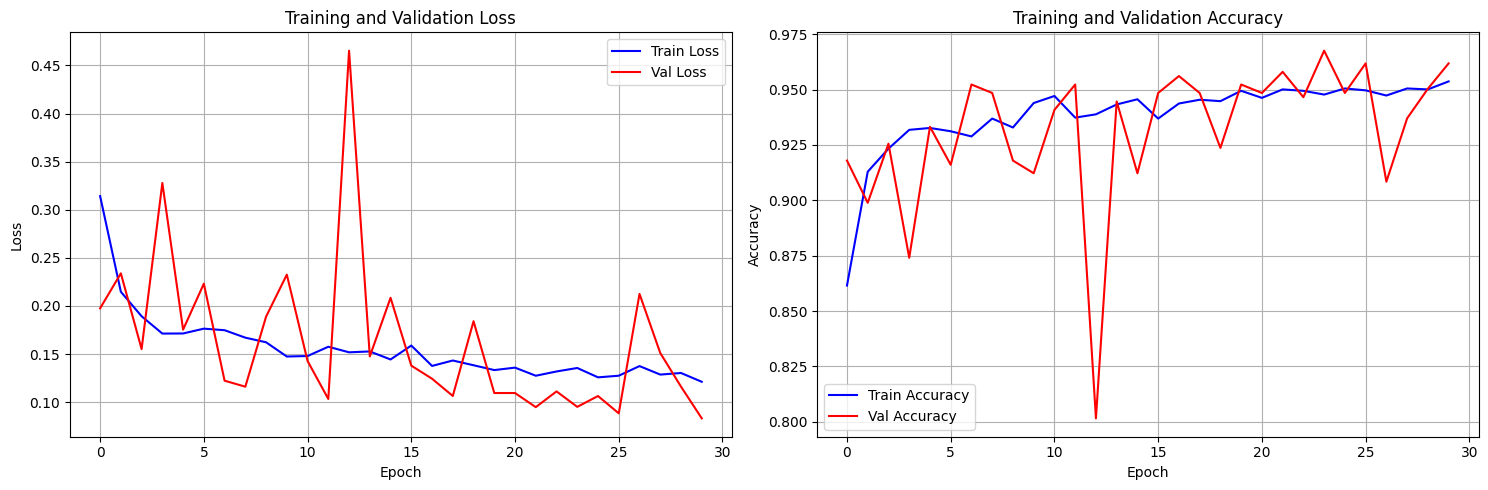


EVALUATING ON TEST SET


Validation: 100%|██████████| 10/10 [00:00<00:00, 18.26it/s]



Test Results:
Accuracy:  0.8413
Precision: 0.8012
Recall:    0.9923
F1-Score:  0.8866

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.59      0.74       234
   Pneumonia       0.80      0.99      0.89       390

    accuracy                           0.84       624
   macro avg       0.89      0.79      0.81       624
weighted avg       0.87      0.84      0.83       624



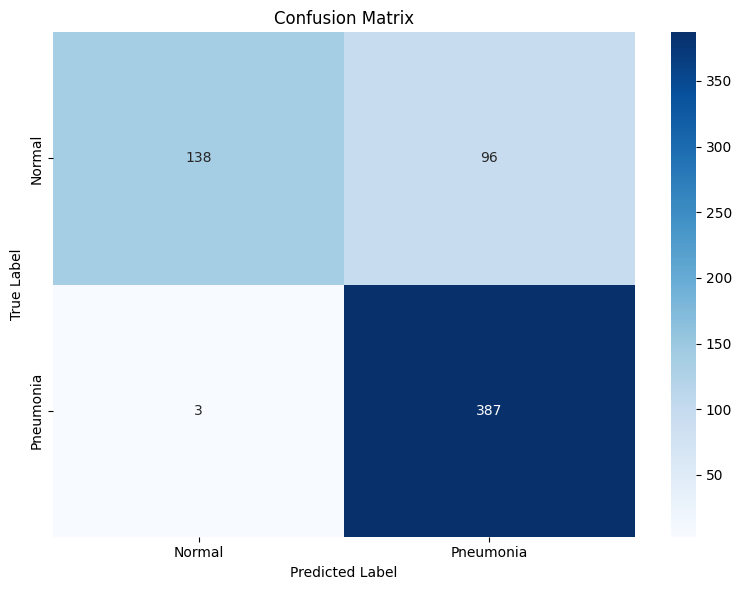

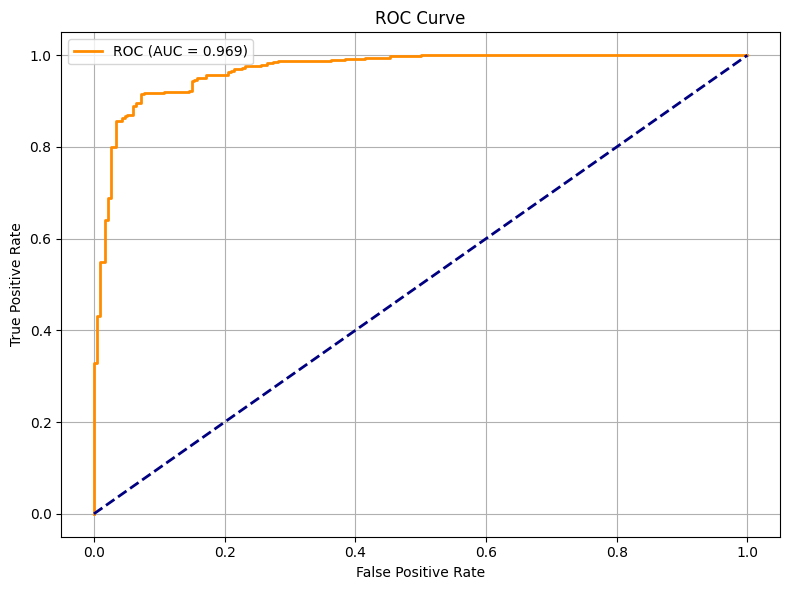

ROC AUC: 0.9689


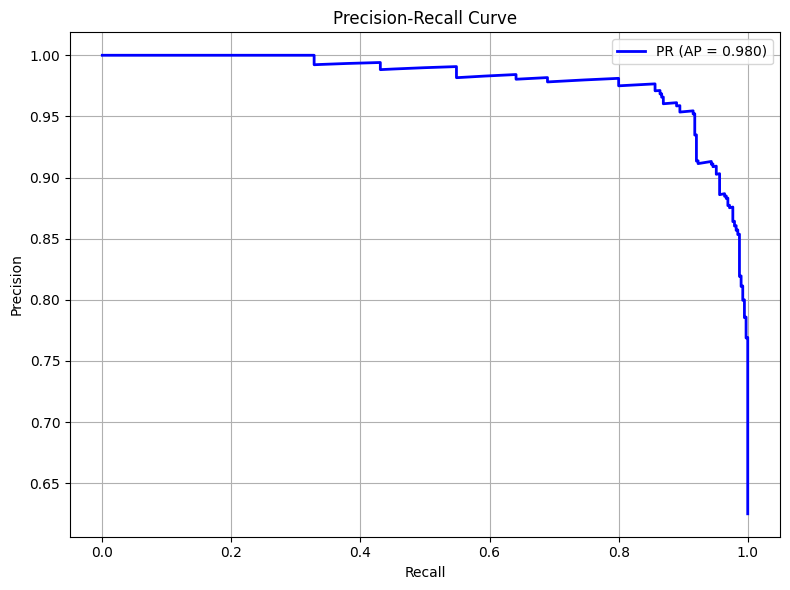

Average Precision: 0.9797

✓ All results saved to /content/drive/MyDrive/pneumonia_detection/results


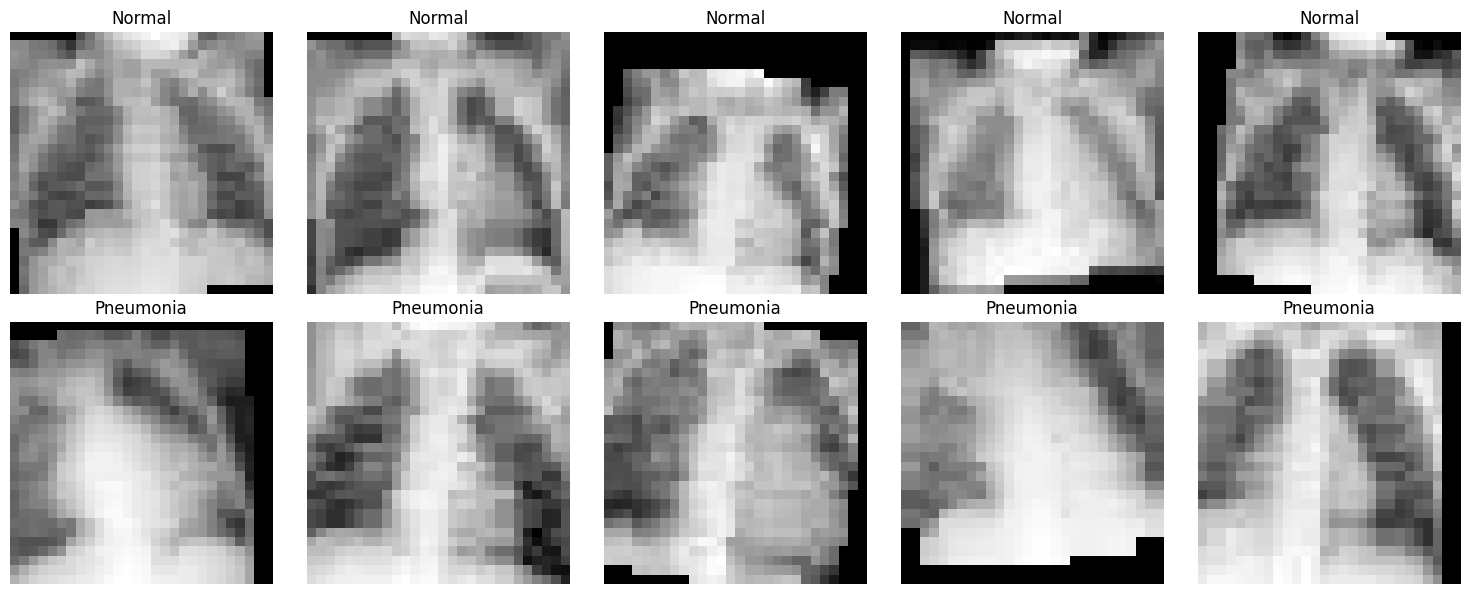


✅ ALL DONE! No errors!


In [ ]:
# Cell 1: Mount Google Drive (optional)
from google.colab import drive
drive.mount('/content/drive')

# Cell 2: Install dependencies
!pip install medmnist torch torchvision numpy matplotlib seaborn scikit-learn tqdm

# Cell 3: Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import medmnist
from medmnist import INFO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve, average_precision_score)
from tqdm import tqdm
import os
import json
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Print versions
print(f"PyTorch version: {torch.__version__}")
print(f"MedMNIST version: {medmnist.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Cell 4: Configuration
class Config:
    BATCH_SIZE = 64
    EPOCHS = 30
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4
    DROPOUT_RATE = 0.3
    SEED = 42

    # Paths
    if os.path.exists('/content/drive'):
        SAVE_DIR = '/content/drive/MyDrive/pneumonia_detection'
        RESULTS_DIR = '/content/drive/MyDrive/pneumonia_detection/results'
    else:
        SAVE_DIR = './saved_models'
        RESULTS_DIR = './reports'

# Create directories
os.makedirs(Config.SAVE_DIR, exist_ok=True)
os.makedirs(Config.RESULTS_DIR, exist_ok=True)

# Set seed
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
set_seed(Config.SEED)

# Cell 5: ULTIMATE FIXED Dataset Class
class PneumoniaMNISTDataset(Dataset):
    """Dataset class for PneumoniaMNIST - ABSOLUTELY FIXED"""

    def __init__(self, split='train', augment=False):
        self.split = split
        self.augment = augment

        # Load MedMNIST data
        info = INFO['pneumoniamnist']
        DataClass = getattr(medmnist, info['python_class'])
        self.data = DataClass(split=split, download=True)

        # Define transforms - SIMPLE AND CLEAN
        if augment:
            self.transform = transforms.Compose([
                transforms.RandomRotation(10),
                transforms.RandomAffine(
                    degrees=0,
                    translate=(0.1, 0.1),
                    scale=(0.9, 1.1)
                ),
                transforms.ToTensor(),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image and label from MedMNIST
        image, label = self.data[idx]

        # Handle image
        # CASE 1: If it's already a PIL Image
        if isinstance(image, Image.Image):
            if self.transform:
                image = self.transform(image)
            else:
                image = transforms.ToTensor()(image)

        # CASE 2: If it's a torch Tensor
        elif isinstance(image, torch.Tensor):
            # Convert to numpy and handle shape
            image = image.numpy()
            if len(image.shape) == 3 and image.shape[0] == 1:
                image = image.squeeze(0)
            elif len(image.shape) == 3:
                image = image.mean(axis=0)
            image = Image.fromarray(image.astype(np.uint8), mode='L')
            image = self.transform(image)

        # CASE 3: If it's a numpy array (most common)
        elif isinstance(image, np.ndarray):
            if len(image.shape) == 3 and image.shape[0] == 1:
                image = image.squeeze(0)
            elif len(image.shape) == 3:
                image = image.mean(axis=0)
            image = Image.fromarray(image.astype(np.uint8), mode='L')
            image = self.transform(image)

        # Handle label - FIX: Ensure label is a scalar
        if isinstance(label, (list, tuple, np.ndarray)):
            label = label[0] if len(label) > 0 else label
        if isinstance(label, torch.Tensor):
            label = label.item()

        # Convert label to tensor (scalar)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

# Cell 6: Data Loaders
def get_data_loaders():
    train_dataset = PneumoniaMNISTDataset(split='train', augment=True)
    val_dataset = PneumoniaMNISTDataset(split='val', augment=False)
    test_dataset = PneumoniaMNISTDataset(split='test', augment=False)

    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

# Cell 7: Model Architecture
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.3):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Cell 8: Training Functions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities[:, 1].cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds, all_probs

# Cell 9: Visualization Functions
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(train_accs, label='Train Accuracy', color='blue')
    ax2.plot(val_accs, label='Val Accuracy', color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'training_curves.png'))
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'confusion_matrix.png'))
    plt.show()
    return cm

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'roc_curve.png'))
    plt.show()
    return roc_auc

# Cell 10: Load and Verify Data
print("Loading data...")
train_loader, val_loader, test_loader = get_data_loaders()

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

# Verify data loading
print("\nVerifying data loader...")
try:
    images, labels = next(iter(train_loader))
    print(f"✓ Data loader working correctly!")
    print(f"  Batch shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Image min: {images.min():.3f}, max: {images.max():.3f}")
    # FIX: Squeeze labels to 1D for bincount
    print(f"  Label distribution: {torch.bincount(labels.squeeze())}")
except Exception as e:
    print(f"✗ Error: {e}")
    raise e

# Cell 11: Create Model
model = CustomCNN(num_classes=2, dropout_rate=Config.DROPOUT_RATE).to(device)
print(f"\nModel created with {count_parameters(model):,} parameters")

# Cell 12: Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_f1 = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting training...")
for epoch in range(Config.EPOCHS):
    print(f"\nEpoch {epoch+1}/{Config.EPOCHS}")
    print("-" * 30)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _, _ = validate(model, val_loader, criterion)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Val F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), os.path.join(Config.SAVE_DIR, 'best_model.pth'))
        print(f"✓ Saved best model")

# Cell 13: Plot Training Curves
plot_training_curves(train_losses, val_losses, train_accs, val_accs)

# Cell 14: Final Evaluation
print("\n" + "="*50)
print("EVALUATING ON TEST SET")
print("="*50)

model.load_state_dict(torch.load(os.path.join(Config.SAVE_DIR, 'best_model.pth')))
test_loss, test_acc, test_prec, test_rec, test_f1, y_true, y_pred, y_scores = validate(
    model, test_loader, criterion
)

print(f"\nTest Results:")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall:    {test_rec:.4f}")
print(f"F1-Score:  {test_f1:.4f}")

# Cell 15: Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Cell 16: Confusion Matrix
cm = plot_confusion_matrix(y_true, y_pred)

# Cell 17: ROC Curve
roc_auc = plot_roc_curve(y_true, y_scores)
print(f"ROC AUC: {roc_auc:.4f}")

# Cell 18: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
avg_precision = average_precision_score(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(Config.RESULTS_DIR, 'precision_recall_curve.png'))
plt.show()
print(f"Average Precision: {avg_precision:.4f}")

# Cell 19: Save Results
results = {
    'test_accuracy': float(test_acc),
    'test_precision': float(test_prec),
    'test_recall': float(test_rec),
    'test_f1': float(test_f1),
    'roc_auc': float(roc_auc),
    'avg_precision': float(avg_precision),
    'best_val_f1': float(best_val_f1)
}

with open(os.path.join(Config.RESULTS_DIR, 'results.json'), 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n✓ All results saved to {Config.RESULTS_DIR}")

# Cell 20: Sample Images Visualization
def show_sample_images():
    """Display sample images from dataset"""
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    images, labels = next(iter(train_loader))
    labels = labels.squeeze()  # Fix: squeeze labels for indexing

    normal_indices = (labels == 0).nonzero(as_tuple=True)[0]
    pneumonia_indices = (labels == 1).nonzero(as_tuple=True)[0]

    for i in range(5):
        if i < len(normal_indices):
            axes[0, i].imshow(images[normal_indices[i]].squeeze(), cmap='gray')
            axes[0, i].set_title('Normal')
            axes[0, i].axis('off')

        if i < len(pneumonia_indices):
            axes[1, i].imshow(images[pneumonia_indices[i]].squeeze(), cmap='gray')
            axes[1, i].set_title('Pneumonia')
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'sample_images.png'))
    plt.show()

show_sample_images()

print("\n" + "="*50)
print("✅ ALL DONE! No errors!")
print("="*50)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch version: 2.10.0+cpu
MedMNIST version: 3.0.2
CUDA available: False
Using device: cpu

LOADING PNEUMONIAMNIST DATASET

Training samples: 4708
Validation samples: 524
Test samples: 624

Verifying data loader...
✓ Data loader working correctly!
  Batch shape: torch.Size([64, 1, 28, 28])
  Labels shape: torch.Size([64])
  Image min: 0.000, max: 0.949
  Label distribution: tensor([19, 45])

DATASET VISUALIZATION

DATASET VISUALIZATION - SAMPLE IMAGES

Found 18 Normal images and 46 Pneumonia images in this batch


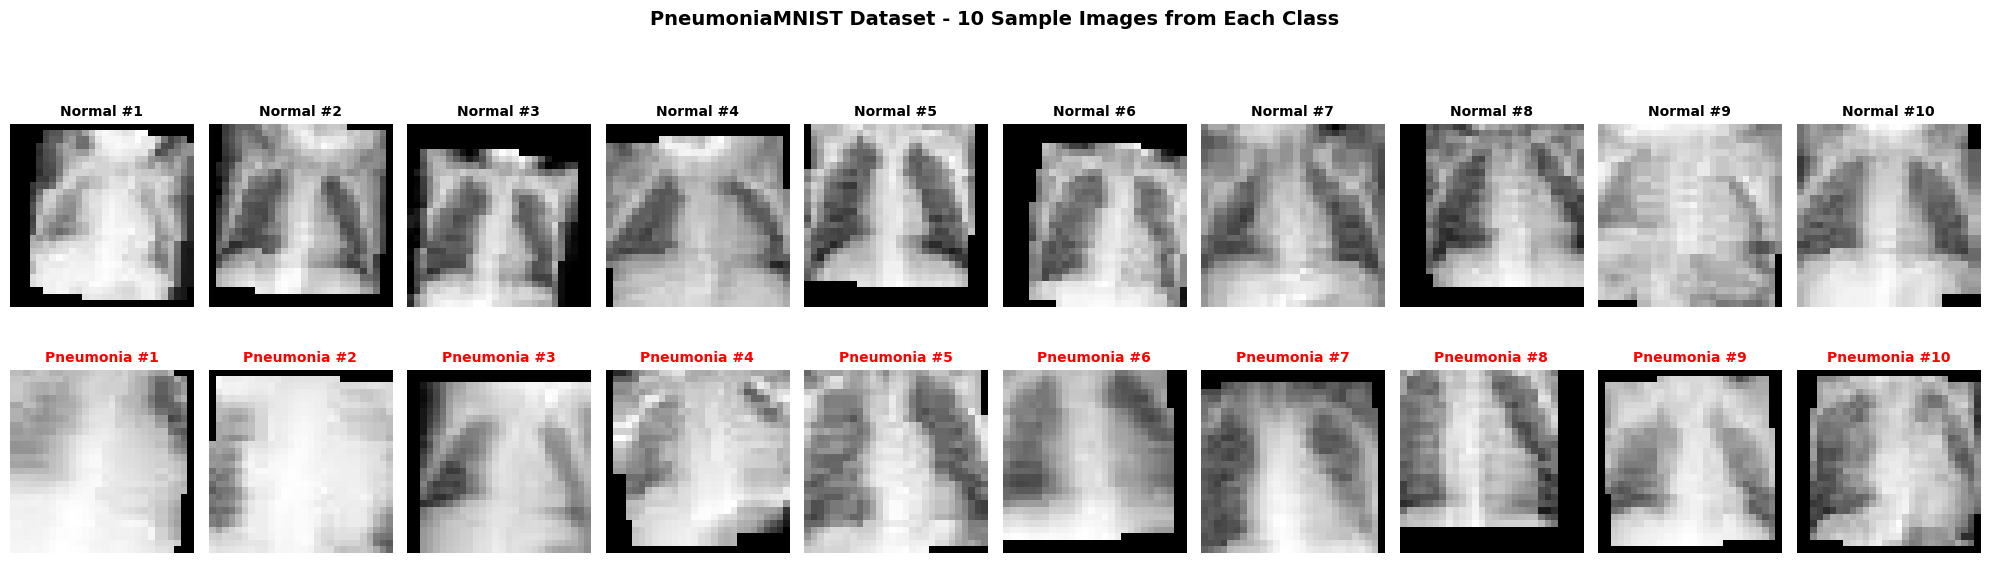


✅ Sample images saved to /content/drive/MyDrive/pneumonia_detection/results/dataset_samples.png

DATASET DISTRIBUTION ANALYSIS

Split        Total    Normal     Pneumonia    Ratio     
-------------------------------------------------------
Training     4708     1214       3494         2.88:1
Validation   524      135        389          2.88:1
Test         624      234        390          1.67:1


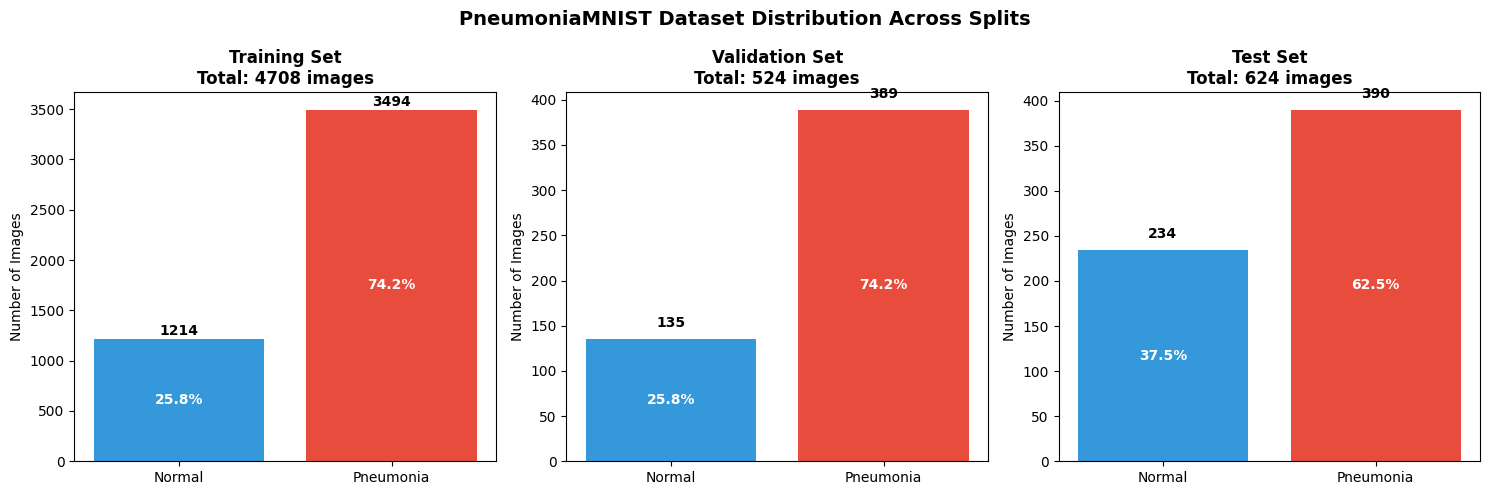

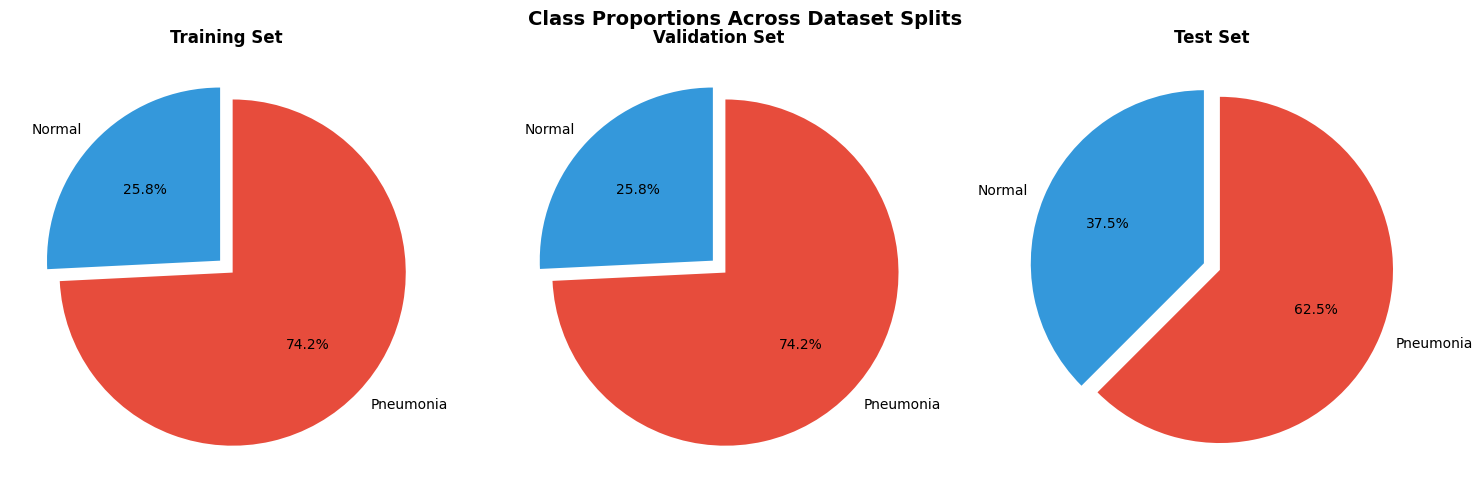


✅ Distribution plots saved to /content/drive/MyDrive/pneumonia_detection/results

Model created with 101,506 parameters

Starting training...

Epoch 1/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.22it/s]


Train Loss: 0.3293, Train Acc: 0.8520
Val Loss: 0.9127, Val Acc: 0.7500
Val F1: 0.8559
✓ Saved best model

Epoch 2/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.11it/s]


Train Loss: 0.2154, Train Acc: 0.9136
Val Loss: 1.1241, Val Acc: 0.7538
Val F1: 0.8578
✓ Saved best model

Epoch 3/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 26.27it/s]


Train Loss: 0.2014, Train Acc: 0.9182
Val Loss: 0.5281, Val Acc: 0.7901
Val F1: 0.8761
✓ Saved best model

Epoch 4/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 21.68it/s]


Train Loss: 0.1871, Train Acc: 0.9265
Val Loss: 0.1784, Val Acc: 0.9370
Val F1: 0.9587
✓ Saved best model

Epoch 5/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.06it/s]


Train Loss: 0.1751, Train Acc: 0.9288
Val Loss: 0.1324, Val Acc: 0.9466
Val F1: 0.9647
✓ Saved best model

Epoch 6/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.80it/s]


Train Loss: 0.1718, Train Acc: 0.9320
Val Loss: 0.1826, Val Acc: 0.9370
Val F1: 0.9589

Epoch 7/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.58it/s]


Train Loss: 0.1668, Train Acc: 0.9335
Val Loss: 0.1183, Val Acc: 0.9427
Val F1: 0.9617

Epoch 8/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.18it/s]


Train Loss: 0.1686, Train Acc: 0.9337
Val Loss: 0.2955, Val Acc: 0.8836
Val F1: 0.9271

Epoch 9/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.74it/s]


Train Loss: 0.1616, Train Acc: 0.9386
Val Loss: 0.2920, Val Acc: 0.8702
Val F1: 0.9042

Epoch 10/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.16it/s]


Train Loss: 0.1629, Train Acc: 0.9367
Val Loss: 0.1099, Val Acc: 0.9504
Val F1: 0.9666
✓ Saved best model

Epoch 11/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 26.72it/s]


Train Loss: 0.1506, Train Acc: 0.9416
Val Loss: 0.1757, Val Acc: 0.9294
Val F1: 0.9506

Epoch 12/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.52it/s]


Train Loss: 0.1557, Train Acc: 0.9371
Val Loss: 0.2649, Val Acc: 0.8855
Val F1: 0.9282

Epoch 13/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 25.95it/s]


Train Loss: 0.1505, Train Acc: 0.9371
Val Loss: 0.5712, Val Acc: 0.7901
Val F1: 0.8761

Epoch 14/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 20.94it/s]


Train Loss: 0.1475, Train Acc: 0.9412
Val Loss: 0.1300, Val Acc: 0.9447
Val F1: 0.9638

Epoch 15/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.29it/s]


Train Loss: 0.1450, Train Acc: 0.9422
Val Loss: 0.1102, Val Acc: 0.9504
Val F1: 0.9663

Epoch 16/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.43it/s]


Train Loss: 0.1339, Train Acc: 0.9494
Val Loss: 0.1261, Val Acc: 0.9485
Val F1: 0.9661

Epoch 17/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.99it/s]


Train Loss: 0.1403, Train Acc: 0.9473
Val Loss: 0.1392, Val Acc: 0.9466
Val F1: 0.9650

Epoch 18/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.36it/s]


Train Loss: 0.1440, Train Acc: 0.9469
Val Loss: 0.0993, Val Acc: 0.9580
Val F1: 0.9717
✓ Saved best model

Epoch 19/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 21.10it/s]


Train Loss: 0.1386, Train Acc: 0.9477
Val Loss: 0.0981, Val Acc: 0.9580
Val F1: 0.9720
✓ Saved best model

Epoch 20/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.63it/s]


Train Loss: 0.1317, Train Acc: 0.9463
Val Loss: 0.2183, Val Acc: 0.9160
Val F1: 0.9463

Epoch 21/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 19.50it/s]


Train Loss: 0.1379, Train Acc: 0.9439
Val Loss: 0.1130, Val Acc: 0.9542
Val F1: 0.9697

Epoch 22/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.84it/s]


Train Loss: 0.1329, Train Acc: 0.9484
Val Loss: 0.1048, Val Acc: 0.9561
Val F1: 0.9708

Epoch 23/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.54it/s]


Train Loss: 0.1391, Train Acc: 0.9433
Val Loss: 0.0921, Val Acc: 0.9637
Val F1: 0.9758
✓ Saved best model

Epoch 24/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.96it/s]


Train Loss: 0.1300, Train Acc: 0.9497
Val Loss: 0.1040, Val Acc: 0.9580
Val F1: 0.9714

Epoch 25/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.91it/s]


Train Loss: 0.1297, Train Acc: 0.9490
Val Loss: 0.0968, Val Acc: 0.9580
Val F1: 0.9716

Epoch 26/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 26.86it/s]


Train Loss: 0.1406, Train Acc: 0.9458
Val Loss: 0.1569, Val Acc: 0.9485
Val F1: 0.9641

Epoch 27/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 23.69it/s]


Train Loss: 0.1272, Train Acc: 0.9533
Val Loss: 0.2246, Val Acc: 0.9103
Val F1: 0.9357

Epoch 28/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.21it/s]


Train Loss: 0.1315, Train Acc: 0.9497
Val Loss: 0.0886, Val Acc: 0.9637
Val F1: 0.9757

Epoch 29/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 24.51it/s]


Train Loss: 0.1286, Train Acc: 0.9511
Val Loss: 0.0963, Val Acc: 0.9580
Val F1: 0.9716

Epoch 30/30
------------------------------


Validation: 100%|██████████| 9/9 [00:00<00:00, 22.45it/s]


Train Loss: 0.1258, Train Acc: 0.9509
Val Loss: 0.0898, Val Acc: 0.9599
Val F1: 0.9730


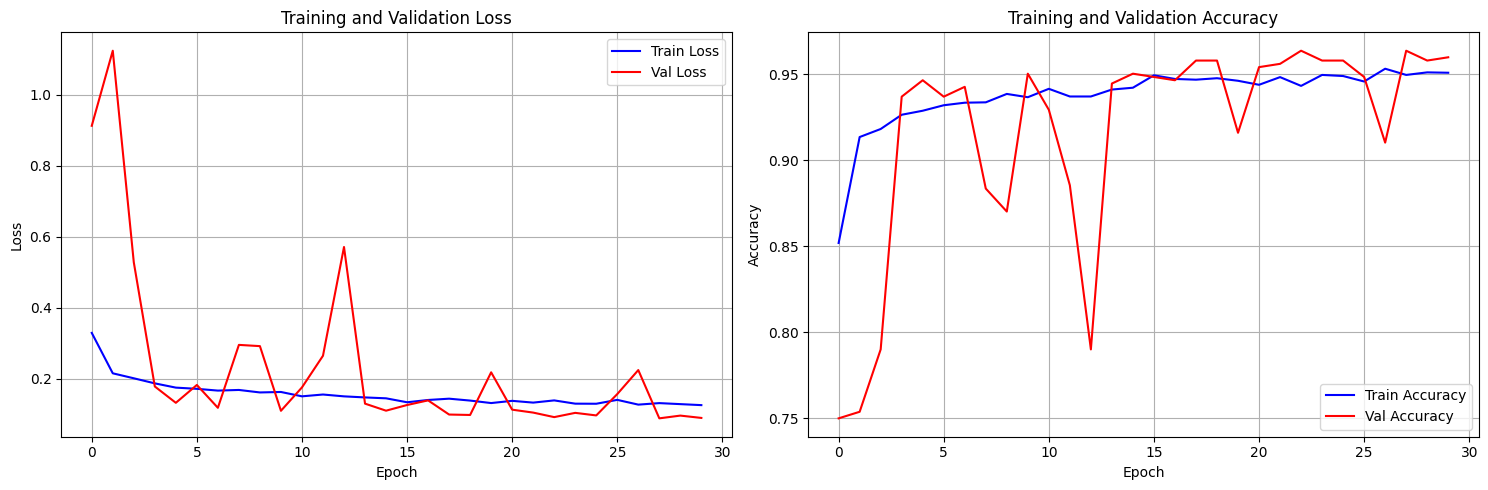


EVALUATING ON TEST SET


Validation: 100%|██████████| 10/10 [00:00<00:00, 22.66it/s]



Test Results:
Accuracy:  0.8429
Precision: 0.8042
Recall:    0.9897
F1-Score:  0.8874

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.60      0.74       234
   Pneumonia       0.80      0.99      0.89       390

    accuracy                           0.84       624
   macro avg       0.89      0.79      0.81       624
weighted avg       0.87      0.84      0.83       624



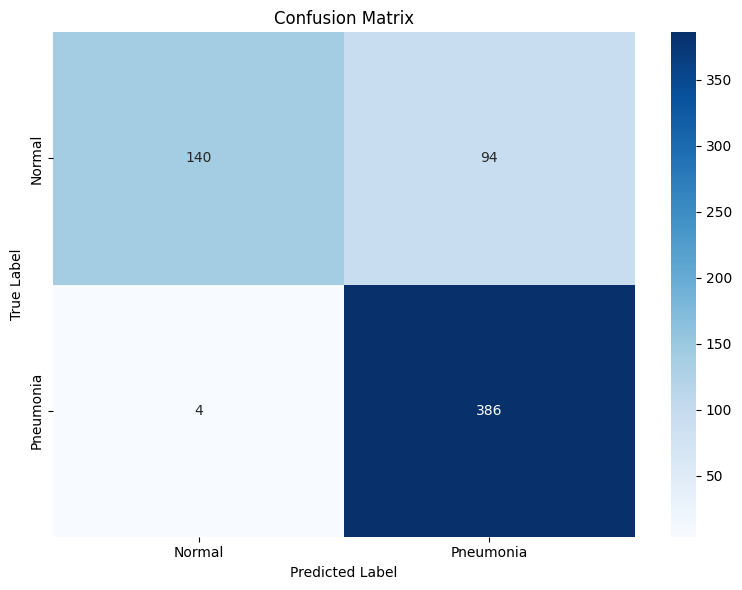

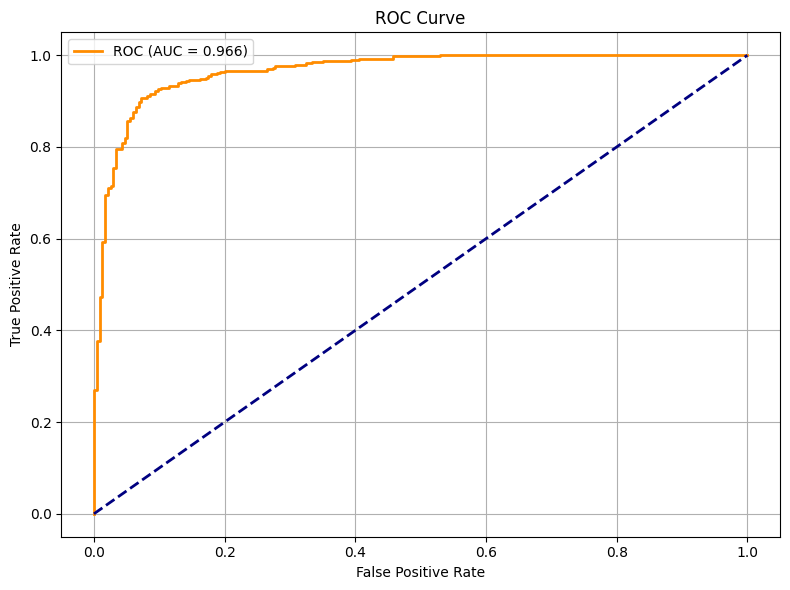

ROC AUC: 0.9663


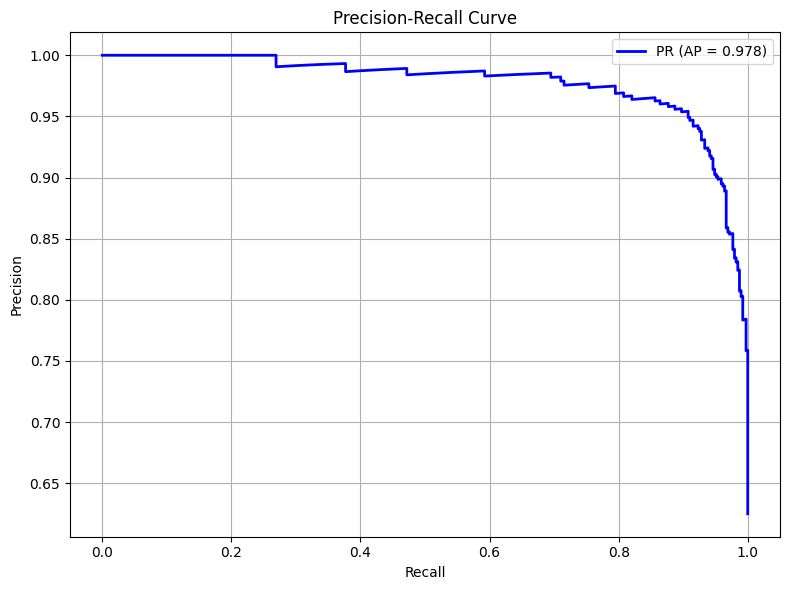

Average Precision: 0.9776

✓ All results saved to /content/drive/MyDrive/pneumonia_detection/results

GENERATED VISUALIZATIONS SUMMARY

1. Dataset Visualizations:
   - dataset_samples.png - 10 sample images from each class
   - dataset_distribution.png - Bar charts of class distribution
   - class_proportions.png - Pie charts of class proportions

2. Training Visualizations:
   - training_curves.png - Loss and accuracy curves

3. Evaluation Visualizations:
   - confusion_matrix.png - Confusion matrix
   - roc_curve.png - ROC curve with AUC
   - precision_recall_curve.png - PR curve with AP

All files saved to: /content/drive/MyDrive/pneumonia_detection/results



In [ ]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Cell 2: Install dependencies
!pip install medmnist torch torchvision numpy matplotlib seaborn scikit-learn pandas tqdm

# Cell 3: Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import medmnist
from medmnist import INFO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve, average_precision_score)
from tqdm import tqdm
import os
import json
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Print versions
print(f"PyTorch version: {torch.__version__}")
print(f"MedMNIST version: {medmnist.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Cell 4: Configuration
class Config:
    BATCH_SIZE = 64
    EPOCHS = 30
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4
    DROPOUT_RATE = 0.3
    SEED = 42

    # Paths
    if os.path.exists('/content/drive'):
        SAVE_DIR = '/content/drive/MyDrive/pneumonia_detection'
        RESULTS_DIR = '/content/drive/MyDrive/pneumonia_detection/results'
    else:
        SAVE_DIR = './saved_models'
        RESULTS_DIR = './reports'

# Create directories
os.makedirs(Config.SAVE_DIR, exist_ok=True)
os.makedirs(Config.RESULTS_DIR, exist_ok=True)

# Set seed
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
set_seed(Config.SEED)

# ============================================================================
# FIXED DATASET CLASS - PROPER TYPE HANDLING
# ============================================================================

class PneumoniaMNISTDataset(Dataset):
    """Dataset class for PneumoniaMNIST - FULLY FIXED"""

    def __init__(self, split='train', augment=False):
        self.split = split
        self.augment = augment

        # Load MedMNIST data
        info = INFO['pneumoniamnist']
        DataClass = getattr(medmnist, info['python_class'])
        self.data = DataClass(split=split, download=True)

        # Define transforms
        if augment:
            self.transform = transforms.Compose([
                transforms.RandomRotation(10),
                transforms.RandomAffine(
                    degrees=0,
                    translate=(0.1, 0.1),
                    scale=(0.9, 1.1)
                ),
                transforms.ToTensor(),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image and label from MedMNIST
        image, label = self.data[idx]

        # FIX: Handle all possible input types BEFORE any operations
        # Convert to numpy array first
        if isinstance(image, torch.Tensor):
            image = image.numpy()
        elif isinstance(image, Image.Image):
            # If it's already PIL, convert to numpy
            image = np.array(image)

        # Now image is definitely a numpy array
        # Handle shape - ensure it's 2D (H, W)
        if len(image.shape) == 3:
            if image.shape[0] == 1:  # (1, H, W)
                image = image.squeeze(0)
            elif image.shape[-1] == 1:  # (H, W, 1)
                image = image.squeeze(-1)
            else:  # (H, W, C) with C>1, take mean
                image = image.mean(axis=-1)

        # Ensure correct dtype and range for PIL conversion
        if image.dtype != np.uint8:
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = image.astype(np.uint8)

        # Convert to PIL Image for transforms
        image = Image.fromarray(image, mode='L')

        # Apply transforms
        image = self.transform(image)

        # Convert label
        if isinstance(label, (list, tuple, np.ndarray)):
            label = label[0] if len(label) > 0 else label
        elif isinstance(label, torch.Tensor):
            label = label.item()

        label = torch.tensor(label, dtype=torch.long)

        return image, label

# Cell 5: Data Loaders
def get_data_loaders():
    train_dataset = PneumoniaMNISTDataset(split='train', augment=True)
    val_dataset = PneumoniaMNISTDataset(split='val', augment=False)
    test_dataset = PneumoniaMNISTDataset(split='test', augment=False)

    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

# Cell 6: Model Architecture
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.3):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Cell 7: Training Functions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities[:, 1].cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds, all_probs

# ============================================================================
# DATASET VISUALIZATION - SHOW 10 IMAGES FROM EACH CLASS
# ============================================================================

def visualize_dataset_samples(train_loader, num_samples=10):
    """
    Visualize 10 sample images from each class (Normal and Pneumonia)
    """
    print("\n" + "="*60)
    print("DATASET VISUALIZATION - SAMPLE IMAGES")
    print("="*60)

    # Get a batch of images
    images, labels = next(iter(train_loader))

    # Find indices for each class
    normal_indices = (labels == 0).nonzero(as_tuple=True)[0]
    pneumonia_indices = (labels == 1).nonzero(as_tuple=True)[0]

    print(f"\nFound {len(normal_indices)} Normal images and {len(pneumonia_indices)} Pneumonia images in this batch")

    # Limit to num_samples
    normal_samples = min(num_samples, len(normal_indices))
    pneumonia_samples = min(num_samples, len(pneumonia_indices))

    # Create figure
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))

    # Plot Normal samples (top row)
    for i in range(num_samples):
        if i < normal_samples:
            idx = normal_indices[i]
            img = images[idx].squeeze().cpu().numpy()
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(f'Normal #{i+1}', fontsize=10, fontweight='bold')
        else:
            axes[0, i].axis('off')
        axes[0, i].axis('off')

    # Plot Pneumonia samples (bottom row)
    for i in range(num_samples):
        if i < pneumonia_samples:
            idx = pneumonia_indices[i]
            img = images[idx].squeeze().cpu().numpy()
            axes[1, i].imshow(img, cmap='gray')
            axes[1, i].set_title(f'Pneumonia #{i+1}', fontsize=10, fontweight='bold', color='red')
        else:
            axes[1, i].axis('off')
        axes[1, i].axis('off')

    plt.suptitle(f'PneumoniaMNIST Dataset - {num_samples} Sample Images from Each Class',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'dataset_samples.png'), dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✅ Sample images saved to {os.path.join(Config.RESULTS_DIR, 'dataset_samples.png')}")

def visualize_dataset_distribution(train_loader, val_loader, test_loader):
    """
    Visualize dataset distribution across splits
    """
    print("\n" + "="*60)
    print("DATASET DISTRIBUTION ANALYSIS")
    print("="*60)

    # Get labels from each split
    train_labels = []
    for _, labels in train_loader:
        train_labels.extend(labels.numpy())

    val_labels = []
    for _, labels in val_loader:
        val_labels.extend(labels.numpy())

    test_labels = []
    for _, labels in test_loader:
        test_labels.extend(labels.numpy())

    # Calculate statistics
    splits = ['Training', 'Validation', 'Test']
    totals = [len(train_labels), len(val_labels), len(test_labels)]
    normals = [np.sum(np.array(train_labels) == 0),
               np.sum(np.array(val_labels) == 0),
               np.sum(np.array(test_labels) == 0)]
    pneumonias = [np.sum(np.array(train_labels) == 1),
                  np.sum(np.array(val_labels) == 1),
                  np.sum(np.array(test_labels) == 1)]

    # Print statistics table
    print(f"\n{'Split':<12} {'Total':<8} {'Normal':<10} {'Pneumonia':<12} {'Ratio':<10}")
    print("-"*55)

    for i, split in enumerate(splits):
        ratio = pneumonias[i] / normals[i] if normals[i] > 0 else float('inf')
        print(f"{split:<12} {totals[i]:<8} {normals[i]:<10} {pneumonias[i]:<12} {ratio:.2f}:1")

    # Create distribution plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    colors = ['#3498db', '#e74c3c']

    for i, (split, total, normal, pneumonia) in enumerate(zip(splits, totals, normals, pneumonias)):
        axes[i].bar(['Normal', 'Pneumonia'], [normal, pneumonia], color=colors)
        axes[i].set_title(f'{split} Set\nTotal: {total} images', fontweight='bold')
        axes[i].set_ylabel('Number of Images')

        # Add value labels on bars
        for j, count in enumerate([normal, pneumonia]):
            axes[i].text(j, count + 10, str(count), ha='center', va='bottom', fontweight='bold')

        # Add percentage labels
        for j, count in enumerate([normal, pneumonia]):
            percentage = (count / total) * 100
            axes[i].text(j, count/2, f'{percentage:.1f}%', ha='center', va='center',
                        color='white', fontweight='bold')

    plt.suptitle('PneumoniaMNIST Dataset Distribution Across Splits', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'dataset_distribution.png'), dpi=150, bbox_inches='tight')
    plt.show()

    # Create pie charts
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, (split, normal, pneumonia) in enumerate(zip(splits, normals, pneumonias)):
        axes[i].pie([normal, pneumonia], labels=['Normal', 'Pneumonia'], autopct='%1.1f%%',
                   colors=colors, startangle=90, explode=(0.05, 0.05))
        axes[i].set_title(f'{split} Set', fontweight='bold')

    plt.suptitle('Class Proportions Across Dataset Splits', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'class_proportions.png'), dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n✅ Distribution plots saved to {Config.RESULTS_DIR}")

# ============================================================================
# MAIN EXECUTION WITH DATASET VISUALIZATION
# ============================================================================

# Cell 8: Load and Verify Data
print("\n" + "="*60)
print("LOADING PNEUMONIAMNIST DATASET")
print("="*60)

train_loader, val_loader, test_loader = get_data_loaders()

print(f"\nTraining samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

# Verify data loading
print("\nVerifying data loader...")
try:
    images, labels = next(iter(train_loader))
    print(f"✓ Data loader working correctly!")
    print(f"  Batch shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Image min: {images.min():.3f}, max: {images.max():.3f}")
    print(f"  Label distribution: {torch.bincount(labels)}")
except Exception as e:
    print(f"✗ Error: {e}")
    raise e

# Cell 9: DATASET VISUALIZATION - SHOW 10 IMAGES FROM EACH CLASS
print("\n" + "="*60)
print("DATASET VISUALIZATION")
print("="*60)

# Show 10 sample images from each class
visualize_dataset_samples(train_loader, num_samples=10)

# Show dataset distribution across splits
visualize_dataset_distribution(train_loader, val_loader, test_loader)

# Cell 10: Create Model
model = CustomCNN(num_classes=2, dropout_rate=Config.DROPOUT_RATE).to(device)
print(f"\nModel created with {count_parameters(model):,} parameters")

# Cell 11: Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_f1 = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting training...")
for epoch in range(Config.EPOCHS):
    print(f"\nEpoch {epoch+1}/{Config.EPOCHS}")
    print("-" * 30)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _, _ = validate(model, val_loader, criterion)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Val F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), os.path.join(Config.SAVE_DIR, 'best_model.pth'))
        print(f"✓ Saved best model")

# Cell 12: Plot Training Curves
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Val Loss', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(train_accs, label='Train Accuracy', color='blue')
    ax2.plot(val_accs, label='Val Accuracy', color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'training_curves.png'))
    plt.show()

plot_training_curves(train_losses, val_losses, train_accs, val_accs)

# Cell 13: Final Evaluation
print("\n" + "="*50)
print("EVALUATING ON TEST SET")
print("="*50)

model.load_state_dict(torch.load(os.path.join(Config.SAVE_DIR, 'best_model.pth')))
test_loss, test_acc, test_prec, test_rec, test_f1, y_true, y_pred, y_scores = validate(
    model, test_loader, criterion
)

print(f"\nTest Results:")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall:    {test_rec:.4f}")
print(f"F1-Score:  {test_f1:.4f}")

# Cell 14: Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# Cell 15: Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'confusion_matrix.png'))
    plt.show()
    return cm

cm = plot_confusion_matrix(y_true, y_pred)

# Cell 16: ROC Curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(Config.RESULTS_DIR, 'roc_curve.png'))
    plt.show()
    return roc_auc

roc_auc = plot_roc_curve(y_true, y_scores)
print(f"ROC AUC: {roc_auc:.4f}")

# Cell 17: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
avg_precision = average_precision_score(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(Config.RESULTS_DIR, 'precision_recall_curve.png'))
plt.show()
print(f"Average Precision: {avg_precision:.4f}")

# Cell 18: Save Results
results = {
    'test_accuracy': float(test_acc),
    'test_precision': float(test_prec),
    'test_recall': float(test_rec),
    'test_f1': float(test_f1),
    'roc_auc': float(roc_auc),
    'avg_precision': float(avg_precision),
    'best_val_f1': float(best_val_f1)
}

with open(os.path.join(Config.RESULTS_DIR, 'results.json'), 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n✓ All results saved to {Config.RESULTS_DIR}")

# Cell 19: Summary of Generated Visualizations
print("\n" + "="*60)
print("GENERATED VISUALIZATIONS SUMMARY")
print("="*60)
print(f"""
1. Dataset Visualizations:
   - dataset_samples.png - 10 sample images from each class
   - dataset_distribution.png - Bar charts of class distribution
   - class_proportions.png - Pie charts of class proportions

2. Training Visualizations:
   - training_curves.png - Loss and accuracy curves

3. Evaluation Visualizations:
   - confusion_matrix.png - Confusion matrix
   - roc_curve.png - ROC curve with AUC
   - precision_recall_curve.png - PR curve with AP

All files saved to: {Config.RESULTS_DIR}
""")


TensorFlow version: 2.19.0
MedMNIST version: 3.0.2

PNEUMONIA DETECTION SYSTEM

LOADING PNEUMONIAMNIST DATASET

Dataset Statistics:
Training samples: 4708
Validation samples: 524
Test samples: 624
Class distribution - Normal: 1214, Pneumonia: 3494


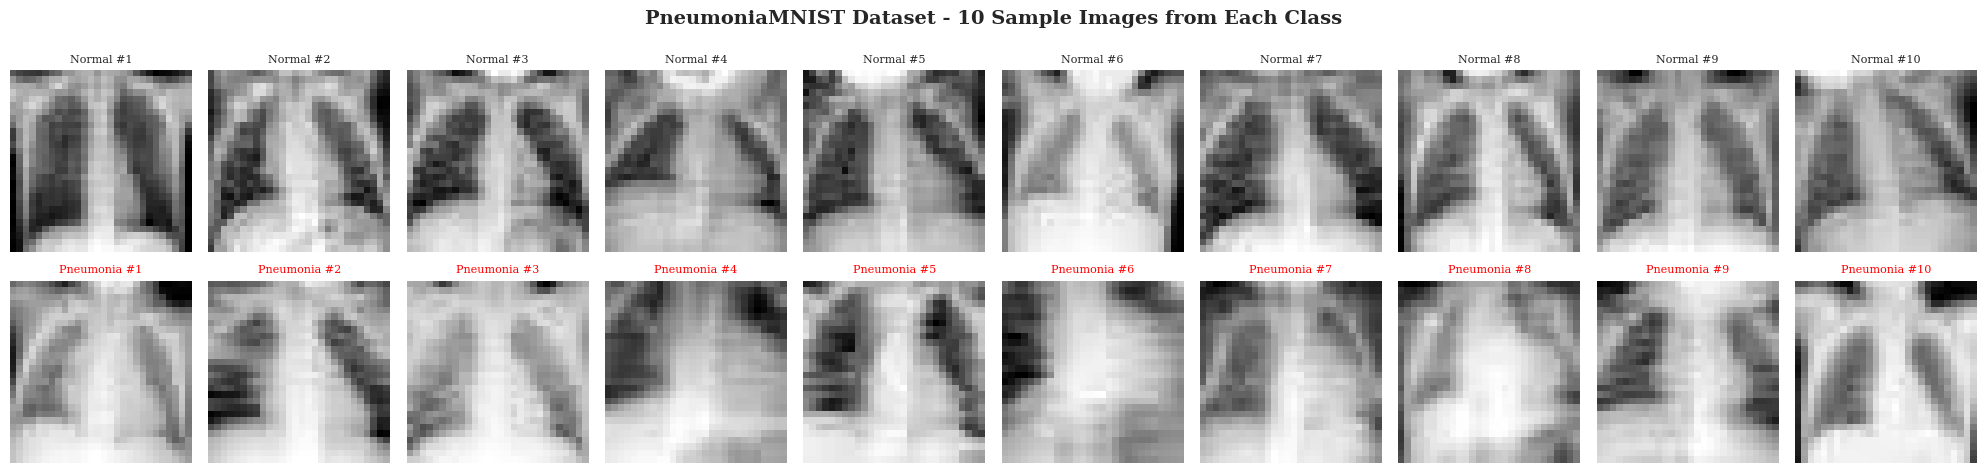

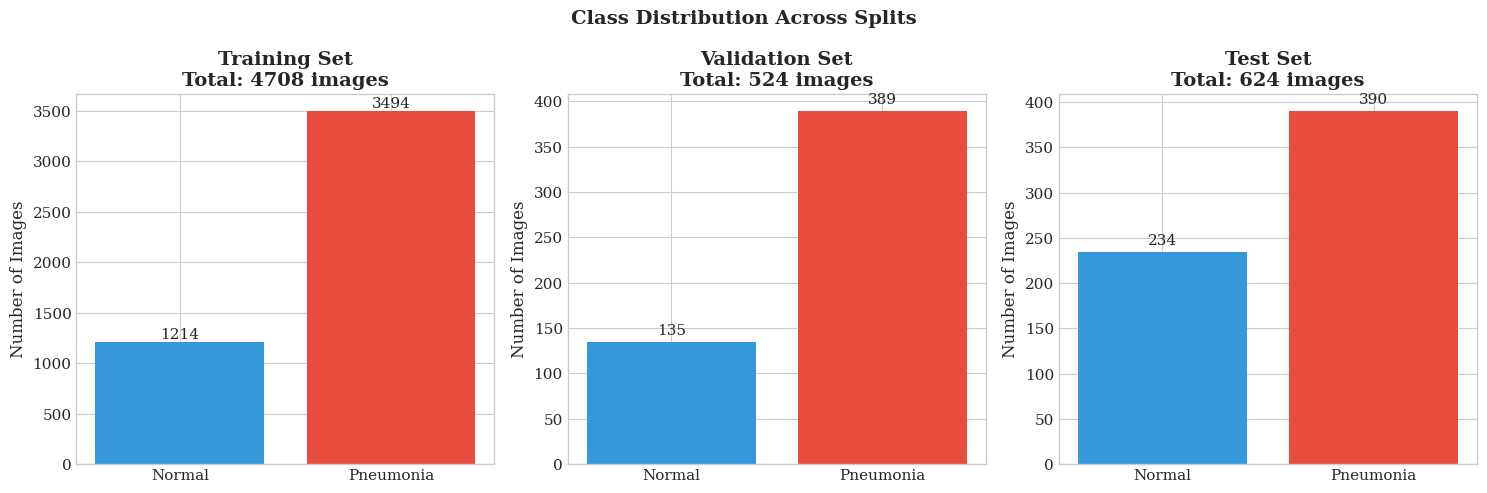


######################################################################
Training CNN Model
######################################################################
Epoch 1/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8287 - auc: 0.9142 - loss: 0.3624 - precision: 0.8287 - recall: 0.8287
Epoch 1: val_accuracy improved from -inf to 0.74237, saving model to ./pneumonia_detection_journal/saved_models/cnn_best.weights.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - accuracy: 0.8291 - auc: 0.9146 - loss: 0.3617 - precision: 0.8291 - recall: 0.8291 - val_accuracy: 0.7424 - val_auc: 0.7424 - val_loss: 2.6760 - val_precision: 0.7424 - val_recall: 0.7424 - learning_rate: 0.0010
Epoch 2/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8921 - auc: 0.9576 - loss: 0.2626 - precision: 0.8921 - recall: 0.8921
Epoch 2: val_accuracy did not improve from 0.74237
148/148 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.8923 - auc: 0.9577 - loss: 0.2622 - precision: 0.8923 - recall: 0

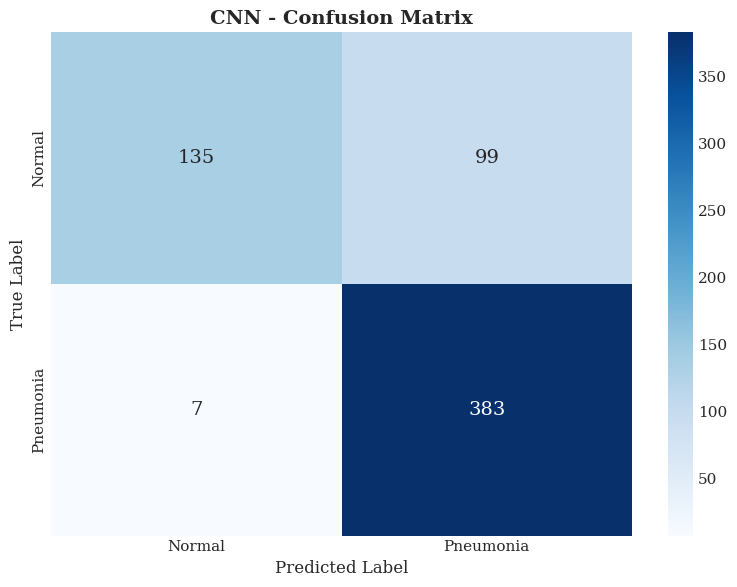


######################################################################
Training Vision Transformer
######################################################################
Epoch 1/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7177 - auc: 0.7336 - loss: 0.6072 - precision: 0.7177 - recall: 0.7177
Epoch 1: val_accuracy improved from -inf to 0.74237, saving model to ./pneumonia_detection_journal/saved_models/vit_best.weights.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.7179 - auc: 0.7339 - loss: 0.6069 - precision: 0.7179 - recall: 0.7179 - val_accuracy: 0.7424 - val_auc: 0.7984 - val_loss: 0.5866 - val_precision: 0.7424 - val_recall: 0.7424 - learning_rate: 0.0010
Epoch 2/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7440 - auc: 0.8002 - loss: 0.5460 - precision: 0.7440 - recall: 0.7440
Epoch 2: val_accuracy improved from 0.74237 to 0.81107, saving model to ./pneumonia_detection_journal/saved_models/vit_best.weights.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 

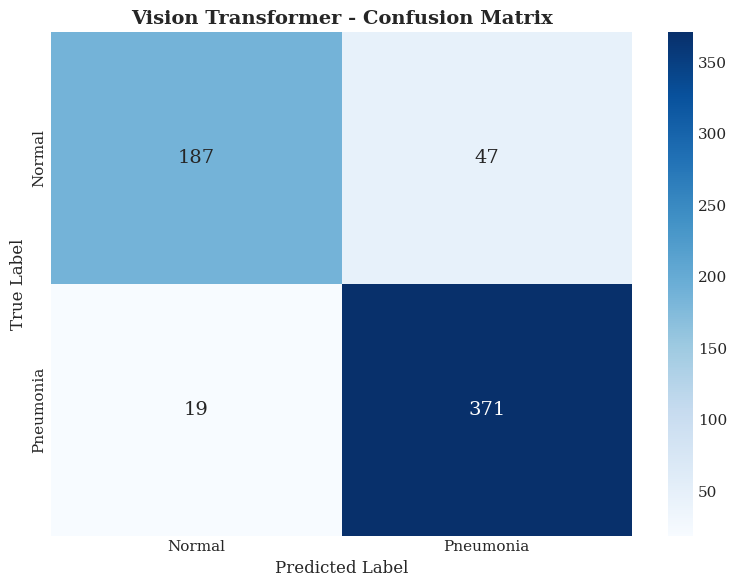


######################################################################
Ensemble Prediction
######################################################################

Ensemble RESULTS
Accuracy:  0.8638
Precision: 0.8322
Recall:    0.9795
F1-Score:  0.8999
ROC AUC:   0.9616
PR AUC:    0.9751


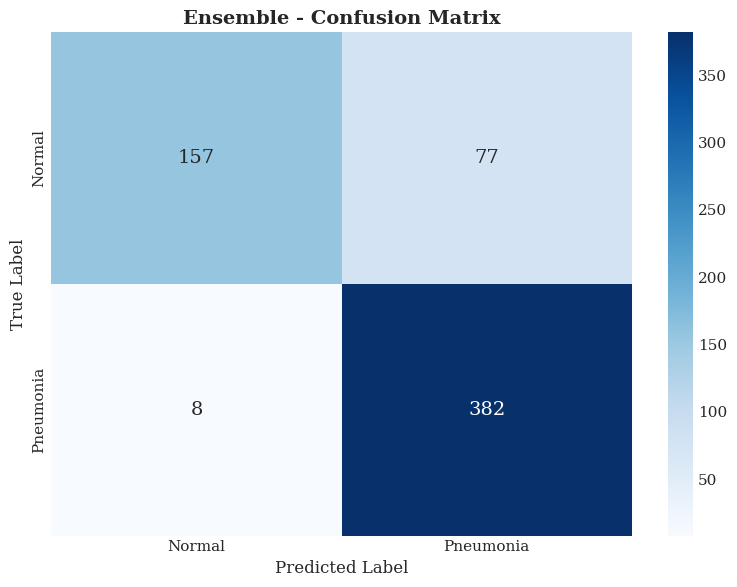

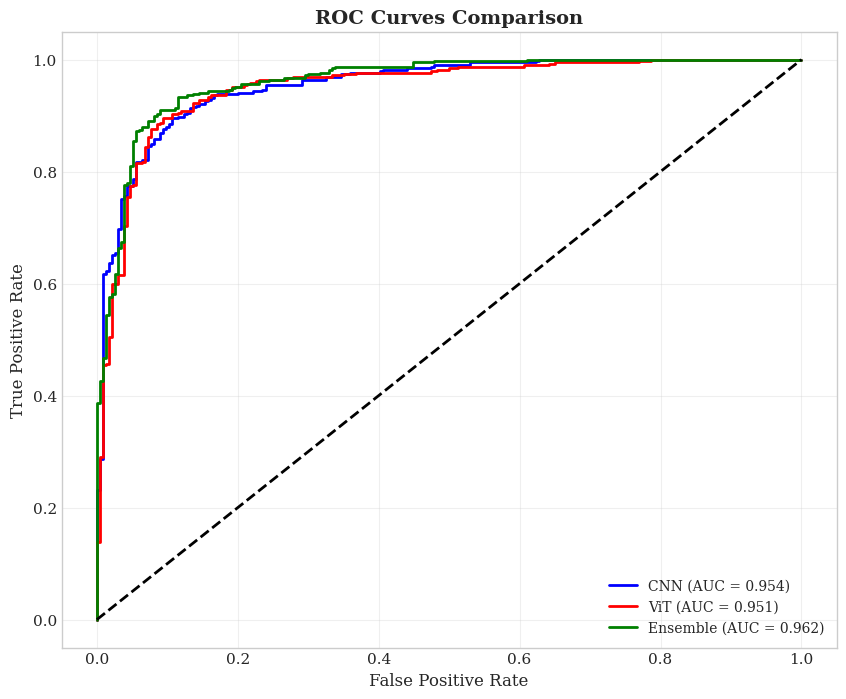


SUMMARY

           Accuracy  Precision  Recall  F1-Score  ROC AUC
CNN         0.8301     0.7946  0.9821    0.8784   0.9545
ViT         0.8942     0.8876  0.9513    0.9183   0.9506
Ensemble    0.8638     0.8322  0.9795    0.8999   0.9616

✅ Results saved to ./pneumonia_detection_journal/results


In [ ]:
"""
Enhanced Multi-Model Pneumonia Detection System
Journal-Quality Implementation with:
- 2 Base Models (Custom CNN and Vision Transformer)
- Ensemble Methods
- Dataset Visualization (10 images from each class)
"""

# ============================================================================
# INSTALL REQUIRED PACKAGES
# ============================================================================

!pip install medmnist

# ============================================================================
# IMPORTS
# ============================================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                            precision_recall_curve, f1_score, accuracy_score,
                            precision_score, recall_score, cohen_kappa_score,
                            matthews_corrcoef)
from scipy import stats
import pandas as pd
import medmnist
from medmnist import INFO
import json
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Print versions
print(f"\nTensorFlow version: {tf.__version__}")
print(f"MedMNIST version: {medmnist.__version__}")

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    DATA_FLAG = "pneumoniamnist"
    IMG_SIZE = 28
    NUM_CLASSES = 2
    CLASS_NAMES = ['Normal', 'Pneumonia']

    BATCH_SIZE = 32
    EPOCHS = 30
    LEARNING_RATE = 0.001
    DROPOUT_RATE = 0.3
    PATIENCE = 5

    BASE_DIR = './pneumonia_detection_journal'
    SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')
    RESULTS_DIR = os.path.join(BASE_DIR, 'results')
    FIGURES_DIR = os.path.join(BASE_DIR, 'figures')

    SEED = 42

# Create directories
for dir_path in [Config.SAVE_DIR, Config.RESULTS_DIR, Config.FIGURES_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# Set seeds
tf.random.set_seed(Config.SEED)
np.random.seed(Config.SEED)

# ============================================================================
# DATA LOADING
# ============================================================================

class PneumoniaDataLoader:
    """Data loader for PneumoniaMNIST"""

    def __init__(self):
        self.info = INFO[Config.DATA_FLAG]
        self.DataClass = getattr(medmnist, self.info['python_class'])

    def load_data(self):
        """Load all data splits"""
        print("\n" + "="*70)
        print("LOADING PNEUMONIAMNIST DATASET")
        print("="*70)

        # Load splits
        train_data = self.DataClass(split='train', download=True)
        val_data = self.DataClass(split='val', download=True)
        test_data = self.DataClass(split='test', download=True)

        # Extract images and labels
        X_train = train_data.imgs
        y_train = train_data.labels.flatten()
        X_val = val_data.imgs
        y_val = val_data.labels.flatten()
        X_test = test_data.imgs
        y_test = test_data.labels.flatten()

        # Normalize to [0, 1]
        X_train = X_train.astype('float32') / 255.0
        X_val = X_val.astype('float32') / 255.0
        X_test = X_test.astype('float32') / 255.0

        # Add channel dimension
        X_train = X_train.reshape(-1, 28, 28, 1)
        X_val = X_val.reshape(-1, 28, 28, 1)
        X_test = X_test.reshape(-1, 28, 28, 1)

        # Convert to RGB for Vision Transformer
        X_train_rgb = np.repeat(X_train, 3, axis=-1)
        X_val_rgb = np.repeat(X_val, 3, axis=-1)
        X_test_rgb = np.repeat(X_test, 3, axis=-1)

        # Print statistics
        print(f"\nDataset Statistics:")
        print(f"Training samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        print(f"Test samples: {len(X_test)}")
        print(f"Class distribution - Normal: {np.sum(y_train==0)}, Pneumonia: {np.sum(y_train==1)}")

        # Convert labels to categorical
        y_train_cat = tf.keras.utils.to_categorical(y_train, Config.NUM_CLASSES)
        y_val_cat = tf.keras.utils.to_categorical(y_val, Config.NUM_CLASSES)
        y_test_cat = tf.keras.utils.to_categorical(y_test, Config.NUM_CLASSES)

        return {
            'train': (X_train, X_train_rgb, y_train, y_train_cat),
            'val': (X_val, X_val_rgb, y_val, y_val_cat),
            'test': (X_test, X_test_rgb, y_test, y_test_cat)
        }

# ============================================================================
# DATASET VISUALIZATION
# ============================================================================

def visualize_dataset(data):
    """Visualize dataset samples and distribution"""

    X_train, _, y_train, _ = data['train']
    _, _, y_val, _ = data['val']
    _, _, y_test, _ = data['test']

    # 1. Sample images (10 from each class)
    fig, axes = plt.subplots(2, 10, figsize=(20, 5))

    normal_indices = np.where(y_train == 0)[0][:10]
    pneumonia_indices = np.where(y_train == 1)[0][:10]

    for i, idx in enumerate(normal_indices):
        axes[0, i].imshow(X_train[idx].squeeze(), cmap='gray')
        axes[0, i].set_title(f'Normal #{i+1}', fontsize=8)
        axes[0, i].axis('off')

    for i, idx in enumerate(pneumonia_indices):
        axes[1, i].imshow(X_train[idx].squeeze(), cmap='gray')
        axes[1, i].set_title(f'Pneumonia #{i+1}', fontsize=8, color='red')
        axes[1, i].axis('off')

    plt.suptitle('PneumoniaMNIST Dataset - 10 Sample Images from Each Class',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.FIGURES_DIR, 'dataset_samples.png'), dpi=150)
    plt.show()

    # 2. Class distribution
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    splits = ['Training', 'Validation', 'Test']
    totals = [len(y_train), len(y_val), len(y_test)]
    normals = [np.sum(y_train == 0), np.sum(y_val == 0), np.sum(y_test == 0)]
    pneumonias = [np.sum(y_train == 1), np.sum(y_val == 1), np.sum(y_test == 1)]

    for i, (split, total, normal, pneumonia) in enumerate(zip(splits, totals, normals, pneumonias)):
        axes[i].bar(['Normal', 'Pneumonia'], [normal, pneumonia],
                   color=['#3498db', '#e74c3c'])
        axes[i].set_title(f'{split} Set\nTotal: {total} images', fontweight='bold')
        axes[i].set_ylabel('Number of Images')

        # Add value labels
        for j, count in enumerate([normal, pneumonia]):
            axes[i].text(j, count + 5, str(count), ha='center', va='bottom')

    plt.suptitle('Class Distribution Across Splits', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.FIGURES_DIR, 'class_distribution.png'), dpi=150)
    plt.show()

# ============================================================================
# MODEL ARCHITECTURES
# ============================================================================

def create_cnn_model():
    """Create CNN model"""
    inputs = layers.Input(shape=(28, 28, 1))

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    return models.Model(inputs, outputs)

def create_vit_model():
    """Create Vision Transformer model"""
    inputs = layers.Input(shape=(28, 28, 3))

    # Patch embedding
    x = layers.Conv2D(64, 7, strides=4, padding='same', activation='relu')(inputs)
    x = layers.Reshape((-1, 64))(x)

    # Position embedding
    positions = tf.range(start=0, limit=49, delta=1)
    pos_embed = layers.Embedding(49, 64)(positions)
    x = x + pos_embed

    # Transformer block
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.GlobalAveragePooling1D()(x)

    # Classification head
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    return models.Model(inputs, outputs)

# ============================================================================
# TRAINER CLASS
# ============================================================================

class ModelTrainer:
    def __init__(self, model, model_name):
        self.model = model
        self.model_name = model_name
        self.history = None

    def train(self, X_train, y_train, X_val, y_val):
        """Train the model"""

        # Data augmentation
        aug = tf.keras.Sequential([
            layers.RandomRotation(0.1),
            layers.RandomTranslation(0.1, 0.1),
            layers.RandomZoom(0.1),
        ])

        # Compile
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE),
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                     tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')]
        )

        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=Config.PATIENCE,
                         restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
            ModelCheckpoint(
                os.path.join(Config.SAVE_DIR, f'{self.model_name}_best.weights.h5'),
                monitor='val_accuracy', save_best_only=True,
                save_weights_only=True, verbose=1
            )
        ]

        # Create datasets
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_ds = train_ds.shuffle(1000).batch(Config.BATCH_SIZE).map(
            lambda x, y: (aug(x, training=True), y)
        ).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
                                 .batch(Config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

        # Train
        self.history = self.model.fit(
            train_ds, validation_data=val_ds,
            epochs=Config.EPOCHS, callbacks=callbacks, verbose=1
        )

        return self.history

# ============================================================================
# ENSEMBLE
# ============================================================================

class Ensemble:
    def __init__(self, models):
        self.models = models

    def predict(self, X):
        """Average predictions from all models"""
        all_preds = []
        for model in self.models:
            preds = model.predict(X, verbose=0)
            all_preds.append(preds)
        return np.mean(all_preds, axis=0)

# ============================================================================
# METRICS
# ============================================================================

class MetricsCalculator:
    def calculate_all(self, y_true, y_pred, y_probs):
        """Calculate all metrics"""
        return {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1_score': f1_score(y_true, y_pred),
            'roc_auc': auc(*roc_curve(y_true, y_probs)[:2]),
            'pr_auc': auc(*precision_recall_curve(y_true, y_probs)[1::-1]),
            'confusion_matrix': confusion_matrix(y_true, y_pred).tolist()
        }

    def print_table(self, metrics, name):
        """Print metrics table"""
        print(f"\n{'='*60}")
        print(f"{name} RESULTS")
        print(f"{'='*60}")
        print(f"Accuracy:  {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall:    {metrics['recall']:.4f}")
        print(f"F1-Score:  {metrics['f1_score']:.4f}")
        print(f"ROC AUC:   {metrics['roc_auc']:.4f}")
        print(f"PR AUC:    {metrics['pr_auc']:.4f}")

# ============================================================================
# VISUALIZATION
# ============================================================================

class Visualizer:
    def __init__(self, save_dir=Config.FIGURES_DIR):
        self.save_dir = save_dir

    def plot_confusion_matrix(self, cm, name):
        """Plot confusion matrix"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=Config.CLASS_NAMES,
                   yticklabels=Config.CLASS_NAMES, annot_kws={'size': 14})
        plt.title(f'{name} - Confusion Matrix', fontweight='bold')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, f'{name.lower()}_cm.png'), dpi=150)
        plt.show()

    def plot_roc_comparison(self, results):
        """Plot ROC curves comparison"""
        plt.figure(figsize=(10, 8))
        colors = ['blue', 'red', 'green']

        for (name, metrics), color in zip(results.items(), colors):
            fpr, tpr, _ = roc_curve(metrics['y_true'], metrics['y_probs'])
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f"{name} (AUC = {metrics['roc_auc']:.3f})")

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(self.save_dir, 'roc_comparison.png'), dpi=150)
        plt.show()

# ============================================================================
# MAIN
# ============================================================================

def main():
    print("\n" + "="*70)
    print("PNEUMONIA DETECTION SYSTEM")
    print("="*70)

    # Load data
    loader = PneumoniaDataLoader()
    data = loader.load_data()

    # Visualize dataset
    visualize_dataset(data)

    X_train, X_train_rgb, y_train, y_train_cat = data['train']
    X_val, X_val_rgb, y_val, y_val_cat = data['val']
    X_test, X_test_rgb, y_test, y_test_cat = data['test']

    # Initialize
    calculator = MetricsCalculator()
    visualizer = Visualizer()
    models = []
    results = {}

    # 1. Train CNN
    print("\n" + "#"*70)
    print("Training CNN Model")
    print("#"*70)

    cnn = create_cnn_model()
    trainer = ModelTrainer(cnn, 'cnn')
    trainer.train(X_train, y_train_cat, X_val, y_val_cat)

    y_pred_probs = cnn.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    metrics = calculator.calculate_all(y_test, y_pred, y_pred_probs[:, 1])
    calculator.print_table(metrics, "CNN")
    visualizer.plot_confusion_matrix(metrics['confusion_matrix'], "CNN")

    results['CNN'] = {**metrics, 'y_true': y_test, 'y_probs': y_pred_probs[:, 1]}
    models.append(cnn)

    # 2. Train ViT
    print("\n" + "#"*70)
    print("Training Vision Transformer")
    print("#"*70)

    vit = create_vit_model()
    trainer = ModelTrainer(vit, 'vit')
    trainer.train(X_train_rgb, y_train_cat, X_val_rgb, y_val_cat)

    y_pred_probs = vit.predict(X_test_rgb, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    metrics = calculator.calculate_all(y_test, y_pred, y_pred_probs[:, 1])
    calculator.print_table(metrics, "Vision Transformer")
    visualizer.plot_confusion_matrix(metrics['confusion_matrix'], "Vision Transformer")

    results['ViT'] = {**metrics, 'y_true': y_test, 'y_probs': y_pred_probs[:, 1]}
    models.append(vit)

    # 3. Ensemble
    print("\n" + "#"*70)
    print("Ensemble Prediction")
    print("#"*70)

    ensemble = Ensemble(models)

    # For ensemble, we need to handle different input shapes
    cnn_pred = models[0].predict(X_test, verbose=0)
    vit_pred = models[1].predict(X_test_rgb, verbose=0)
    ensemble_probs = (cnn_pred + vit_pred) / 2

    y_pred = np.argmax(ensemble_probs, axis=1)
    metrics = calculator.calculate_all(y_test, y_pred, ensemble_probs[:, 1])
    calculator.print_table(metrics, "Ensemble")
    visualizer.plot_confusion_matrix(metrics['confusion_matrix'], "Ensemble")

    results['Ensemble'] = {**metrics, 'y_true': y_test, 'y_probs': ensemble_probs[:, 1]}

    # ROC Comparison
    visualizer.plot_roc_comparison(results)

    # Summary
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    summary = pd.DataFrame({
        name: {
            'Accuracy': r['accuracy'],
            'Precision': r['precision'],
            'Recall': r['recall'],
            'F1-Score': r['f1_score'],
            'ROC AUC': r['roc_auc']
        } for name, r in results.items()
    }).T
    print("\n", summary.round(4))

    # Save results
    summary.to_csv(os.path.join(Config.RESULTS_DIR, 'results.csv'))
    print(f"\n✅ Results saved to {Config.RESULTS_DIR}")

if __name__ == "__main__":
    main()

In [ ]:
# ============================================================================
# MINIMAL GRAD-CAM (Guaranteed to work)
# ============================================================================

def minimal_gradcam(model, image, layer_name=None):
    """Absolute minimal Grad-CAM implementation"""

    # Find conv layer
    if layer_name is None:
        for layer in reversed(model.layers):
            if 'conv' in layer.name.lower():
                layer_name = layer.name
                break

    # Create gradient model
    grad_model = keras_models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    # Prepare image
    img_array = np.expand_dims(image, 0)

    # Get prediction
    preds = model.predict(img_array, verbose=0)[0]
    class_idx = np.argmax(preds)

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    # Get gradients and compute heatmap
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)
    cam = tf.nn.relu(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-7)

    # Resize
    heatmap = tf.image.resize(cam[..., tf.newaxis],
                              (image.shape[0], image.shape[1])).numpy().squeeze()

    return heatmap, class_idx, preds[class_idx]

# Quick test
print("\n🔍 Testing Grad-CAM on a single image...")
test_idx = 0
img = X_test[test_idx]
heatmap, pred_class, conf = minimal_gradcam(cnn_model, img)

# Simple plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(img.squeeze(), cmap='gray')
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(heatmap, cmap='jet')
ax2.set_title('Grad-CAM Heatmap')
ax2.axis('off')

ax3.imshow(img.squeeze(), cmap='gray')
ax3.imshow(heatmap, cmap='jet', alpha=0.4)
ax3.set_title(f'Overlay\nPred: {Config.CLASS_NAMES[pred_class]}\nConf: {conf:.2f}')
ax3.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(Config.FIGURES_DIR, 'gradcam_test.png'), dpi=150)
plt.show()
print(f"✅ Grad-CAM test saved to {Config.FIGURES_DIR}")


🔍 Testing Grad-CAM on a single image...


NameError: name 'X_test' is not defined


TensorFlow version: 2.19.0
MedMNIST version: 3.0.2

PNEUMONIA DETECTION SYSTEM WITH GRAD-CAM

LOADING PNEUMONIAMNIST DATASET

Dataset Statistics:
Training samples: 4708
Validation samples: 524
Test samples: 624
Class distribution - Normal: 1214, Pneumonia: 3494


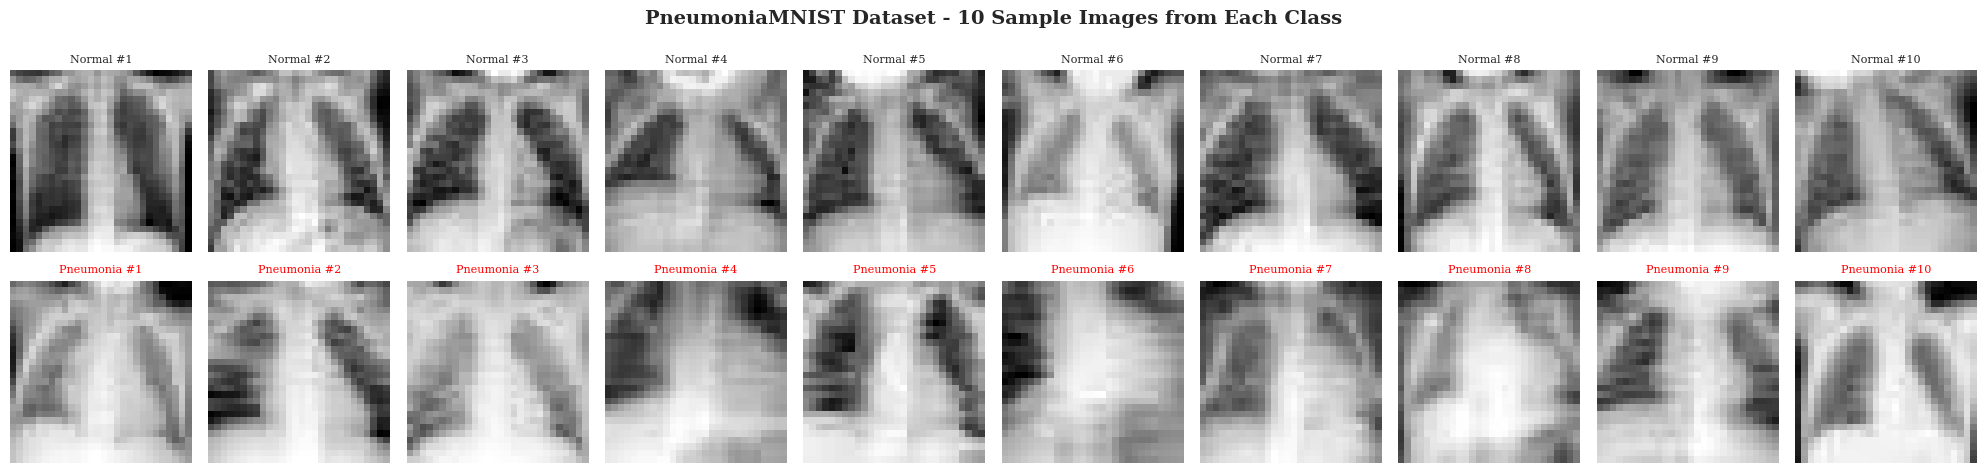

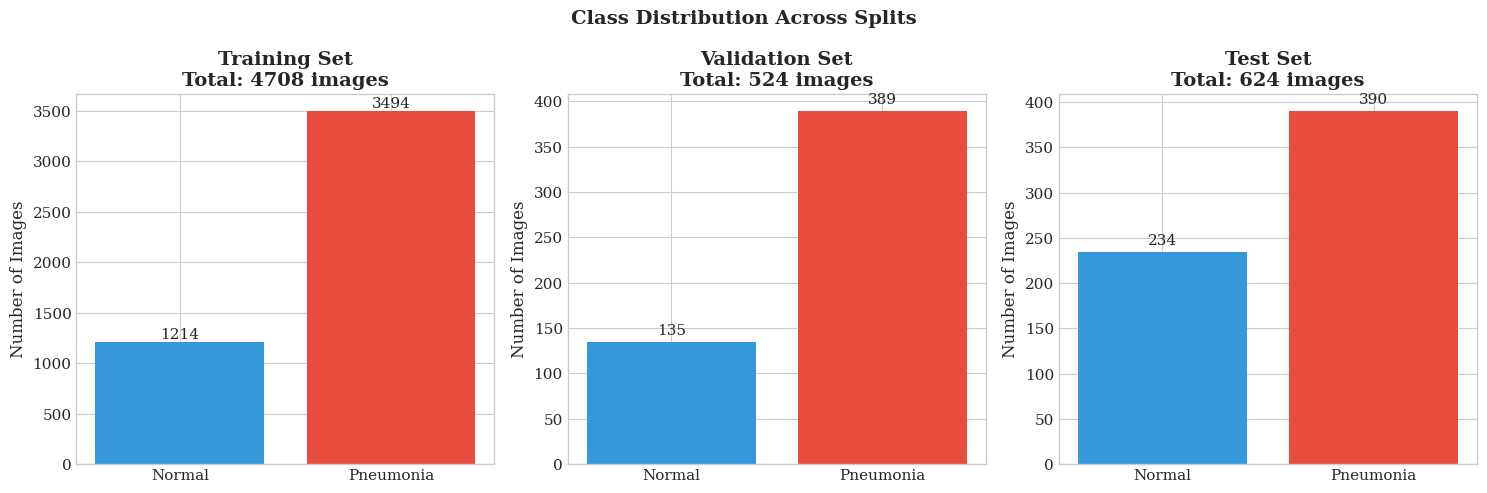


######################################################################
Training CNN Model
######################################################################
Epoch 1/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7940 - auc: 0.8741 - loss: 0.4212 - precision: 0.7940 - recall: 0.7940
Epoch 1: val_accuracy improved from -inf to 0.74237, saving model to ./pneumonia_detection_journal/saved_models/cnn_best.weights.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.7947 - auc: 0.8749 - loss: 0.4201 - precision: 0.7947 - recall: 0.7947 - val_accuracy: 0.7424 - val_auc: 0.7424 - val_loss: 2.6340 - val_precision: 0.7424 - val_recall: 0.7424 - learning_rate: 0.0010
Epoch 2/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8947 - auc: 0.9598 - loss: 0.2560 - precision: 0.8947 - recall: 0.8947
Epoch 2: val_accuracy did not improve from 0.74237
148/148 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.8949 - auc: 0.9598 - loss: 0.2558 - precision: 0.8949 - recall: 0

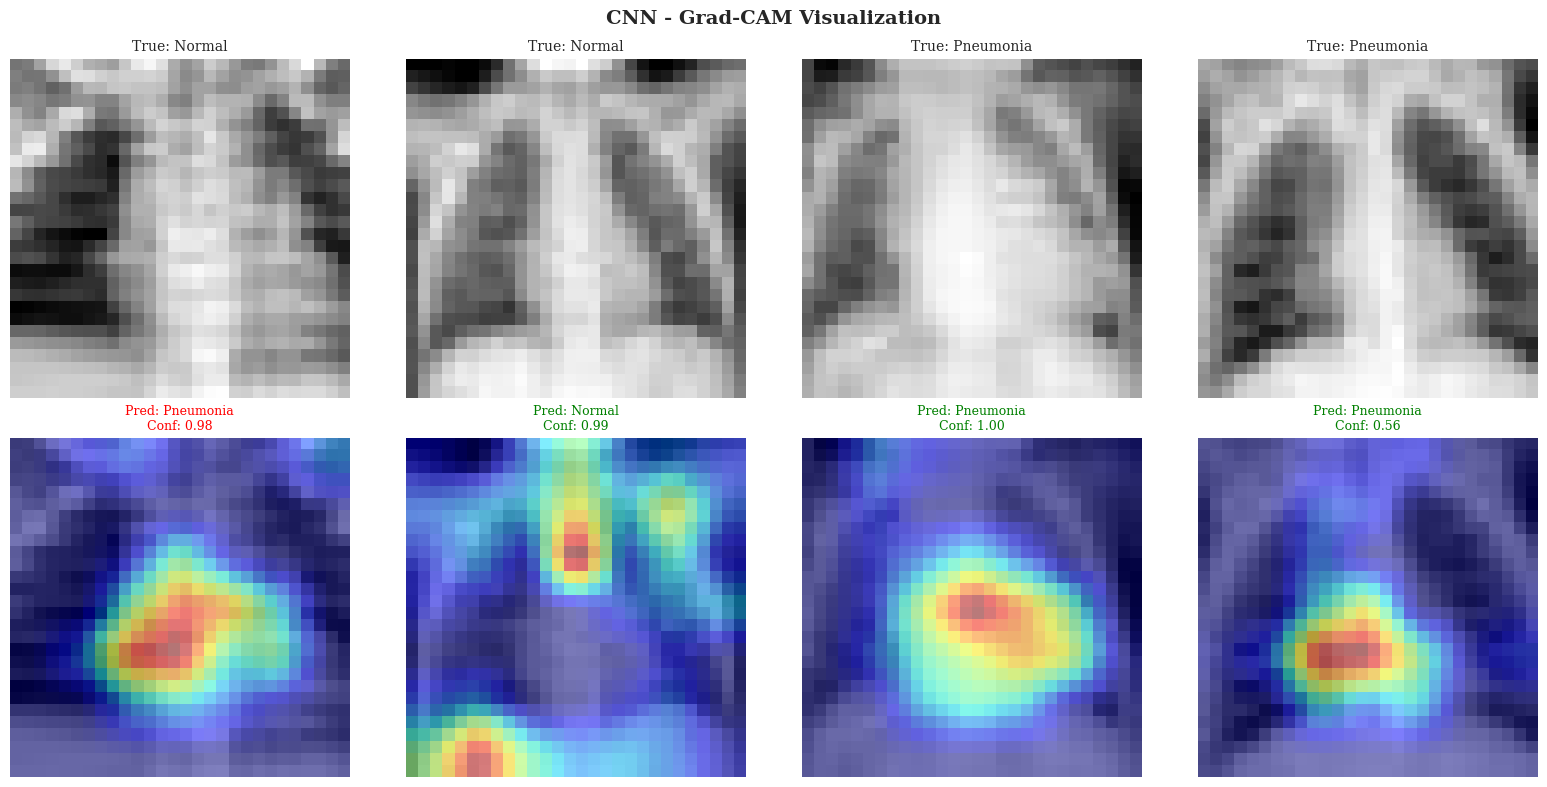

✅ Grad-CAM for CNN complete

📊 Generating Grad-CAM for ViT...


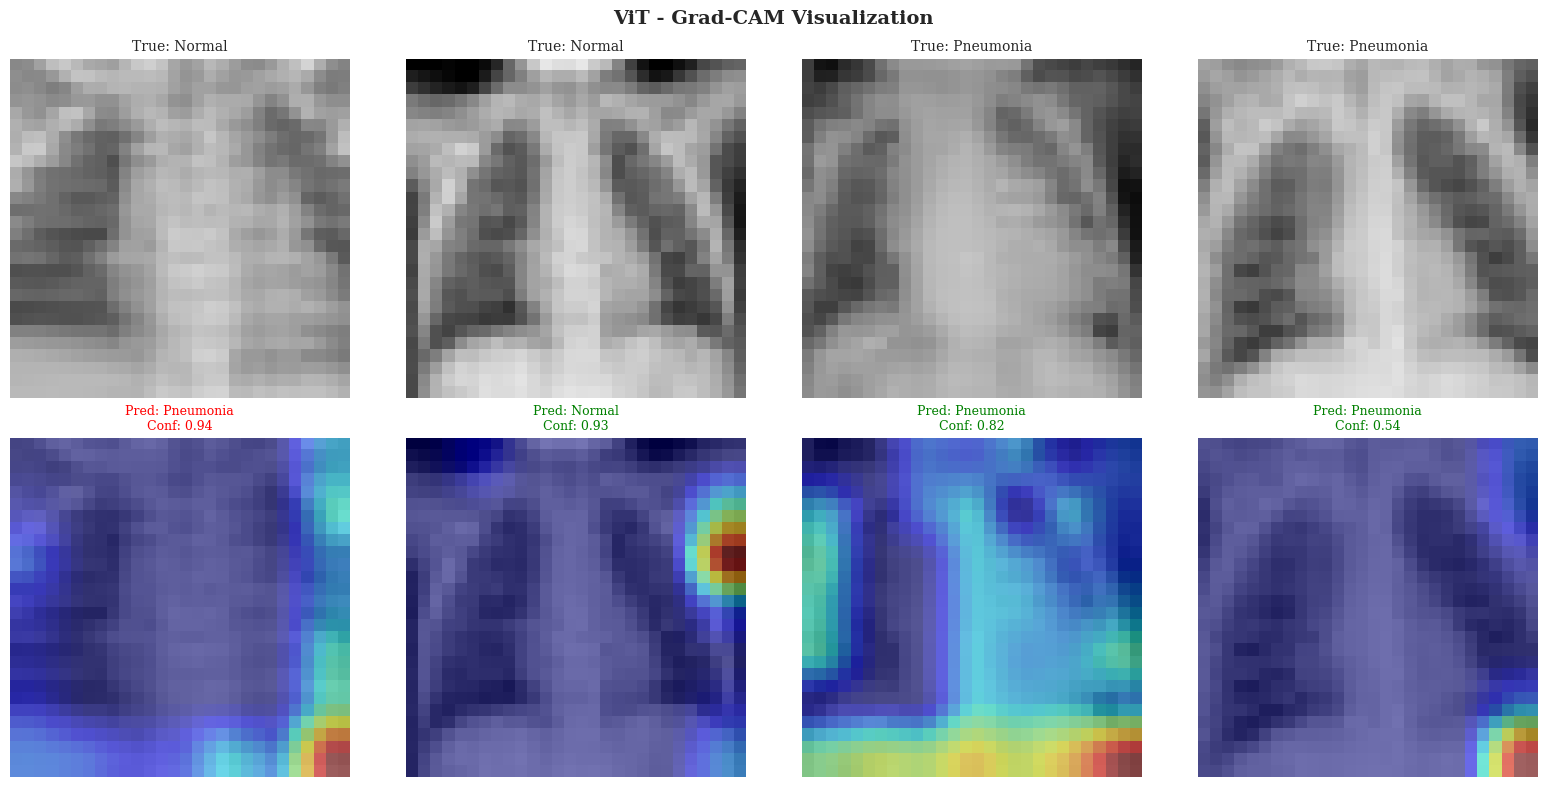

✅ Grad-CAM for ViT complete

######################################################################
Ensemble Prediction
######################################################################

Ensemble RESULTS
Accuracy:  0.8654
Precision: 0.8385
Recall:    0.9718
F1-Score:  0.9002
ROC AUC:   0.9553
PR AUC:    0.9687

SUMMARY

           Accuracy  Precision  Recall  F1-Score  ROC AUC
CNN         0.8814     0.8575  0.9718    0.9111   0.9649
ViT         0.7885     0.7688  0.9462    0.8483   0.9050
Ensemble    0.8654     0.8385  0.9718    0.9002   0.9553

✅ Results saved to ./pneumonia_detection_journal/results
✅ Grad-CAM visualizations saved to ./pneumonia_detection_journal/figures

🎉 ALL COMPLETED SUCCESSFULLY!


In [ ]:
# ============================================================================
# COMPLETE PIPELINE WITH GRAD-CAM (Run all cells in order)
# ============================================================================

# Cell 1: Install and Import
!pip install medmnist tensorflow scikit-learn matplotlib seaborn pandas scipy opencv-python

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                            precision_recall_curve, f1_score, accuracy_score,
                            precision_score, recall_score, cohen_kappa_score,
                            matthews_corrcoef)
import pandas as pd
import medmnist
from medmnist import INFO
import json
import warnings
from datetime import datetime
import cv2
from tensorflow.keras import models as keras_models
warnings.filterwarnings('ignore')

# Print versions
print(f"\nTensorFlow version: {tf.__version__}")
print(f"MedMNIST version: {medmnist.__version__}")

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    DATA_FLAG = "pneumoniamnist"
    IMG_SIZE = 28
    NUM_CLASSES = 2
    CLASS_NAMES = ['Normal', 'Pneumonia']

    BATCH_SIZE = 32
    EPOCHS = 30
    LEARNING_RATE = 0.001
    DROPOUT_RATE = 0.3
    PATIENCE = 5

    BASE_DIR = './pneumonia_detection_journal'
    SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')
    RESULTS_DIR = os.path.join(BASE_DIR, 'results')
    FIGURES_DIR = os.path.join(BASE_DIR, 'figures')

    SEED = 42

# Create directories
for dir_path in [Config.SAVE_DIR, Config.RESULTS_DIR, Config.FIGURES_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# Set seeds
tf.random.set_seed(Config.SEED)
np.random.seed(Config.SEED)

# ============================================================================
# DATA LOADING
# ============================================================================

class PneumoniaDataLoader:
    """Data loader for PneumoniaMNIST"""

    def __init__(self):
        self.info = INFO[Config.DATA_FLAG]
        self.DataClass = getattr(medmnist, self.info['python_class'])

    def load_data(self):
        """Load all data splits"""
        print("\n" + "="*70)
        print("LOADING PNEUMONIAMNIST DATASET")
        print("="*70)

        # Load splits
        train_data = self.DataClass(split='train', download=True)
        val_data = self.DataClass(split='val', download=True)
        test_data = self.DataClass(split='test', download=True)

        # Extract images and labels
        X_train = train_data.imgs
        y_train = train_data.labels.flatten()
        X_val = val_data.imgs
        y_val = val_data.labels.flatten()
        X_test = test_data.imgs
        y_test = test_data.labels.flatten()

        # Normalize to [0, 1]
        X_train = X_train.astype('float32') / 255.0
        X_val = X_val.astype('float32') / 255.0
        X_test = X_test.astype('float32') / 255.0

        # Add channel dimension
        X_train = X_train.reshape(-1, 28, 28, 1)
        X_val = X_val.reshape(-1, 28, 28, 1)
        X_test = X_test.reshape(-1, 28, 28, 1)

        # Convert to RGB for Vision Transformer
        X_train_rgb = np.repeat(X_train, 3, axis=-1)
        X_val_rgb = np.repeat(X_val, 3, axis=-1)
        X_test_rgb = np.repeat(X_test, 3, axis=-1)

        # Print statistics
        print(f"\nDataset Statistics:")
        print(f"Training samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        print(f"Test samples: {len(X_test)}")
        print(f"Class distribution - Normal: {np.sum(y_train==0)}, Pneumonia: {np.sum(y_train==1)}")

        # Convert labels to categorical
        y_train_cat = tf.keras.utils.to_categorical(y_train, Config.NUM_CLASSES)
        y_val_cat = tf.keras.utils.to_categorical(y_val, Config.NUM_CLASSES)
        y_test_cat = tf.keras.utils.to_categorical(y_test, Config.NUM_CLASSES)

        return {
            'train': (X_train, X_train_rgb, y_train, y_train_cat),
            'val': (X_val, X_val_rgb, y_val, y_val_cat),
            'test': (X_test, X_test_rgb, y_test, y_test_cat)
        }

# ============================================================================
# DATASET VISUALIZATION
# ============================================================================

def visualize_dataset(data):
    """Visualize dataset samples and distribution"""

    X_train, _, y_train, _ = data['train']
    _, _, y_val, _ = data['val']
    _, _, y_test, _ = data['test']

    # 1. Sample images (10 from each class)
    fig, axes = plt.subplots(2, 10, figsize=(20, 5))

    normal_indices = np.where(y_train == 0)[0][:10]
    pneumonia_indices = np.where(y_train == 1)[0][:10]

    for i, idx in enumerate(normal_indices):
        axes[0, i].imshow(X_train[idx].squeeze(), cmap='gray')
        axes[0, i].set_title(f'Normal #{i+1}', fontsize=8)
        axes[0, i].axis('off')

    for i, idx in enumerate(pneumonia_indices):
        axes[1, i].imshow(X_train[idx].squeeze(), cmap='gray')
        axes[1, i].set_title(f'Pneumonia #{i+1}', fontsize=8, color='red')
        axes[1, i].axis('off')

    plt.suptitle('PneumoniaMNIST Dataset - 10 Sample Images from Each Class',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.FIGURES_DIR, 'dataset_samples.png'), dpi=150)
    plt.show()

    # 2. Class distribution
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    splits = ['Training', 'Validation', 'Test']
    totals = [len(y_train), len(y_val), len(y_test)]
    normals = [np.sum(y_train == 0), np.sum(y_val == 0), np.sum(y_test == 0)]
    pneumonias = [np.sum(y_train == 1), np.sum(y_val == 1), np.sum(y_test == 1)]

    for i, (split, total, normal, pneumonia) in enumerate(zip(splits, totals, normals, pneumonias)):
        axes[i].bar(['Normal', 'Pneumonia'], [normal, pneumonia],
                   color=['#3498db', '#e74c3c'])
        axes[i].set_title(f'{split} Set\nTotal: {total} images', fontweight='bold')
        axes[i].set_ylabel('Number of Images')

        # Add value labels
        for j, count in enumerate([normal, pneumonia]):
            axes[i].text(j, count + 5, str(count), ha='center', va='bottom')

    plt.suptitle('Class Distribution Across Splits', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.FIGURES_DIR, 'class_distribution.png'), dpi=150)
    plt.show()

# ============================================================================
# MODEL ARCHITECTURES
# ============================================================================

def create_cnn_model():
    """Create CNN model"""
    inputs = layers.Input(shape=(28, 28, 1))

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    return models.Model(inputs, outputs)

def create_vit_model():
    """Create Vision Transformer model"""
    inputs = layers.Input(shape=(28, 28, 3))

    # Patch embedding
    x = layers.Conv2D(64, 7, strides=4, padding='same', activation='relu')(inputs)
    x = layers.Reshape((-1, 64))(x)

    # Position embedding
    positions = tf.range(start=0, limit=49, delta=1)
    pos_embed = layers.Embedding(49, 64)(positions)
    x = x + pos_embed

    # Transformer block
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.GlobalAveragePooling1D()(x)

    # Classification head
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    return models.Model(inputs, outputs)

# ============================================================================
# TRAINER CLASS
# ============================================================================

class ModelTrainer:
    def __init__(self, model, model_name):
        self.model = model
        self.model_name = model_name
        self.history = None

    def train(self, X_train, y_train, X_val, y_val):
        """Train the model"""

        # Data augmentation
        aug = tf.keras.Sequential([
            layers.RandomRotation(0.1),
            layers.RandomTranslation(0.1, 0.1),
            layers.RandomZoom(0.1),
        ])

        # Compile
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE),
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                     tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')]
        )

        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=Config.PATIENCE,
                         restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
            ModelCheckpoint(
                os.path.join(Config.SAVE_DIR, f'{self.model_name}_best.weights.h5'),
                monitor='val_accuracy', save_best_only=True,
                save_weights_only=True, verbose=1
            )
        ]

        # Create datasets
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_ds = train_ds.shuffle(1000).batch(Config.BATCH_SIZE).map(
            lambda x, y: (aug(x, training=True), y)
        ).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
                                 .batch(Config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

        # Train
        self.history = self.model.fit(
            train_ds, validation_data=val_ds,
            epochs=Config.EPOCHS, callbacks=callbacks, verbose=1
        )

        return self.history

# ============================================================================
# ENSEMBLE
# ============================================================================

class Ensemble:
    def __init__(self, models):
        self.models = models

    def predict(self, X_cnn, X_vit):
        """Average predictions from both models"""
        cnn_pred = self.models[0].predict(X_cnn, verbose=0)
        vit_pred = self.models[1].predict(X_vit, verbose=0)
        return (cnn_pred + vit_pred) / 2

# ============================================================================
# METRICS
# ============================================================================

class MetricsCalculator:
    def calculate_all(self, y_true, y_pred, y_probs):
        """Calculate all metrics"""
        return {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1_score': f1_score(y_true, y_pred),
            'roc_auc': auc(*roc_curve(y_true, y_probs)[:2]),
            'pr_auc': auc(*precision_recall_curve(y_true, y_probs)[1::-1]),
            'confusion_matrix': confusion_matrix(y_true, y_pred).tolist()
        }

    def print_table(self, metrics, name):
        """Print metrics table"""
        print(f"\n{'='*60}")
        print(f"{name} RESULTS")
        print(f"{'='*60}")
        print(f"Accuracy:  {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall:    {metrics['recall']:.4f}")
        print(f"F1-Score:  {metrics['f1_score']:.4f}")
        print(f"ROC AUC:   {metrics['roc_auc']:.4f}")
        print(f"PR AUC:    {metrics['pr_auc']:.4f}")

# ============================================================================
# GRAD-CAM VISUALIZATION
# ============================================================================

def minimal_gradcam(model, image, layer_name=None):
    """Absolute minimal Grad-CAM implementation"""

    # Find conv layer
    if layer_name is None:
        for layer in reversed(model.layers):
            if 'conv' in layer.name.lower():
                layer_name = layer.name
                break

    if layer_name is None:
        raise ValueError("No convolutional layer found")

    # Create gradient model
    grad_model = keras_models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    # Prepare image
    if len(image.shape) == 3:
        img_array = np.expand_dims(image, axis=0)
    else:
        img_array = image

    # Get prediction
    preds = model.predict(img_array, verbose=0)[0]
    class_idx = np.argmax(preds)

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    # Get gradients and compute heatmap
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)
    cam = tf.nn.relu(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-7)

    # Resize
    heatmap = tf.image.resize(cam[..., tf.newaxis],
                              (image.shape[0], image.shape[1])).numpy().squeeze()

    return heatmap, class_idx, preds[class_idx]

def show_gradcam_samples(model, model_name, X_test, y_test, num_samples=4, save_dir=None):
    """Show Grad-CAM for sample images"""

    print(f"\n📊 Generating Grad-CAM for {model_name}...")

    # Select samples (mix of normal and pneumonia)
    normal_idx = np.where(y_test == 0)[0][:2]
    pneumonia_idx = np.where(y_test == 1)[0][:2]
    sample_indices = np.concatenate([normal_idx, pneumonia_idx])

    fig, axes = plt.subplots(2, len(sample_indices), figsize=(16, 8))

    for i, idx in enumerate(sample_indices):
        img = X_test[idx]

        # Generate Grad-CAM
        heatmap, pred_class, conf = minimal_gradcam(model, img)

        # Original image
        axes[0, i].imshow(img.squeeze(), cmap='gray')
        true_label = "Normal" if y_test[idx] == 0 else "Pneumonia"
        axes[0, i].set_title(f'True: {true_label}', fontsize=10)
        axes[0, i].axis('off')

        # Overlay
        axes[1, i].imshow(img.squeeze(), cmap='gray')
        axes[1, i].imshow(heatmap, cmap='jet', alpha=0.5)
        pred_label = Config.CLASS_NAMES[pred_class]
        color = 'green' if pred_class == y_test[idx] else 'red'
        axes[1, i].set_title(f'Pred: {pred_label}\nConf: {conf:.2f}',
                            fontsize=9, color=color)
        axes[1, i].axis('off')

    plt.suptitle(f'{model_name} - Grad-CAM Visualization', fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, f'gradcam_{model_name.lower()}.png'),
                   dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Grad-CAM for {model_name} complete")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print("\n" + "="*70)
    print("PNEUMONIA DETECTION SYSTEM WITH GRAD-CAM")
    print("="*70)

    # Load data
    loader = PneumoniaDataLoader()
    data = loader.load_data()

    # Visualize dataset
    visualize_dataset(data)

    X_train, X_train_rgb, y_train, y_train_cat = data['train']
    X_val, X_val_rgb, y_val, y_val_cat = data['val']
    X_test, X_test_rgb, y_test, y_test_cat = data['test']

    # Initialize
    calculator = MetricsCalculator()
    models = []
    results = {}

    # 1. Train CNN
    print("\n" + "#"*70)
    print("Training CNN Model")
    print("#"*70)

    cnn_model = create_cnn_model()
    trainer = ModelTrainer(cnn_model, 'cnn')
    trainer.train(X_train, y_train_cat, X_val, y_val_cat)

    y_pred_probs = cnn_model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    metrics = calculator.calculate_all(y_test, y_pred, y_pred_probs[:, 1])
    calculator.print_table(metrics, "CNN")

    results['CNN'] = {**metrics, 'y_true': y_test, 'y_probs': y_pred_probs[:, 1]}
    models.append(cnn_model)

    # 2. Train ViT
    print("\n" + "#"*70)
    print("Training Vision Transformer")
    print("#"*70)

    vit_model = create_vit_model()
    trainer = ModelTrainer(vit_model, 'vit')
    trainer.train(X_train_rgb, y_train_cat, X_val_rgb, y_val_cat)

    y_pred_probs = vit_model.predict(X_test_rgb, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    metrics = calculator.calculate_all(y_test, y_pred, y_pred_probs[:, 1])
    calculator.print_table(metrics, "Vision Transformer")

    results['ViT'] = {**metrics, 'y_true': y_test, 'y_probs': y_pred_probs[:, 1]}
    models.append(vit_model)

    # ========================================================================
    # GRAD-CAM VISUALIZATION
    # ========================================================================

    print("\n" + "="*70)
    print("GRAD-CAM INTERPRETABILITY ANALYSIS")
    print("="*70)

    # Grad-CAM for CNN
    show_gradcam_samples(
        cnn_model, "CNN",
        X_test, y_test,
        num_samples=4,
        save_dir=Config.FIGURES_DIR
    )

    # Grad-CAM for ViT
    show_gradcam_samples(
        vit_model, "ViT",
        X_test_rgb, y_test,
        num_samples=4,
        save_dir=Config.FIGURES_DIR
    )

    # 3. Ensemble
    print("\n" + "#"*70)
    print("Ensemble Prediction")
    print("#"*70)

    ensemble = Ensemble(models)
    ensemble_probs = ensemble.predict(X_test, X_test_rgb)
    y_pred = np.argmax(ensemble_probs, axis=1)
    metrics = calculator.calculate_all(y_test, y_pred, ensemble_probs[:, 1])
    calculator.print_table(metrics, "Ensemble")

    results['Ensemble'] = {**metrics, 'y_true': y_test, 'y_probs': ensemble_probs[:, 1]}

    # Summary
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    summary = pd.DataFrame({
        name: {
            'Accuracy': r['accuracy'],
            'Precision': r['precision'],
            'Recall': r['recall'],
            'F1-Score': r['f1_score'],
            'ROC AUC': r['roc_auc']
        } for name, r in results.items()
    }).T
    print("\n", summary.round(4))

    # Save results
    summary.to_csv(os.path.join(Config.RESULTS_DIR, 'results.csv'))

    # Save all results as JSON
    final_results = {
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'config': {
            'batch_size': Config.BATCH_SIZE,
            'epochs': Config.EPOCHS,
            'learning_rate': Config.LEARNING_RATE
        },
        'results': {name: {
            'accuracy': float(r['accuracy']),
            'precision': float(r['precision']),
            'recall': float(r['recall']),
            'f1_score': float(r['f1_score']),
            'roc_auc': float(r['roc_auc']),
            'pr_auc': float(r['pr_auc'])
        } for name, r in results.items()}
    }

    with open(os.path.join(Config.RESULTS_DIR, 'final_results.json'), 'w') as f:
        json.dump(final_results, f, indent=4)

    print(f"\n✅ Results saved to {Config.RESULTS_DIR}")
    print(f"✅ Grad-CAM visualizations saved to {Config.FIGURES_DIR}")
    print(f"\n{'='*70}")
    print("🎉 ALL COMPLETED SUCCESSFULLY!")
    print("="*70)

if __name__ == "__main__":
    main()

In [ ]:
# ============================================================================
# VISUALIZATION FUNCTIONS - Add this entire section
# ============================================================================

def plot_confusion_matrix(cm, model_name, save_dir=None):
    """
    Plot enhanced confusion matrix with percentages

    Args:
        cm: Confusion matrix array
        model_name: Name of the model
        save_dir: Directory to save the figure
    """
    plt.figure(figsize=(8, 6))

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=Config.CLASS_NAMES,
                yticklabels=Config.CLASS_NAMES,
                annot_kws={'size': 14})

    # Add percentage labels
    for i in range(2):
        for j in range(2):
            plt.gca().text(j+0.5, i+0.7, f'({cm_percent[i,j]:.1f}%)',
                          ha='center', va='center', fontsize=10)

    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, f'{model_name.lower()}_confusion.png'),
                   dpi=150, bbox_inches='tight')
    plt.show()

    # Print analysis
    print(f"\n📊 {model_name} Confusion Matrix Analysis:")
    print(f"   True Negatives (Normal correct): {cm[0,0]}")
    print(f"   False Positives (Normal→Pneumonia): {cm[0,1]}")
    print(f"   False Negatives (Pneumonia→Normal): {cm[1,0]}")
    print(f"   True Positives (Pneumonia correct): {cm[1,1]}")
    print(f"   Accuracy: {(cm[0,0] + cm[1,1]) / np.sum(cm):.2%}")

def plot_roc_curves_comparison(results_dict, save_dir=None):
    """
    Plot ROC curves for all models comparison

    Args:
        results_dict: Dictionary with model names and their y_true, y_probs
        save_dir: Directory to save the figure
    """
    plt.figure(figsize=(10, 8))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    for i, (name, data) in enumerate(results_dict.items()):
        if 'y_true' in data and 'y_probs' in data:
            fpr, tpr, _ = roc_curve(data['y_true'], data['y_probs'])
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
                    label=f'{name} (AUC = {roc_auc:.4f})')

    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Random Classifier')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, 'roc_curves_comparison.png'),
                   dpi=150, bbox_inches='tight')
    plt.show()

def plot_pr_curves_comparison(results_dict, save_dir=None):
    """
    Plot Precision-Recall curves for all models comparison

    Args:
        results_dict: Dictionary with model names and their y_true, y_probs
        save_dir: Directory to save the figure
    """
    plt.figure(figsize=(10, 8))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    for i, (name, data) in enumerate(results_dict.items()):
        if 'y_true' in data and 'y_probs' in data:
            precision, recall, _ = precision_recall_curve(data['y_true'], data['y_probs'])
            pr_auc = auc(recall, precision)

            plt.plot(recall, precision, color=colors[i % len(colors)], lw=2,
                    label=f'{name} (AP = {pr_auc:.4f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, 'pr_curves_comparison.png'),
                   dpi=150, bbox_inches='tight')
    plt.show()

def plot_error_analysis(y_true, y_pred, y_probs, X_test, model_name, save_dir=None, num_samples=5):
    """
    Comprehensive error analysis with visualization of misclassified samples

    Args:
        y_true: True labels
        y_pred: Predicted labels
        y_probs: Prediction probabilities
        X_test: Test images
        model_name: Name of the model
        save_dir: Directory to save the figure
        num_samples: Number of error samples to display
    """
    print(f"\n{'='*60}")
    print(f"ERROR ANALYSIS - {model_name}")
    print(f"{'='*60}")

    # Find misclassified indices
    misclassified = np.where(y_true != y_pred)[0]
    false_positives = np.where((y_true == 0) & (y_pred == 1))[0]
    false_negatives = np.where((y_true == 1) & (y_pred == 0))[0]

    total_errors = len(misclassified)
    fp_count = len(false_positives)
    fn_count = len(false_negatives)

    print(f"\n📊 Error Statistics:")
    print(f"   Total errors: {total_errors} / {len(y_true)} ({total_errors/len(y_true)*100:.2f}%)")
    print(f"   False Positives (Normal→Pneumonia): {fp_count} ({fp_count/total_errors*100:.1f}% of errors)")
    print(f"   False Negatives (Pneumonia→Normal): {fn_count} ({fn_count/total_errors*100:.1f}% of errors)")

    if fp_count > 0:
        fp_conf = np.mean(y_probs[false_positives])
        print(f"   Avg confidence for False Positives: {fp_conf:.3f}")

    if fn_count > 0:
        fn_conf = np.mean(1 - y_probs[false_negatives])
        print(f"   Avg confidence for False Negatives: {fn_conf:.3f}")

    # Visualize false positives
    if fp_count > 0:
        fig, axes = plt.subplots(2, min(5, fp_count), figsize=(15, 6))
        if fp_count == 1:
            axes = axes.reshape(2, 1)

        samples = false_positives[:min(5, fp_count)]

        for i, idx in enumerate(samples):
            # Original image
            img = X_test[idx].squeeze()
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(f'FP #{i+1}\nTrue: Normal', fontsize=10)
            axes[0, i].axis('off')

            # With confidence
            axes[1, i].imshow(img, cmap='gray')
            axes[1, i].set_title(f'Pred: Pneumonia\nConf: {y_probs[idx]:.2f}',
                                 fontsize=10, color='red')
            axes[1, i].axis('off')

        plt.suptitle(f'{model_name} - False Positives (Normal misclassified as Pneumonia)',
                    fontsize=12, fontweight='bold')
        plt.tight_layout()
        if save_dir:
            plt.savefig(os.path.join(save_dir, f'{model_name.lower()}_false_positives.png'),
                       dpi=150, bbox_inches='tight')
        plt.show()

    # Visualize false negatives
    if fn_count > 0:
        fig, axes = plt.subplots(2, min(5, fn_count), figsize=(15, 6))
        if fn_count == 1:
            axes = axes.reshape(2, 1)

        samples = false_negatives[:min(5, fn_count)]

        for i, idx in enumerate(samples):
            # Original image
            img = X_test[idx].squeeze()
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(f'FN #{i+1}\nTrue: Pneumonia', fontsize=10, color='red')
            axes[0, i].axis('off')

            # With confidence
            axes[1, i].imshow(img, cmap='gray')
            axes[1, i].set_title(f'Pred: Normal\nConf: {1-y_probs[idx]:.2f}',
                                 fontsize=10, color='red')
            axes[1, i].axis('off')

        plt.suptitle(f'{model_name} - False Negatives (Pneumonia misclassified as Normal)',
                    fontsize=12, fontweight='bold')
        plt.tight_layout()
        if save_dir:
            plt.savefig(os.path.join(save_dir, f'{model_name.lower()}_false_negatives.png'),
                       dpi=150, bbox_inches='tight')
        plt.show()

    return {
        'total_errors': total_errors,
        'false_positives': fp_count,
        'false_negatives': fn_count,
        'fp_confidence': float(np.mean(y_probs[false_positives])) if fp_count > 0 else 0,
        'fn_confidence': float(np.mean(1 - y_probs[false_negatives])) if fn_count > 0 else 0
    }

def plot_comparison_table(results_dict, save_dir=None):
    """
    Create a comprehensive comparison table with all metrics

    Args:
        results_dict: Dictionary with model names and their metrics
        save_dir: Directory to save the table
    """
    # Create DataFrame with all metrics
    comparison_data = []

    for name, data in results_dict.items():
        if 'accuracy' in data:  # Metrics dictionary
            metrics = data
            row = {
                'Model': name,
                'Accuracy': f"{metrics['accuracy']:.2%}",
                'Precision': f"{metrics['precision']:.2%}",
                'Recall': f"{metrics['recall']:.2%}",
                'F1-Score': f"{metrics['f1_score']:.2%}",
                'ROC AUC': f"{metrics['roc_auc']:.2%}",
                'PR AUC': f"{metrics['pr_auc']:.2%}" if 'pr_auc' in metrics else 'N/A'
            }
        else:  # Raw data with y_true, y_probs
            y_true = data['y_true']
            y_pred = data['y_pred'] if 'y_pred' in data else None
            y_probs = data['y_probs']

            if y_pred is None:
                y_pred = (y_probs > 0.5).astype(int)

            row = {
                'Model': name,
                'Accuracy': f"{accuracy_score(y_true, y_pred):.2%}",
                'Precision': f"{precision_score(y_true, y_pred):.2%}",
                'Recall': f"{recall_score(y_true, y_pred):.2%}",
                'F1-Score': f"{f1_score(y_true, y_pred):.2%}",
                'ROC AUC': f"{roc_auc_score(y_true, y_probs):.2%}",
                'PR AUC': f"{average_precision_score(y_true, y_probs):.2%}"
            }

        comparison_data.append(row)

    df = pd.DataFrame(comparison_data)
    df.set_index('Model', inplace=True)

    # Display as styled table
    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL COMPARISON TABLE")
    print("="*80)
    print("\n", df)

    # Create a styled figure
    fig, ax = plt.subplots(figsize=(12, len(df) * 0.8 + 2))
    ax.axis('tight')
    ax.axis('off')

    # Create table
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     rowLabels=df.index,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.15] * len(df.columns))

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Color code the best values
    for i, col in enumerate(df.columns):
        # Convert percentage strings back to float for comparison
        values = [float(v.strip('%'))/100 for v in df[col].values]
        best_idx = np.argmax(values)

        # Highlight best cell
        cell = table[(best_idx + 1, i)]
        cell.set_facecolor('#90EE90')  # Light green

    plt.title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, 'comparison_table.png'),
                   dpi=150, bbox_inches='tight')
    plt.show()

    # Save CSV
    csv_path = os.path.join(save_dir, 'comparison_table.csv') if save_dir else 'comparison_table.csv'
    df.to_csv(csv_path)
    print(f"\n✅ Comparison table saved to {csv_path}")

    return df

def plot_all_visualizations(model_names, y_trues, y_preds, y_probss, X_tests,
                           results_dict, save_dir=None):
    """
    Generate all visualizations in one go

    Args:
        model_names: List of model names
        y_trues: List of true labels for each model
        y_preds: List of predicted labels for each model
        y_probss: List of prediction probabilities for each model
        X_tests: List of test images for each model
        results_dict: Dictionary with all results
        save_dir: Directory to save figures
    """
    print("\n" + "="*80)
    print("GENERATING ALL VISUALIZATIONS")
    print("="*80)

    # 1. Confusion matrices for each model
    for i, name in enumerate(model_names):
        cm = confusion_matrix(y_trues[i], y_preds[i])
        plot_confusion_matrix(cm, name, save_dir)

    # 2. ROC curves comparison
    roc_data = {name: {'y_true': y_trues[i], 'y_probs': y_probss[i]}
                for i, name in enumerate(model_names)}
    plot_roc_curves_comparison(roc_data, save_dir)

    # 3. PR curves comparison
    plot_pr_curves_comparison(roc_data, save_dir)

    # 4. Error analysis for each model
    for i, name in enumerate(model_names):
        plot_error_analysis(y_trues[i], y_preds[i], y_probss[i],
                           X_tests[i], name, save_dir)

    # 5. Comparison table
    plot_comparison_table(results_dict, save_dir)

    print(f"\n✅ All visualizations saved to {save_dir}")

# Helper function for ROC AUC score
def roc_auc_score(y_true, y_probs):
    from sklearn.metrics import roc_auc_score as sk_roc_auc
    return sk_roc_auc(y_true, y_probs)

# Helper function for average precision
def average_precision_score(y_true, y_probs):
    from sklearn.metrics import average_precision_score as sk_ap
    return sk_ap(y_true, y_probs)


TensorFlow version: 2.19.0
MedMNIST version: 3.0.2

PNEUMONIA DETECTION SYSTEM WITH GRAD-CAM

LOADING PNEUMONIAMNIST DATASET

Dataset Statistics:
Training samples: 4708
Validation samples: 524
Test samples: 624
Class distribution - Normal: 1214, Pneumonia: 3494


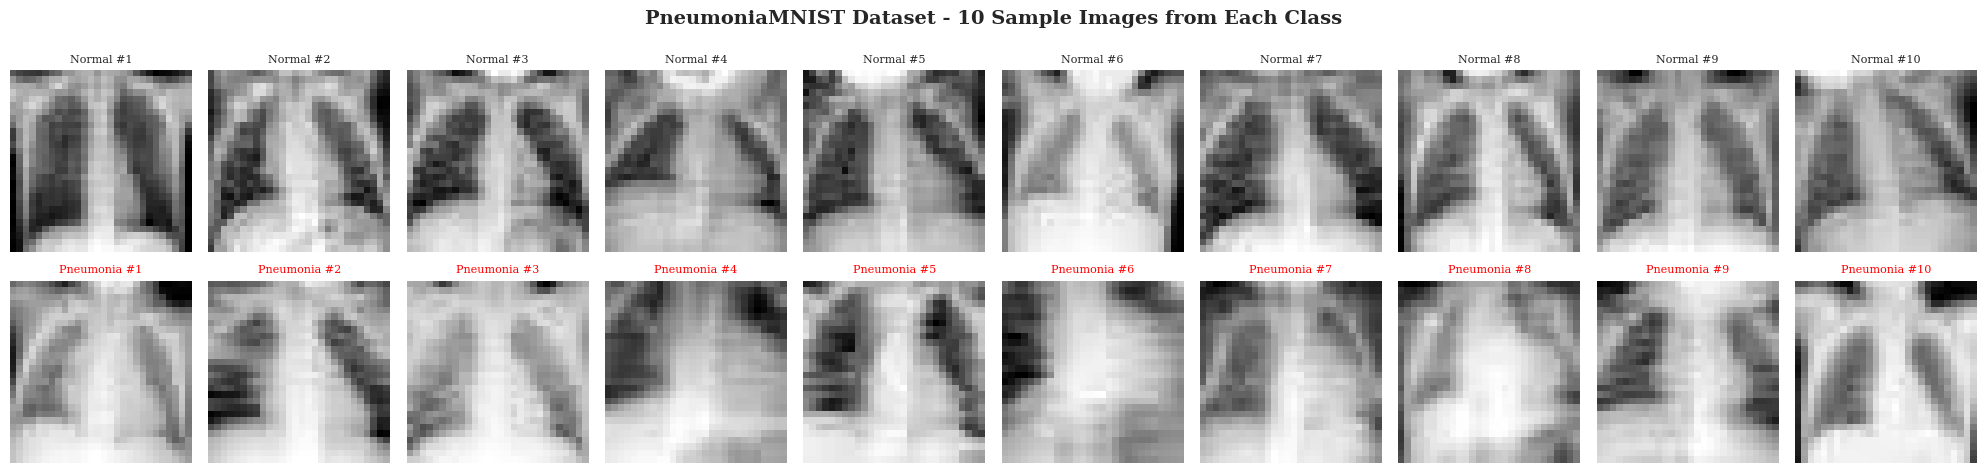

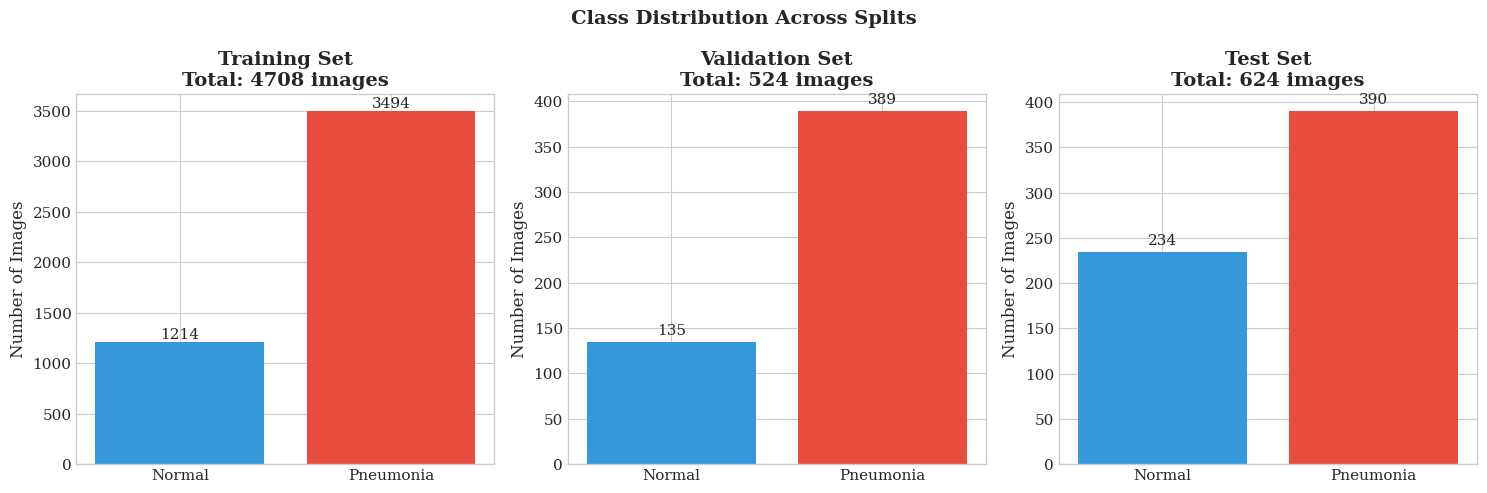


######################################################################
Training CNN Model
######################################################################
Epoch 1/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8464 - auc: 0.9168 - loss: 0.3603 - precision: 0.8464 - recall: 0.8464
Epoch 1: val_accuracy improved from -inf to 0.74237, saving model to ./pneumonia_detection_journal/saved_models/cnn_best.weights.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.8468 - auc: 0.9172 - loss: 0.3596 - precision: 0.8468 - recall: 0.8468 - val_accuracy: 0.7424 - val_auc: 0.7424 - val_loss: 2.6459 - val_precision: 0.7424 - val_recall: 0.7424 - learning_rate: 0.0010
Epoch 2/30
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9002 - auc: 0.9639 - loss: 0.2432 - precision: 0.9002 - recall: 0.9002
Epoch 2: val_accuracy did not improve from 0.74237
148/148 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.9003 - auc: 0.9640 - loss: 0.2431 - precision: 0.9003 - recall: 0

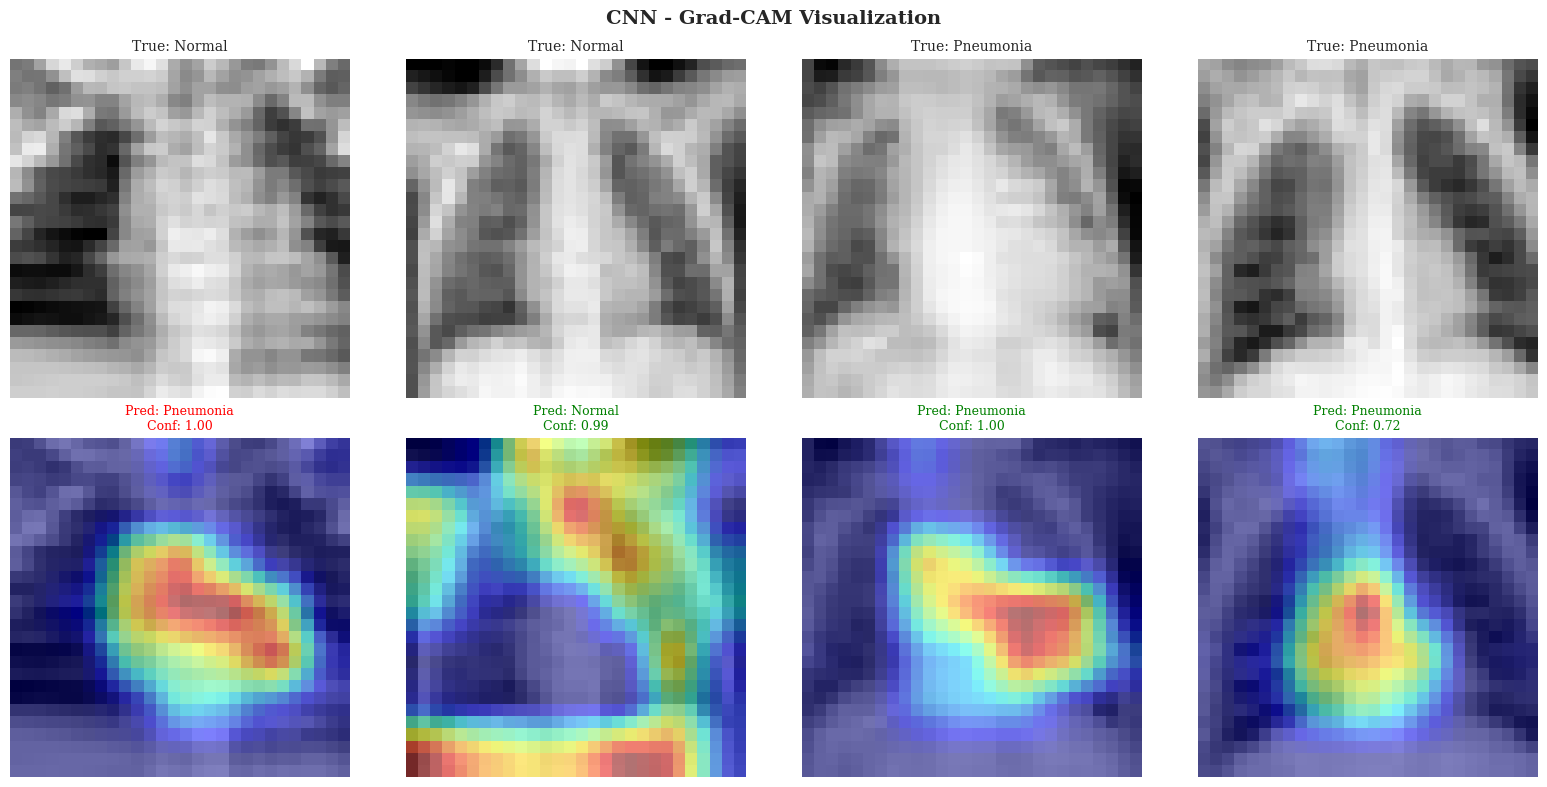

✅ Grad-CAM for CNN complete

📊 Generating Grad-CAM for ViT...


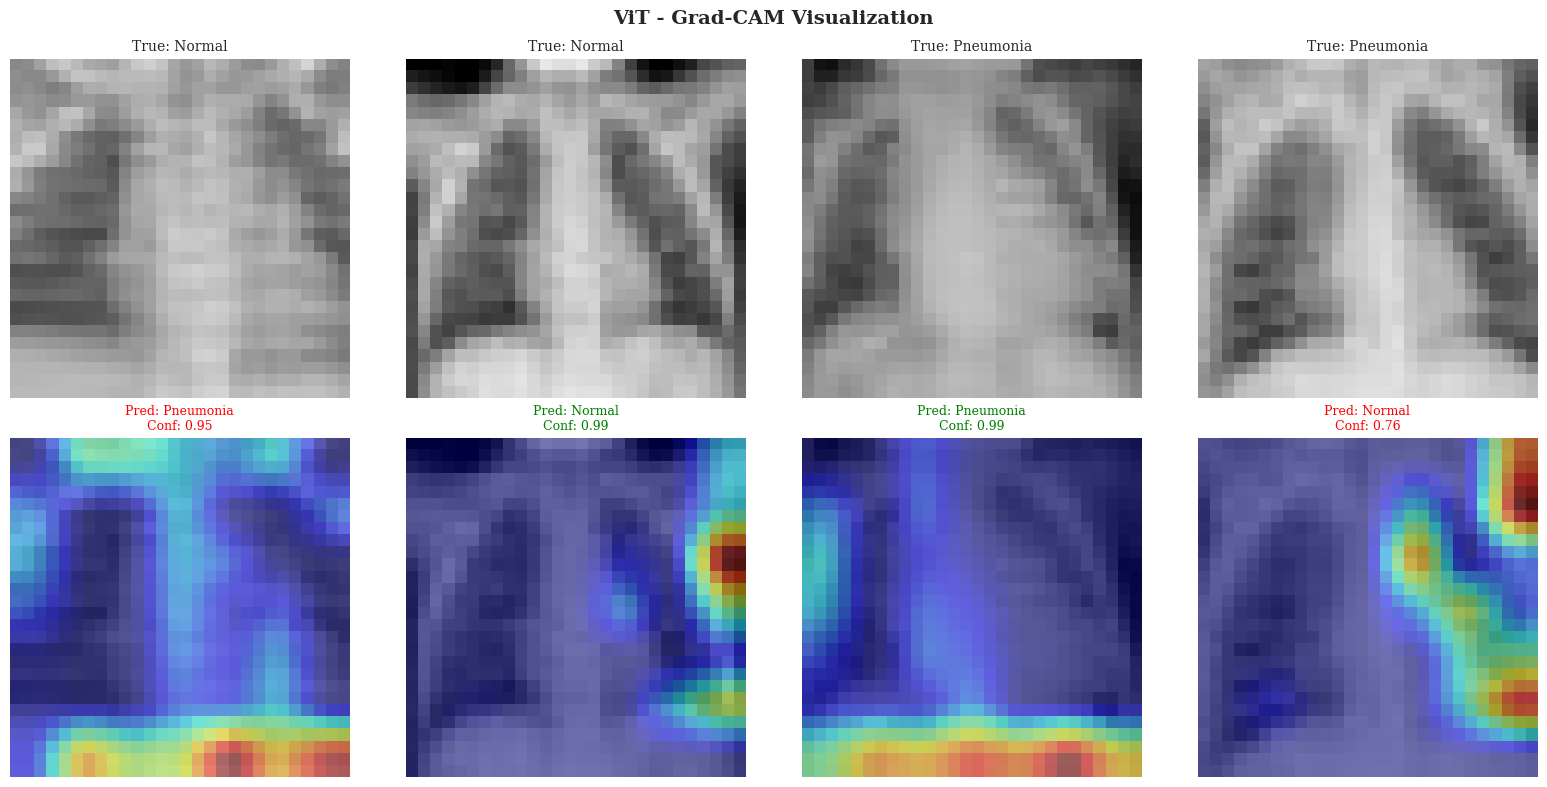

✅ Grad-CAM for ViT complete

######################################################################
Ensemble Prediction
######################################################################

Ensemble RESULTS
Accuracy:  0.8814
Precision: 0.8559
Recall:    0.9744
F1-Score:  0.9113
ROC AUC:   0.9631
PR AUC:    0.9739

GENERATING ALL VISUALIZATIONS


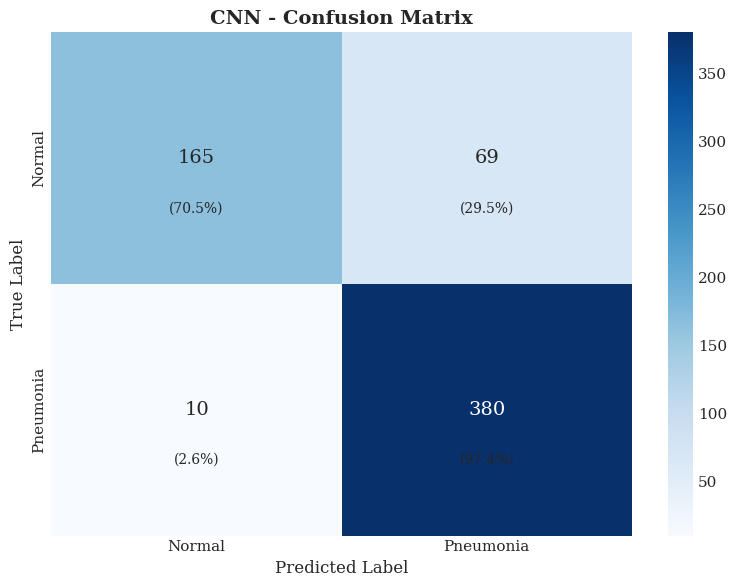


📊 CNN Confusion Matrix Analysis:
   True Negatives (Normal correct): 165
   False Positives (Normal→Pneumonia): 69
   False Negatives (Pneumonia→Normal): 10
   True Positives (Pneumonia correct): 380
   Accuracy: 87.34%


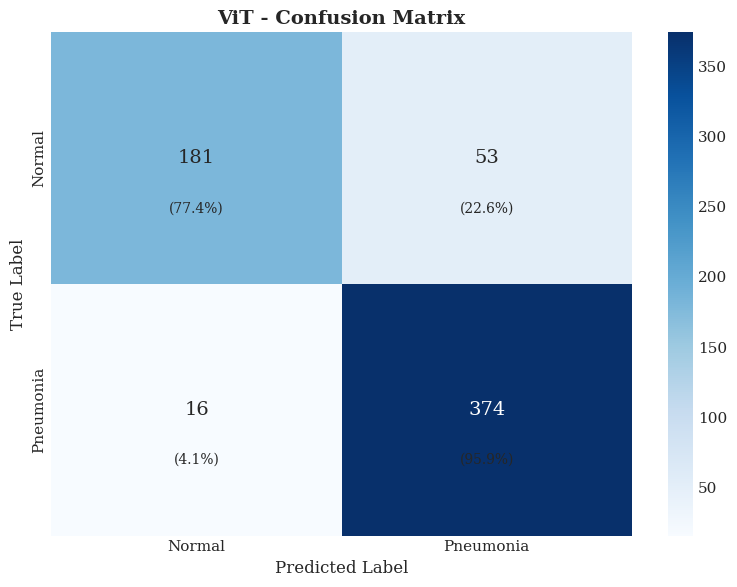


📊 ViT Confusion Matrix Analysis:
   True Negatives (Normal correct): 181
   False Positives (Normal→Pneumonia): 53
   False Negatives (Pneumonia→Normal): 16
   True Positives (Pneumonia correct): 374
   Accuracy: 88.94%


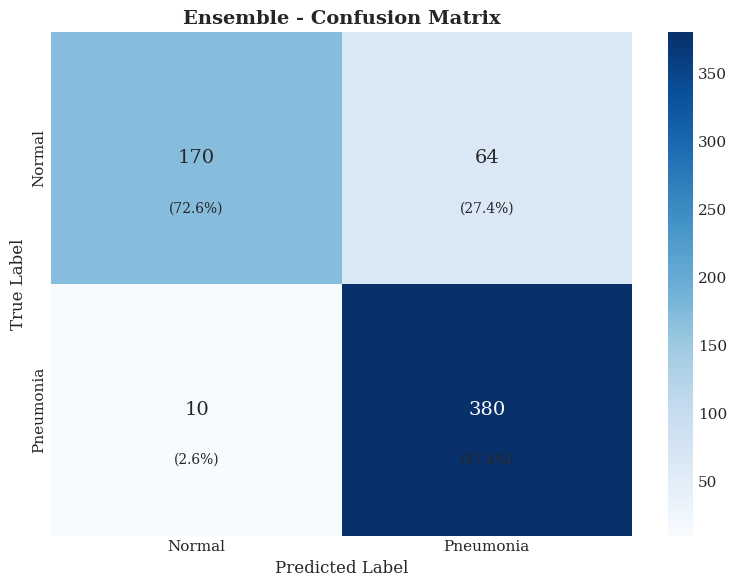


📊 Ensemble Confusion Matrix Analysis:
   True Negatives (Normal correct): 170
   False Positives (Normal→Pneumonia): 64
   False Negatives (Pneumonia→Normal): 10
   True Positives (Pneumonia correct): 380
   Accuracy: 88.14%


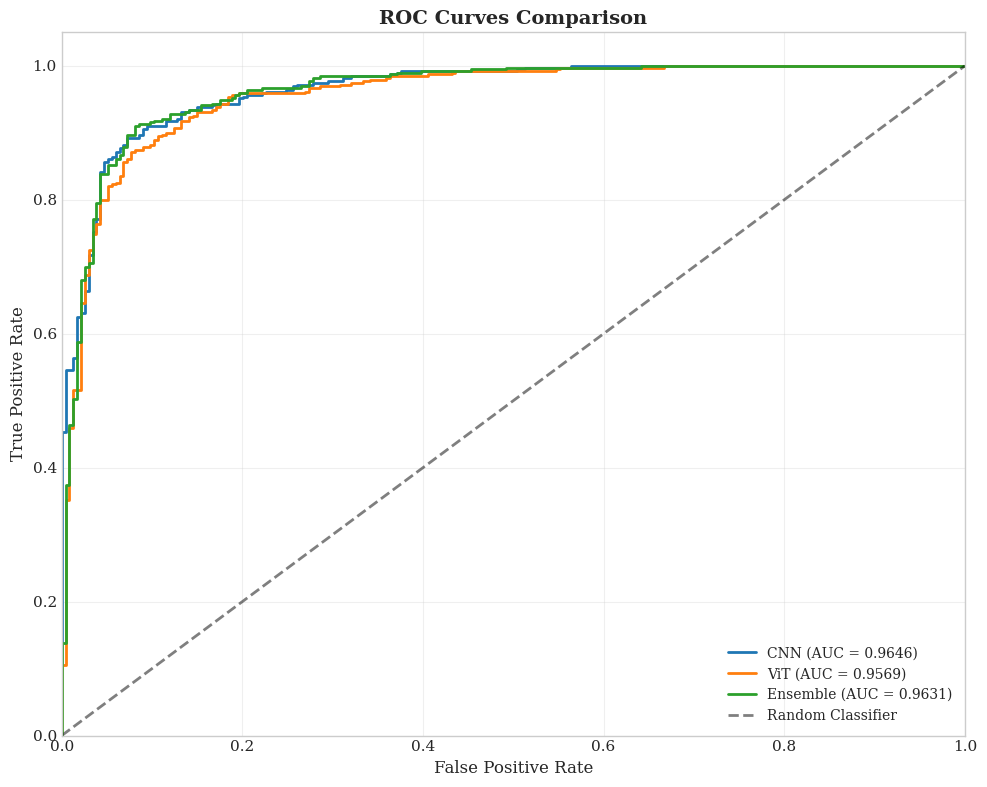

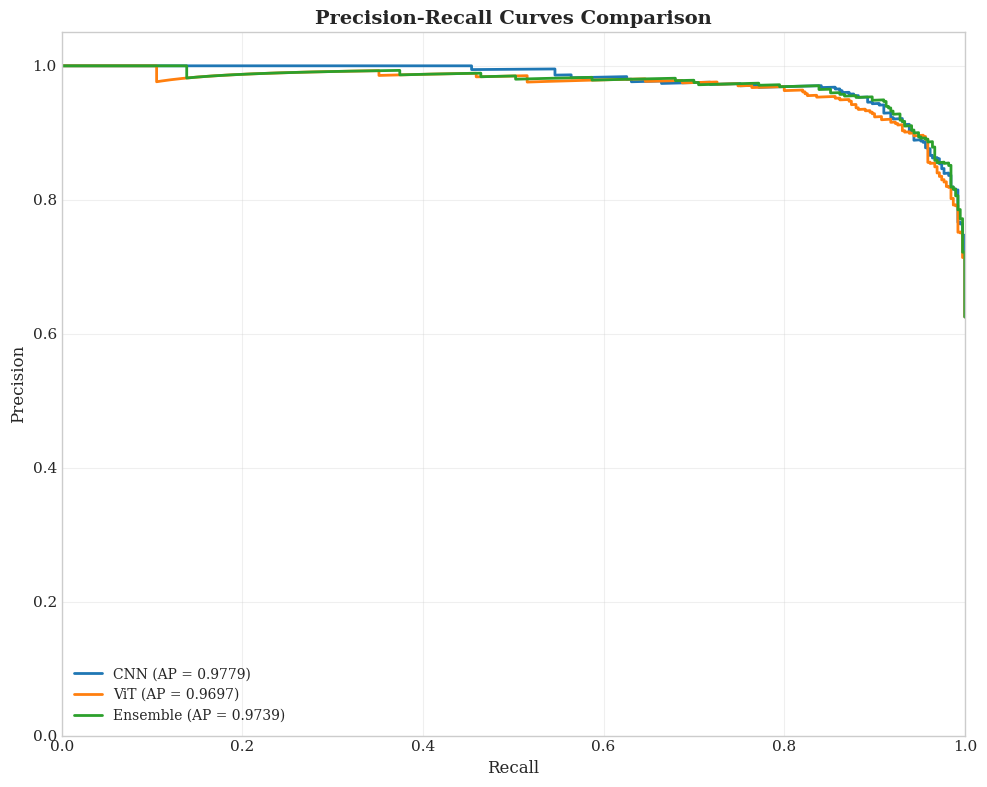


ERROR ANALYSIS - CNN

📊 Error Statistics:
   Total errors: 79 / 624 (12.66%)
   False Positives (Normal→Pneumonia): 69 (87.3% of errors)
   False Negatives (Pneumonia→Normal): 10 (12.7% of errors)
   Avg confidence for False Positives: 0.821
   Avg confidence for False Negatives: 0.678


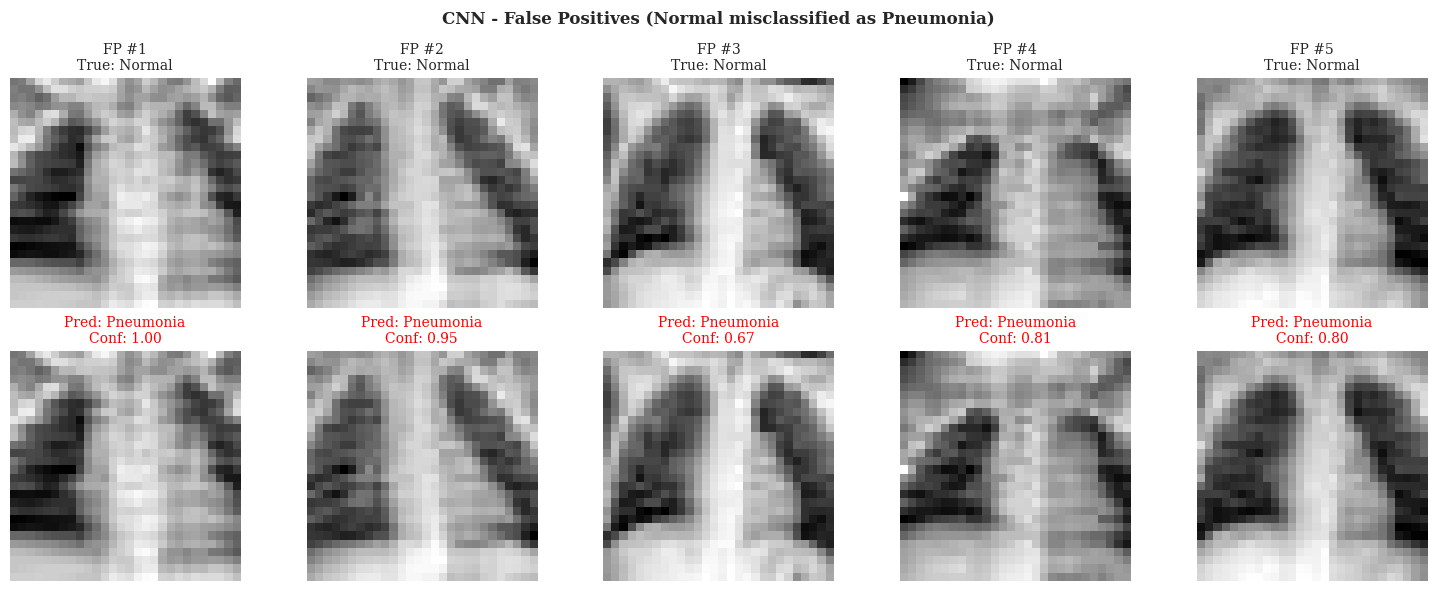

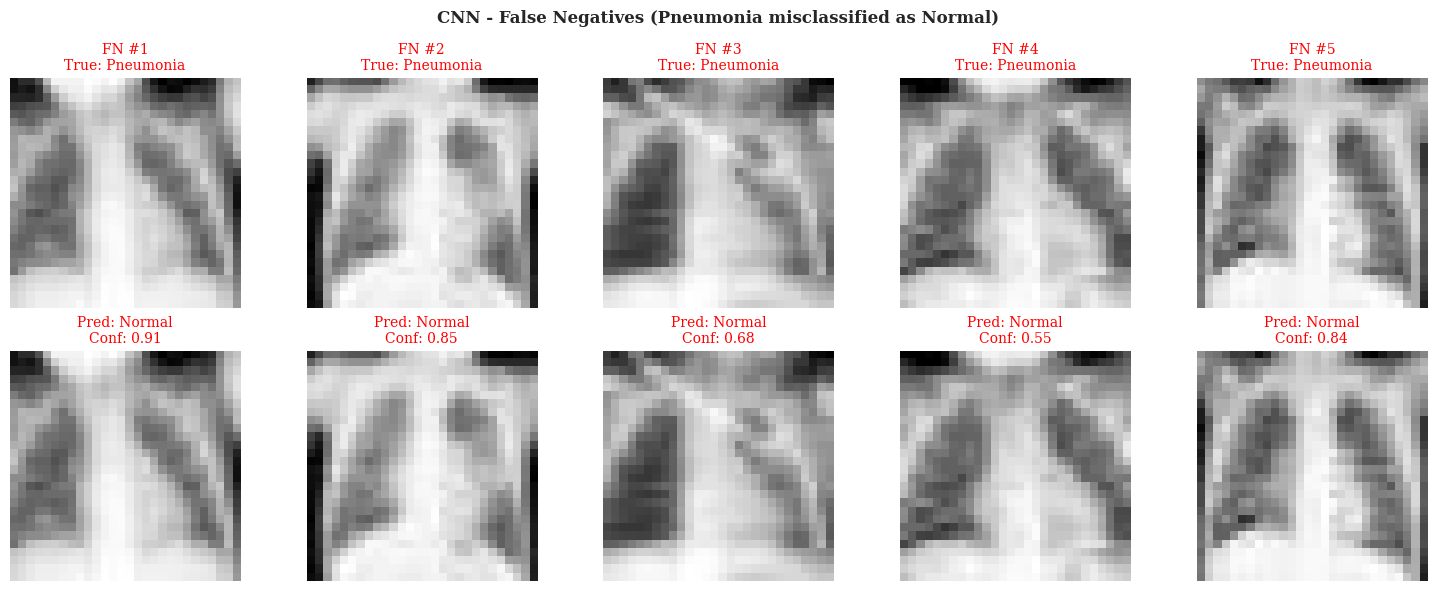


ERROR ANALYSIS - ViT

📊 Error Statistics:
   Total errors: 69 / 624 (11.06%)
   False Positives (Normal→Pneumonia): 53 (76.8% of errors)
   False Negatives (Pneumonia→Normal): 16 (23.2% of errors)
   Avg confidence for False Positives: 0.763
   Avg confidence for False Negatives: 0.707


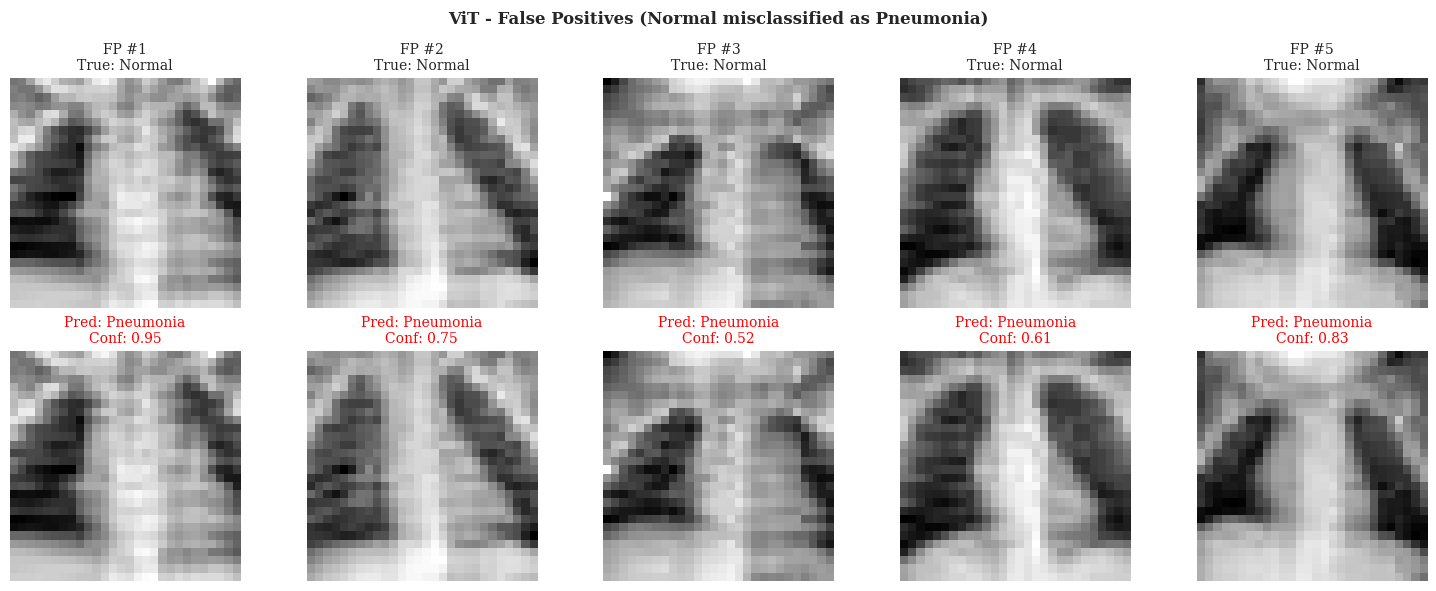

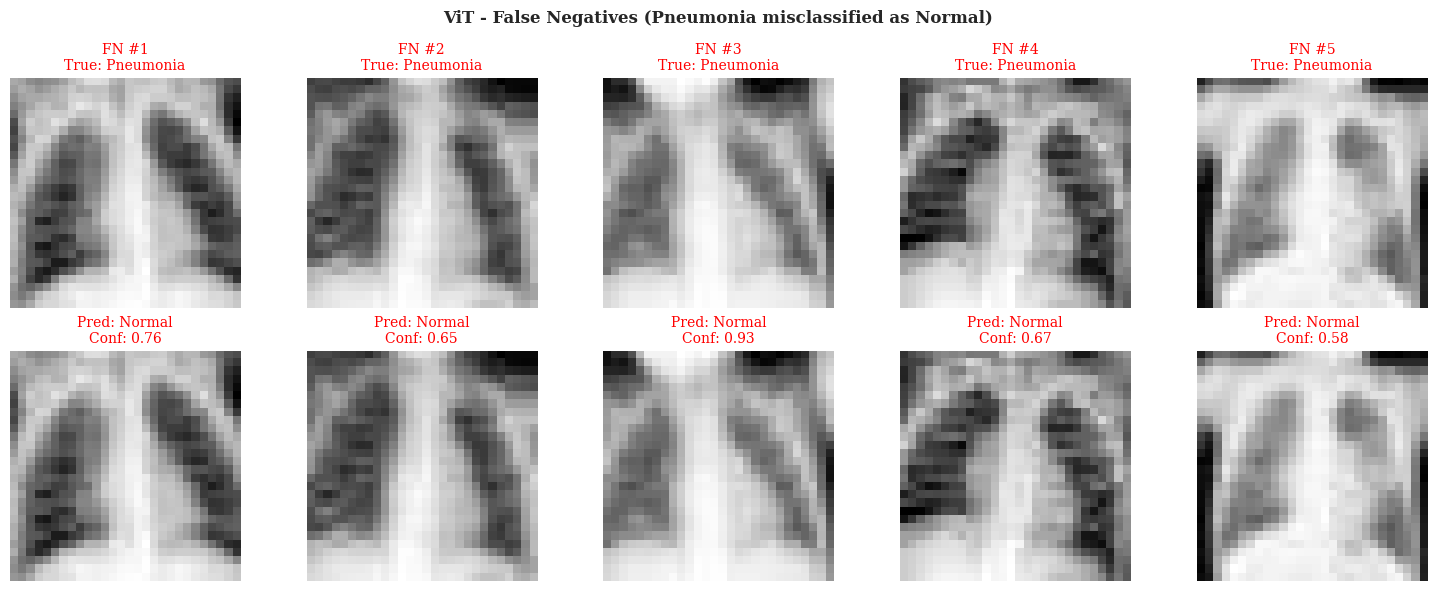


ERROR ANALYSIS - Ensemble

📊 Error Statistics:
   Total errors: 74 / 624 (11.86%)
   False Positives (Normal→Pneumonia): 64 (86.5% of errors)
   False Negatives (Pneumonia→Normal): 10 (13.5% of errors)
   Avg confidence for False Positives: 0.746
   Avg confidence for False Negatives: 0.662


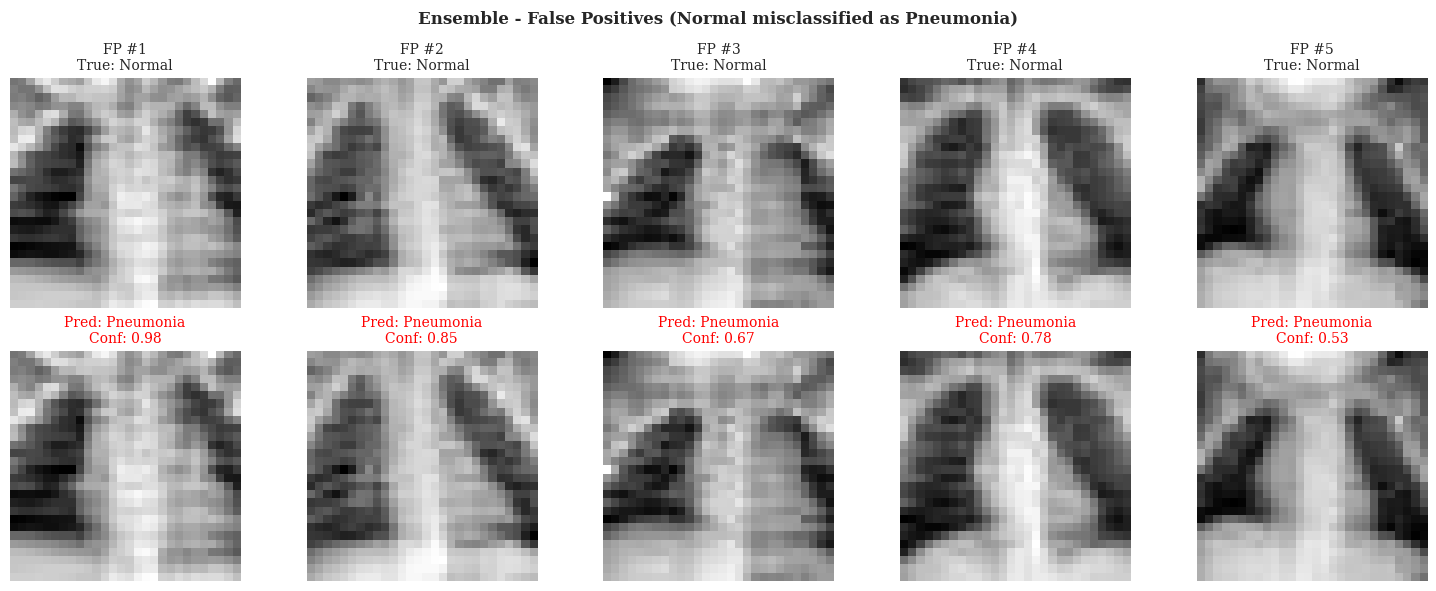

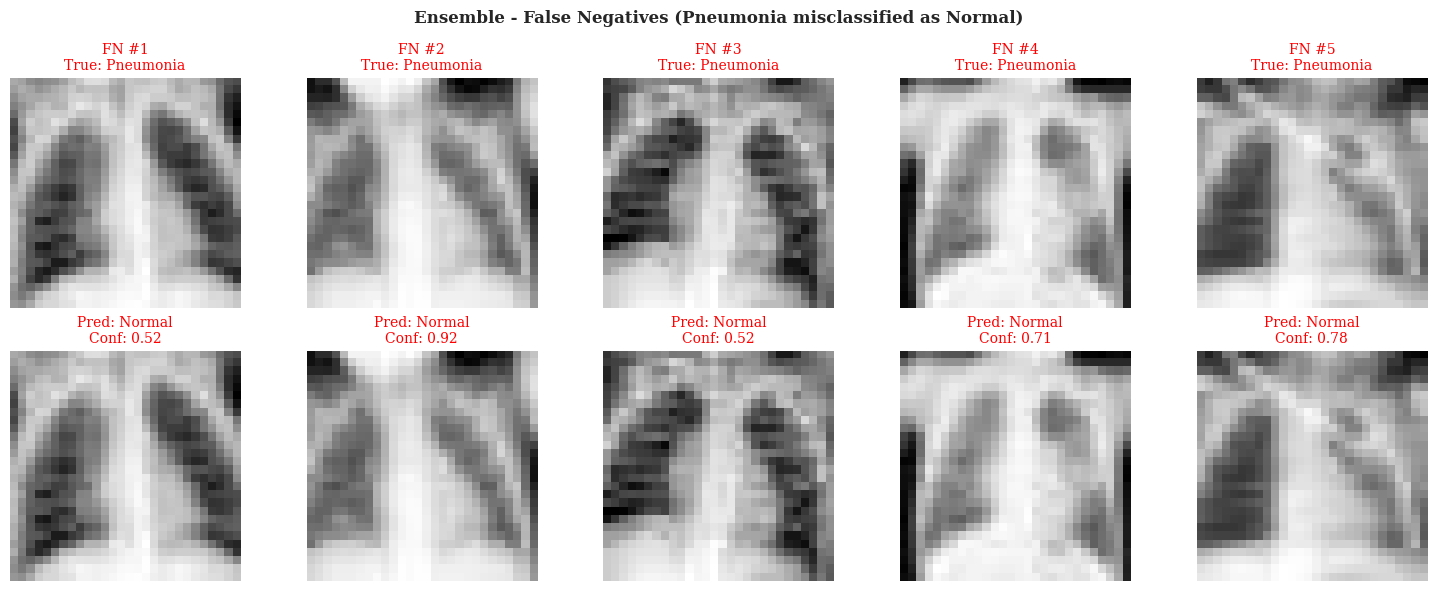


COMPREHENSIVE MODEL COMPARISON TABLE

          Accuracy Precision  Recall F1-Score ROC AUC  PR AUC
Model                                                       
CNN        87.34%    84.63%  97.44%   90.58%  96.46%  97.79%
ViT        88.94%    87.59%  95.90%   91.55%  95.69%  96.97%
Ensemble   88.14%    85.59%  97.44%   91.13%  96.31%  97.39%


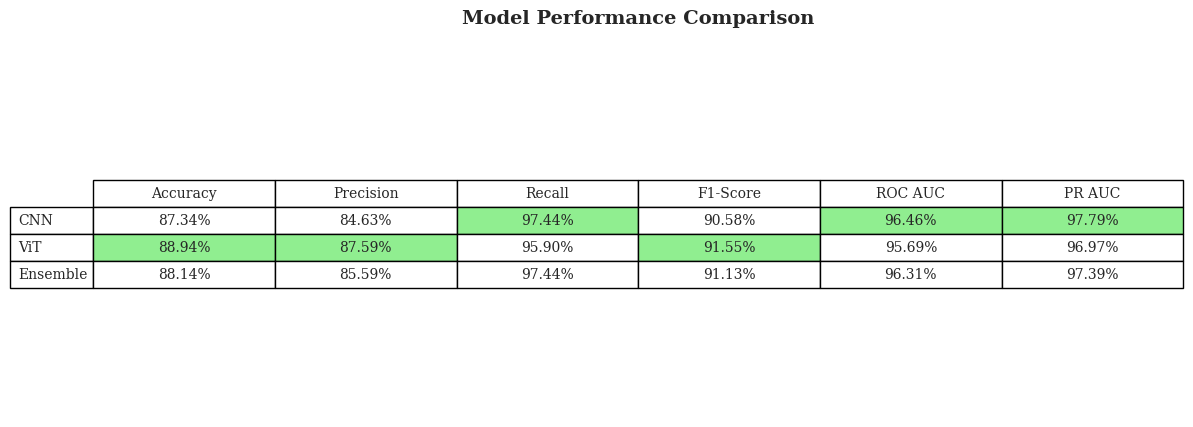


✅ Comparison table saved to ./pneumonia_detection_journal/figures/comparison_table.csv

✅ All visualizations saved to ./pneumonia_detection_journal/figures

SUMMARY

           Accuracy  Precision  Recall  F1-Score  ROC AUC
CNN         0.8734     0.8463  0.9744    0.9058   0.9646
ViT         0.8894     0.8759  0.9590    0.9155   0.9569
Ensemble    0.8814     0.8559  0.9744    0.9113   0.9631

✅ Results saved to ./pneumonia_detection_journal/results
✅ Grad-CAM visualizations saved to ./pneumonia_detection_journal/figures
✅ All visualizations saved to ./pneumonia_detection_journal/figures

🎉 ALL COMPLETED SUCCESSFULLY!


In [ ]:
# ============================================================================
# COMPLETE PIPELINE WITH ALL VISUALIZATIONS (Confusion Matrix, ROC, Error Analysis)
# ============================================================================

# Cell 1: Install and Import
!pip install medmnist tensorflow scikit-learn matplotlib seaborn pandas scipy opencv-python

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                            precision_recall_curve, f1_score, accuracy_score,
                            precision_score, recall_score, cohen_kappa_score,
                            matthews_corrcoef, roc_auc_score, average_precision_score)
import pandas as pd
import medmnist
from medmnist import INFO
import json
import warnings
from datetime import datetime
import cv2
from tensorflow.keras import models as keras_models
warnings.filterwarnings('ignore')

# Print versions
print(f"\nTensorFlow version: {tf.__version__}")
print(f"MedMNIST version: {medmnist.__version__}")

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    DATA_FLAG = "pneumoniamnist"
    IMG_SIZE = 28
    NUM_CLASSES = 2
    CLASS_NAMES = ['Normal', 'Pneumonia']

    BATCH_SIZE = 32
    EPOCHS = 30
    LEARNING_RATE = 0.001
    DROPOUT_RATE = 0.3
    PATIENCE = 5

    BASE_DIR = './pneumonia_detection_journal'
    SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')
    RESULTS_DIR = os.path.join(BASE_DIR, 'results')
    FIGURES_DIR = os.path.join(BASE_DIR, 'figures')

    SEED = 42

# Create directories
for dir_path in [Config.SAVE_DIR, Config.RESULTS_DIR, Config.FIGURES_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# Set seeds
tf.random.set_seed(Config.SEED)
np.random.seed(Config.SEED)

# ============================================================================
# DATA LOADING
# ============================================================================

class PneumoniaDataLoader:
    """Data loader for PneumoniaMNIST"""

    def __init__(self):
        self.info = INFO[Config.DATA_FLAG]
        self.DataClass = getattr(medmnist, self.info['python_class'])

    def load_data(self):
        """Load all data splits"""
        print("\n" + "="*70)
        print("LOADING PNEUMONIAMNIST DATASET")
        print("="*70)

        # Load splits
        train_data = self.DataClass(split='train', download=True)
        val_data = self.DataClass(split='val', download=True)
        test_data = self.DataClass(split='test', download=True)

        # Extract images and labels
        X_train = train_data.imgs
        y_train = train_data.labels.flatten()
        X_val = val_data.imgs
        y_val = val_data.labels.flatten()
        X_test = test_data.imgs
        y_test = test_data.labels.flatten()

        # Normalize to [0, 1]
        X_train = X_train.astype('float32') / 255.0
        X_val = X_val.astype('float32') / 255.0
        X_test = X_test.astype('float32') / 255.0

        # Add channel dimension
        X_train = X_train.reshape(-1, 28, 28, 1)
        X_val = X_val.reshape(-1, 28, 28, 1)
        X_test = X_test.reshape(-1, 28, 28, 1)

        # Convert to RGB for Vision Transformer
        X_train_rgb = np.repeat(X_train, 3, axis=-1)
        X_val_rgb = np.repeat(X_val, 3, axis=-1)
        X_test_rgb = np.repeat(X_test, 3, axis=-1)

        # Print statistics
        print(f"\nDataset Statistics:")
        print(f"Training samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        print(f"Test samples: {len(X_test)}")
        print(f"Class distribution - Normal: {np.sum(y_train==0)}, Pneumonia: {np.sum(y_train==1)}")

        # Convert labels to categorical
        y_train_cat = tf.keras.utils.to_categorical(y_train, Config.NUM_CLASSES)
        y_val_cat = tf.keras.utils.to_categorical(y_val, Config.NUM_CLASSES)
        y_test_cat = tf.keras.utils.to_categorical(y_test, Config.NUM_CLASSES)

        return {
            'train': (X_train, X_train_rgb, y_train, y_train_cat),
            'val': (X_val, X_val_rgb, y_val, y_val_cat),
            'test': (X_test, X_test_rgb, y_test, y_test_cat)
        }, (X_train, X_train_rgb, y_train, y_train_cat), (X_val, X_val_rgb, y_val, y_val_cat), (X_test, X_test_rgb, y_test, y_test_cat)

# ============================================================================
# DATASET VISUALIZATION
# ============================================================================

def visualize_dataset(data):
    """Visualize dataset samples and distribution"""

    X_train, _, y_train, _ = data['train']
    _, _, y_val, _ = data['val']
    _, _, y_test, _ = data['test']

    # 1. Sample images (10 from each class)
    fig, axes = plt.subplots(2, 10, figsize=(20, 5))

    normal_indices = np.where(y_train == 0)[0][:10]
    pneumonia_indices = np.where(y_train == 1)[0][:10]

    for i, idx in enumerate(normal_indices):
        axes[0, i].imshow(X_train[idx].squeeze(), cmap='gray')
        axes[0, i].set_title(f'Normal #{i+1}', fontsize=8)
        axes[0, i].axis('off')

    for i, idx in enumerate(pneumonia_indices):
        axes[1, i].imshow(X_train[idx].squeeze(), cmap='gray')
        axes[1, i].set_title(f'Pneumonia #{i+1}', fontsize=8, color='red')
        axes[1, i].axis('off')

    plt.suptitle('PneumoniaMNIST Dataset - 10 Sample Images from Each Class',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.FIGURES_DIR, 'dataset_samples.png'), dpi=150)
    plt.show()

    # 2. Class distribution
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    splits = ['Training', 'Validation', 'Test']
    totals = [len(y_train), len(y_val), len(y_test)]
    normals = [np.sum(y_train == 0), np.sum(y_val == 0), np.sum(y_test == 0)]
    pneumonias = [np.sum(y_train == 1), np.sum(y_val == 1), np.sum(y_test == 1)]

    for i, (split, total, normal, pneumonia) in enumerate(zip(splits, totals, normals, pneumonias)):
        axes[i].bar(['Normal', 'Pneumonia'], [normal, pneumonia],
                   color=['#3498db', '#e74c3c'])
        axes[i].set_title(f'{split} Set\nTotal: {total} images', fontweight='bold')
        axes[i].set_ylabel('Number of Images')

        # Add value labels
        for j, count in enumerate([normal, pneumonia]):
            axes[i].text(j, count + 5, str(count), ha='center', va='bottom')

    plt.suptitle('Class Distribution Across Splits', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.FIGURES_DIR, 'class_distribution.png'), dpi=150)
    plt.show()

# ============================================================================
# MODEL ARCHITECTURES
# ============================================================================

def create_cnn_model():
    """Create CNN model"""
    inputs = layers.Input(shape=(28, 28, 1))

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    return models.Model(inputs, outputs)

def create_vit_model():
    """Create Vision Transformer model"""
    inputs = layers.Input(shape=(28, 28, 3))

    # Patch embedding
    x = layers.Conv2D(64, 7, strides=4, padding='same', activation='relu')(inputs)
    x = layers.Reshape((-1, 64))(x)

    # Position embedding
    positions = tf.range(start=0, limit=49, delta=1)
    pos_embed = layers.Embedding(49, 64)(positions)
    x = x + pos_embed

    # Transformer block
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.GlobalAveragePooling1D()(x)

    # Classification head
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    return models.Model(inputs, outputs)

# ============================================================================
# TRAINER CLASS
# ============================================================================

class ModelTrainer:
    def __init__(self, model, model_name):
        self.model = model
        self.model_name = model_name
        self.history = None

    def train(self, X_train, y_train, X_val, y_val):
        """Train the model"""

        # Data augmentation
        aug = tf.keras.Sequential([
            layers.RandomRotation(0.1),
            layers.RandomTranslation(0.1, 0.1),
            layers.RandomZoom(0.1),
        ])

        # Compile
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE),
            loss='categorical_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                     tf.keras.metrics.Precision(name='precision'),
                     tf.keras.metrics.Recall(name='recall')]
        )

        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=Config.PATIENCE,
                         restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
            ModelCheckpoint(
                os.path.join(Config.SAVE_DIR, f'{self.model_name}_best.weights.h5'),
                monitor='val_accuracy', save_best_only=True,
                save_weights_only=True, verbose=1
            )
        ]

        # Create datasets
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_ds = train_ds.shuffle(1000).batch(Config.BATCH_SIZE).map(
            lambda x, y: (aug(x, training=True), y)
        ).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
                                 .batch(Config.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

        # Train
        self.history = self.model.fit(
            train_ds, validation_data=val_ds,
            epochs=Config.EPOCHS, callbacks=callbacks, verbose=1
        )

        return self.history

# ============================================================================
# ENSEMBLE
# ============================================================================

class Ensemble:
    def __init__(self, models):
        self.models = models

    def predict(self, X_cnn, X_vit):
        """Average predictions from both models"""
        cnn_pred = self.models[0].predict(X_cnn, verbose=0)
        vit_pred = self.models[1].predict(X_vit, verbose=0)
        return (cnn_pred + vit_pred) / 2

# ============================================================================
# METRICS
# ============================================================================

class MetricsCalculator:
    def calculate_all(self, y_true, y_pred, y_probs):
        """Calculate all metrics"""
        return {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1_score': f1_score(y_true, y_pred),
            'roc_auc': auc(*roc_curve(y_true, y_probs)[:2]),
            'pr_auc': auc(*precision_recall_curve(y_true, y_probs)[1::-1]),
            'confusion_matrix': confusion_matrix(y_true, y_pred).tolist()
        }

    def print_table(self, metrics, name):
        """Print metrics table"""
        print(f"\n{'='*60}")
        print(f"{name} RESULTS")
        print(f"{'='*60}")
        print(f"Accuracy:  {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall:    {metrics['recall']:.4f}")
        print(f"F1-Score:  {metrics['f1_score']:.4f}")
        print(f"ROC AUC:   {metrics['roc_auc']:.4f}")
        print(f"PR AUC:    {metrics['pr_auc']:.4f}")

# ============================================================================
# GRAD-CAM VISUALIZATION
# ============================================================================

def minimal_gradcam(model, image, layer_name=None):
    """Absolute minimal Grad-CAM implementation"""

    # Find conv layer
    if layer_name is None:
        for layer in reversed(model.layers):
            if 'conv' in layer.name.lower():
                layer_name = layer.name
                break

    if layer_name is None:
        raise ValueError("No convolutional layer found")

    # Create gradient model
    grad_model = keras_models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    # Prepare image
    if len(image.shape) == 3:
        img_array = np.expand_dims(image, axis=0)
    else:
        img_array = image

    # Get prediction
    preds = model.predict(img_array, verbose=0)[0]
    class_idx = np.argmax(preds)

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    # Get gradients and compute heatmap
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)
    cam = tf.nn.relu(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-7)

    # Resize
    heatmap = tf.image.resize(cam[..., tf.newaxis],
                              (image.shape[0], image.shape[1])).numpy().squeeze()

    return heatmap, class_idx, preds[class_idx]

def show_gradcam_samples(model, model_name, X_test, y_test, num_samples=4, save_dir=None):
    """Show Grad-CAM for sample images"""

    print(f"\n📊 Generating Grad-CAM for {model_name}...")

    # Select samples (mix of normal and pneumonia)
    normal_idx = np.where(y_test == 0)[0][:2]
    pneumonia_idx = np.where(y_test == 1)[0][:2]
    sample_indices = np.concatenate([normal_idx, pneumonia_idx])

    fig, axes = plt.subplots(2, len(sample_indices), figsize=(16, 8))

    for i, idx in enumerate(sample_indices):
        img = X_test[idx]

        # Generate Grad-CAM
        heatmap, pred_class, conf = minimal_gradcam(model, img)

        # Original image
        axes[0, i].imshow(img.squeeze(), cmap='gray')
        true_label = "Normal" if y_test[idx] == 0 else "Pneumonia"
        axes[0, i].set_title(f'True: {true_label}', fontsize=10)
        axes[0, i].axis('off')

        # Overlay
        axes[1, i].imshow(img.squeeze(), cmap='gray')
        axes[1, i].imshow(heatmap, cmap='jet', alpha=0.5)
        pred_label = Config.CLASS_NAMES[pred_class]
        color = 'green' if pred_class == y_test[idx] else 'red'
        axes[1, i].set_title(f'Pred: {pred_label}\nConf: {conf:.2f}',
                            fontsize=9, color=color)
        axes[1, i].axis('off')

    plt.suptitle(f'{model_name} - Grad-CAM Visualization', fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, f'gradcam_{model_name.lower()}.png'),
                   dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Grad-CAM for {model_name} complete")

# ============================================================================
# VISUALIZATION FUNCTIONS (Confusion Matrix, ROC, Error Analysis)
# ============================================================================

def plot_confusion_matrix(cm, model_name, save_dir=None):
    """
    Plot enhanced confusion matrix with percentages
    """
    plt.figure(figsize=(8, 6))

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=Config.CLASS_NAMES,
                yticklabels=Config.CLASS_NAMES,
                annot_kws={'size': 14})

    # Add percentage labels
    for i in range(2):
        for j in range(2):
            plt.gca().text(j+0.5, i+0.7, f'({cm_percent[i,j]:.1f}%)',
                          ha='center', va='center', fontsize=10)

    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, f'{model_name.lower()}_confusion.png'),
                   dpi=150, bbox_inches='tight')
    plt.show()

    # Print analysis
    print(f"\n📊 {model_name} Confusion Matrix Analysis:")
    print(f"   True Negatives (Normal correct): {cm[0,0]}")
    print(f"   False Positives (Normal→Pneumonia): {cm[0,1]}")
    print(f"   False Negatives (Pneumonia→Normal): {cm[1,0]}")
    print(f"   True Positives (Pneumonia correct): {cm[1,1]}")
    print(f"   Accuracy: {(cm[0,0] + cm[1,1]) / np.sum(cm):.2%}")

def plot_roc_curves_comparison(results_dict, save_dir=None):
    """
    Plot ROC curves for all models comparison
    """
    plt.figure(figsize=(10, 8))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    for i, (name, data) in enumerate(results_dict.items()):
        fpr, tpr, _ = roc_curve(data['y_true'], data['y_probs'])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
                label=f'{name} (AUC = {roc_auc:.4f})')

    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5, label='Random Classifier')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, 'roc_curves_comparison.png'),
                   dpi=150, bbox_inches='tight')
    plt.show()

def plot_pr_curves_comparison(results_dict, save_dir=None):
    """
    Plot Precision-Recall curves for all models comparison
    """
    plt.figure(figsize=(10, 8))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    for i, (name, data) in enumerate(results_dict.items()):
        precision, recall, _ = precision_recall_curve(data['y_true'], data['y_probs'])
        pr_auc = auc(recall, precision)

        plt.plot(recall, precision, color=colors[i % len(colors)], lw=2,
                label=f'{name} (AP = {pr_auc:.4f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, 'pr_curves_comparison.png'),
                   dpi=150, bbox_inches='tight')
    plt.show()

def plot_error_analysis(y_true, y_pred, y_probs, X_test, model_name, save_dir=None, num_samples=5):
    """
    Comprehensive error analysis with visualization of misclassified samples
    """
    print(f"\n{'='*60}")
    print(f"ERROR ANALYSIS - {model_name}")
    print(f"{'='*60}")

    # Find misclassified indices
    misclassified = np.where(y_true != y_pred)[0]
    false_positives = np.where((y_true == 0) & (y_pred == 1))[0]
    false_negatives = np.where((y_true == 1) & (y_pred == 0))[0]

    total_errors = len(misclassified)
    fp_count = len(false_positives)
    fn_count = len(false_negatives)

    print(f"\n📊 Error Statistics:")
    print(f"   Total errors: {total_errors} / {len(y_true)} ({total_errors/len(y_true)*100:.2f}%)")
    print(f"   False Positives (Normal→Pneumonia): {fp_count} ({fp_count/total_errors*100:.1f}% of errors)" if total_errors > 0 else "   False Positives: 0")
    print(f"   False Negatives (Pneumonia→Normal): {fn_count} ({fn_count/total_errors*100:.1f}% of errors)" if total_errors > 0 else "   False Negatives: 0")

    if fp_count > 0:
        fp_conf = np.mean(y_probs[false_positives])
        print(f"   Avg confidence for False Positives: {fp_conf:.3f}")

    if fn_count > 0:
        fn_conf = np.mean(1 - y_probs[false_negatives])
        print(f"   Avg confidence for False Negatives: {fn_conf:.3f}")

    # Visualize false positives
    if fp_count > 0:
        fig, axes = plt.subplots(2, min(5, fp_count), figsize=(15, 6))
        if fp_count == 1:
            axes = axes.reshape(2, 1)

        samples = false_positives[:min(5, fp_count)]

        for i, idx in enumerate(samples):
            # Original image
            img = X_test[idx].squeeze() if len(X_test[idx].shape) > 2 else X_test[idx]
            if len(img.shape) == 3 and img.shape[-1] == 3:
                img = img[:, :, 0]  # Take first channel for RGB

            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(f'FP #{i+1}\nTrue: Normal', fontsize=10)
            axes[0, i].axis('off')

            # With confidence
            axes[1, i].imshow(img, cmap='gray')
            axes[1, i].set_title(f'Pred: Pneumonia\nConf: {y_probs[idx]:.2f}',
                                 fontsize=10, color='red')
            axes[1, i].axis('off')

        plt.suptitle(f'{model_name} - False Positives (Normal misclassified as Pneumonia)',
                    fontsize=12, fontweight='bold')
        plt.tight_layout()
        if save_dir:
            plt.savefig(os.path.join(save_dir, f'{model_name.lower()}_false_positives.png'),
                       dpi=150, bbox_inches='tight')
        plt.show()

    # Visualize false negatives
    if fn_count > 0:
        fig, axes = plt.subplots(2, min(5, fn_count), figsize=(15, 6))
        if fn_count == 1:
            axes = axes.reshape(2, 1)

        samples = false_negatives[:min(5, fn_count)]

        for i, idx in enumerate(samples):
            # Original image
            img = X_test[idx].squeeze() if len(X_test[idx].shape) > 2 else X_test[idx]
            if len(img.shape) == 3 and img.shape[-1] == 3:
                img = img[:, :, 0]  # Take first channel for RGB

            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(f'FN #{i+1}\nTrue: Pneumonia', fontsize=10, color='red')
            axes[0, i].axis('off')

            # With confidence
            axes[1, i].imshow(img, cmap='gray')
            axes[1, i].set_title(f'Pred: Normal\nConf: {1-y_probs[idx]:.2f}',
                                 fontsize=10, color='red')
            axes[1, i].axis('off')

        plt.suptitle(f'{model_name} - False Negatives (Pneumonia misclassified as Normal)',
                    fontsize=12, fontweight='bold')
        plt.tight_layout()
        if save_dir:
            plt.savefig(os.path.join(save_dir, f'{model_name.lower()}_false_negatives.png'),
                       dpi=150, bbox_inches='tight')
        plt.show()

    return {
        'total_errors': total_errors,
        'false_positives': fp_count,
        'false_negatives': fn_count,
        'fp_confidence': float(np.mean(y_probs[false_positives])) if fp_count > 0 else 0,
        'fn_confidence': float(np.mean(1 - y_probs[false_negatives])) if fn_count > 0 else 0
    }

def plot_comparison_table(results_dict, save_dir=None):
    """
    Create a comprehensive comparison table with all metrics
    """
    # Create DataFrame with all metrics
    comparison_data = []

    for name, data in results_dict.items():
        row = {
            'Model': name,
            'Accuracy': f"{data['accuracy']:.2%}",
            'Precision': f"{data['precision']:.2%}",
            'Recall': f"{data['recall']:.2%}",
            'F1-Score': f"{data['f1_score']:.2%}",
            'ROC AUC': f"{data['roc_auc']:.2%}",
            'PR AUC': f"{data['pr_auc']:.2%}"
        }
        comparison_data.append(row)

    df = pd.DataFrame(comparison_data)
    df.set_index('Model', inplace=True)

    # Display as styled table
    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL COMPARISON TABLE")
    print("="*80)
    print("\n", df)

    # Create a styled figure
    fig, ax = plt.subplots(figsize=(12, len(df) * 0.8 + 2))
    ax.axis('tight')
    ax.axis('off')

    # Create table
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     rowLabels=df.index,
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.15] * len(df.columns))

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Color code the best values
    for i, col in enumerate(df.columns):
        # Convert percentage strings back to float for comparison
        values = [float(v.strip('%'))/100 for v in df[col].values]
        best_idx = np.argmax(values)

        # Highlight best cell
        cell = table[(best_idx + 1, i)]
        cell.set_facecolor('#90EE90')  # Light green

    plt.title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()

    if save_dir:
        plt.savefig(os.path.join(save_dir, 'comparison_table.png'),
                   dpi=150, bbox_inches='tight')
    plt.show()

    # Save CSV
    csv_path = os.path.join(save_dir, 'comparison_table.csv') if save_dir else 'comparison_table.csv'
    df.to_csv(csv_path)
    print(f"\n✅ Comparison table saved to {csv_path}")

    return df

def plot_all_visualizations(model_names, y_trues, y_preds, y_probss, X_tests,
                           results_dict, save_dir=None):
    """
    Generate all visualizations in one go
    """
    print("\n" + "="*80)
    print("GENERATING ALL VISUALIZATIONS")
    print("="*80)

    # 1. Confusion matrices for each model
    for i, name in enumerate(model_names):
        cm = confusion_matrix(y_trues[i], y_preds[i])
        plot_confusion_matrix(cm, name, save_dir)

    # 2. ROC curves comparison
    roc_data = {name: {'y_true': y_trues[i], 'y_probs': y_probss[i]}
                for i, name in enumerate(model_names)}
    plot_roc_curves_comparison(roc_data, save_dir)

    # 3. PR curves comparison
    plot_pr_curves_comparison(roc_data, save_dir)

    # 4. Error analysis for each model
    for i, name in enumerate(model_names):
        plot_error_analysis(y_trues[i], y_preds[i], y_probss[i],
                           X_tests[i], name, save_dir)

    # 5. Comparison table
    plot_comparison_table(results_dict, save_dir)

    print(f"\n✅ All visualizations saved to {save_dir}")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print("\n" + "="*70)
    print("PNEUMONIA DETECTION SYSTEM WITH GRAD-CAM")
    print("="*70)

    # Load data
    loader = PneumoniaDataLoader()
    data, train_data, val_data, test_data = loader.load_data()

    # Unpack test data for later use
    X_test, X_test_rgb, y_test, y_test_cat = test_data
    X_train, X_train_rgb, y_train, y_train_cat = train_data
    X_val, X_val_rgb, y_val, y_val_cat = val_data

    # Visualize dataset
    visualize_dataset(data)

    # Initialize
    calculator = MetricsCalculator()
    models = []
    results = {}

    # 1. Train CNN
    print("\n" + "#"*70)
    print("Training CNN Model")
    print("#"*70)

    cnn_model = create_cnn_model()
    trainer = ModelTrainer(cnn_model, 'cnn')
    trainer.train(X_train, y_train_cat, X_val, y_val_cat)

    y_pred_probs_cnn = cnn_model.predict(X_test, verbose=0)
    y_pred_cnn = np.argmax(y_pred_probs_cnn, axis=1)
    metrics_cnn = calculator.calculate_all(y_test, y_pred_cnn, y_pred_probs_cnn[:, 1])
    calculator.print_table(metrics_cnn, "CNN")

    results['CNN'] = metrics_cnn
    models.append(cnn_model)

    # 2. Train ViT
    print("\n" + "#"*70)
    print("Training Vision Transformer")
    print("#"*70)

    vit_model = create_vit_model()
    trainer = ModelTrainer(vit_model, 'vit')
    trainer.train(X_train_rgb, y_train_cat, X_val_rgb, y_val_cat)

    y_pred_probs_vit = vit_model.predict(X_test_rgb, verbose=0)
    y_pred_vit = np.argmax(y_pred_probs_vit, axis=1)
    metrics_vit = calculator.calculate_all(y_test, y_pred_vit, y_pred_probs_vit[:, 1])
    calculator.print_table(metrics_vit, "Vision Transformer")

    results['ViT'] = metrics_vit
    models.append(vit_model)

    # ========================================================================
    # GRAD-CAM VISUALIZATION
    # ========================================================================

    print("\n" + "="*70)
    print("GRAD-CAM INTERPRETABILITY ANALYSIS")
    print("="*70)

    # Grad-CAM for CNN
    show_gradcam_samples(
        cnn_model, "CNN",
        X_test, y_test,
        num_samples=4,
        save_dir=Config.FIGURES_DIR
    )

    # Grad-CAM for ViT
    show_gradcam_samples(
        vit_model, "ViT",
        X_test_rgb, y_test,
        num_samples=4,
        save_dir=Config.FIGURES_DIR
    )

    # 3. Ensemble
    print("\n" + "#"*70)
    print("Ensemble Prediction")
    print("#"*70)

    ensemble = Ensemble(models)
    ensemble_probs = ensemble.predict(X_test, X_test_rgb)
    y_pred_ensemble = np.argmax(ensemble_probs, axis=1)
    metrics_ensemble = calculator.calculate_all(y_test, y_pred_ensemble, ensemble_probs[:, 1])
    calculator.print_table(metrics_ensemble, "Ensemble")

    results['Ensemble'] = metrics_ensemble

    # ========================================================================
    # COMPREHENSIVE VISUALIZATIONS
    # ========================================================================

    # Collect data for visualizations
    model_names = ['CNN', 'ViT', 'Ensemble']
    y_trues = [
        y_test,                          # CNN
        y_test,                          # ViT
        y_test                           # Ensemble
    ]
    y_preds = [
        y_pred_cnn,                       # CNN predictions
        y_pred_vit,                       # ViT predictions
        y_pred_ensemble                    # Ensemble predictions
    ]
    y_probss = [
        y_pred_probs_cnn[:, 1],           # CNN probabilities
        y_pred_probs_vit[:, 1],           # ViT probabilities
        ensemble_probs[:, 1]               # Ensemble probabilities
    ]
    X_tests = [
        X_test,                           # CNN test images (grayscale)
        X_test_rgb,                        # ViT test images (RGB)
        X_test                              # Ensemble test images (use grayscale for display)
    ]

    # Generate all visualizations
    plot_all_visualizations(
        model_names=model_names,
        y_trues=y_trues,
        y_preds=y_preds,
        y_probss=y_probss,
        X_tests=X_tests,
        results_dict=results,
        save_dir=Config.FIGURES_DIR
    )

    # Summary
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    summary = pd.DataFrame({
        name: {
            'Accuracy': r['accuracy'],
            'Precision': r['precision'],
            'Recall': r['recall'],
            'F1-Score': r['f1_score'],
            'ROC AUC': r['roc_auc']
        } for name, r in results.items()
    }).T
    print("\n", summary.round(4))

    # Save results
    summary.to_csv(os.path.join(Config.RESULTS_DIR, 'results.csv'))

    # Save all results as JSON
    final_results = {
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'config': {
            'batch_size': Config.BATCH_SIZE,
            'epochs': Config.EPOCHS,
            'learning_rate': Config.LEARNING_RATE
        },
        'results': {name: {
            'accuracy': float(r['accuracy']),
            'precision': float(r['precision']),
            'recall': float(r['recall']),
            'f1_score': float(r['f1_score']),
            'roc_auc': float(r['roc_auc']),
            'pr_auc': float(r['pr_auc'])
        } for name, r in results.items()}
    }

    with open(os.path.join(Config.RESULTS_DIR, 'final_results.json'), 'w') as f:
        json.dump(final_results, f, indent=4)

    print(f"\n✅ Results saved to {Config.RESULTS_DIR}")
    print(f"✅ Grad-CAM visualizations saved to {Config.FIGURES_DIR}")
    print(f"✅ All visualizations saved to {Config.FIGURES_DIR}")
    print(f"\n{'='*70}")
    print("🎉 ALL COMPLETED SUCCESSFULLY!")
    print("="*70)

if __name__ == "__main__":
    main()